In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Python/ImpVol

Mounted at /content/drive
/content/drive/My Drive/Python/ImpVol


In [2]:
!pip install q pymc3
!pip install q tdqm
!pip install q cvxopt
!apt-get install libgmp-dev python3-dev
!pip install wheel
!pip install pypoman
!pip3 install tensorflow==2.2
!pip3 install keras==2.3.1
!pip install tensorflow-model-optimization==0.4.0
!pip install tensorflow_probability==0.9.0
# !pip install vartests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=7477a773a8fbc33de1c3a5bbc00577081baa305f99c974d363ebde27f208d6b6
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1323 sha256=4cca097c5874573dfc53bb081480f0b2f4125d34a3f02989aa654085c65ba0cb
  Stored in directory: /root/.cache/pip/wheels/86/cd/38/f96ed05dd8049e95d8fbeaa0587664eb001a1848979636b771
Successfully built tdqm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.8.2-0ubuntu2).
python3-dev set to manually installed.
Suggested packages:
  gmp-doc libgmp10-doc libmpfr-dev
The following NEW packages will be installed:
  libgmp-dev libgmpxx4ldbl
0 upgraded, 2 newly installed, 0 to remove and 19 not upgraded.
Need to get 330 kB of archives.
After this operation, 1,786 kB of additional disk space will be us

In [3]:
import os
import sys
import random

import pickle
import numpy as np
import pandas as pd
import scipy as sp
import joblib

from marketmodel.loader import DataOm
# from marketmodel import utils
# from marketmodel.neuralsde1 import Train
# from marketmodel.normalize import normalize
from marketmodel.alphaRNN import *
from marketmodel.alphatRNN import *

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, Lambda

from google.colab import files

import csv
import warnings

# import arviz as az
# import pymc3 as pm
import seaborn as sns
from numpy import ndarray

from datetime import datetime
import matplotlib.dates

from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Layer, LSTM, GRU, SimpleRNN
from keras.models import load_model
from keras.models import Sequential
from keras import optimizers
from keras.regularizers import l1,l2
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.layers import Layer,RNN
from keras import backend as K
from keras import layers
import keras.layers
from keras.legacy import interfaces
from keras import *
from keras import Input, Model


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import statsmodels.api as sm

from glob import glob
import tensorflow_model_optimization as tfmot
import tensorflow_probability as tfp

Using TensorFlow backend.


In [4]:
# load OptionMetric data
ls_securityid = ['DAX']
in_dir = '/content/drive/My Drive/Python/ImpVol/input/'
dt = 1./252

curr_module = sys.modules[__name__]

ls_X = []
ls_dX = []
ls_S = []
ls_S_test = []
ls_C = []
ls_C_test = []
ls_dates = []
for i_securityid in range(len(ls_securityid)):
    securityid = ls_securityid[i_securityid]
    
    fname = in_dir + f'om_{securityid}.pkl'
    with open(fname, 'rb') as f:
        cache = pickle.load(f)
        
    for k, v in vars(cache).items():
        setattr(curr_module, k, v)
    
    ls_X.append(X)
    ls_dX.append(dX)
    ls_S.append(S)
    ls_S_test.append(S_test)
    ls_C.append(cs)
    ls_C_test.append(cs_test)
    ls_dates.append(dates_train)

# concatenate factor data
X = np.vstack(ls_X)
dX = np.vstack(ls_dX)

start = 1767
R = np.diff(np.log(S))
S = S[:-1]
R = R[(start-1):]
S = S[(start-1):]


# Create Date data for ploting
N_test = 1000
t = dates_train[0:-N_test]
t = t[0:-1]
t = t.astype(datetime)
Date = [datetime.strptime(x,'%Y-%m-%d') for x in t]

t_test = dates_train[-N_test:]
t_test = t_test[0:-1]
t_test = t_test.astype(datetime)
Date_test = [datetime.strptime(x,'%Y-%m-%d') for x in t_test]

# Split data to training and test
S_all = S
X_all = X
cs_all = cs
S_test = S[-N_test:]
X_test = X[-N_test:,:]
cs_test = cs[-N_test:,:]
S = S[0:-N_test]
X = X[0:-N_test,:]
cs = cs[0:-N_test,:]

In [5]:
V_norm_all = pd.read_csv('/content/drive/My Drive/Python/ImpVol/input/V_norm_all.csv')
R_all = pd.DataFrame(R,columns=['R'])
V_norm1 = V_norm_all.iloc[:,0:3]
V_norm2 = V_norm_all.iloc[:,-5:]

In [6]:
X1 = R_all.drop(R_all.tail(1).index,inplace=False)
X1.reset_index(drop=True, inplace=True)
X1_train = X1.iloc[:(-N_test),:]
X1_mean = X1_train.mean()
X1_std = X1_train.std()
X1 = (X1-X1_mean[0])/X1_std[0]
X_norm1 = V_norm1.drop(V_norm1.head(1).index,inplace=False)
X_norm1.reset_index(drop=True, inplace=True)
X_all1 = pd.concat([X1,X_norm1],axis=1)
X_norm2 = V_norm2.drop(V_norm2.head(1).index,inplace=False)
X_norm2.reset_index(drop=True, inplace=True)
X_all2 = pd.concat([X1,X_norm2],axis=1)

X_train1 = X_all1.iloc[:(-N_test),:]
X_test1 = X_all1.iloc[-N_test:,:]
X_train2 = X_all2.iloc[:(-N_test),:]
X_test2 = X_all2.iloc[-N_test:,:]

X_train = [X_train1,X_train2]
X_test = [X_test1,X_test2]

In [7]:
X_train1.head(10)

R    Comp 1    Comp 2    Comp 3
0  2.405849  1.879508  0.187964 -3.190381
1  0.125900  1.959160  0.104592 -2.745338
2  0.586034  1.860649  0.262087 -2.658205
3 -1.343507  2.092368 -0.098111 -2.321481
4 -0.895592  2.278085 -0.222501 -2.225722
5 -1.492997  2.389324 -0.244408 -2.460430
6 -1.027526  2.460882 -0.412803 -2.491362
7 -1.332693  2.640437 -0.182716 -2.361154
8 -3.512525  3.238969 -0.621365 -1.384932
9 -1.472276  3.332183 -0.383617 -1.228748

In [8]:
class Loss(object):
  def loss_lnS(y_true, y_pred):
    alpha = y_pred[:,0]
    gamma = y_pred[:,1]
    dX = y_true
            
    # compute log-likelihood
    l = tf.reduce_sum(-gamma + tf.square(dX - (alpha)*dt)*tf.exp(gamma)/dt )
    return l
  
  def loss_lnS_std(y_true,y_pred):
    alpha = y_pred[:,0]
    gamma = y_pred[:,1]

    nu = tf.reduce_mean(tf.square(y_pred[:,2]))
    nu = tf.cast(nu,tf.float32)
    # nu = tf.math.maximum(1,nu)
    
    dX = y_true

    l = tf.reduce_sum(-gamma + (nu+1)*tf.math.log(1+tf.square(dX - alpha)*tf.exp(gamma)/nu) +2*tf.math.lgamma(nu/2)-2*tf.math.lgamma((nu+1)/2)+tf.math.log(nu))

    return l
  
  def loss_lnS_MD(y_true,y_pred):
    alpha = y_pred[:,0]
    gamma = y_pred[:,1]

    dX = y_true

    l = tf.reduce_sum( tf.square(dX - (alpha)*dt)*tf.exp(gamma)/dt )

    return l

  def loss_lnS_sigma(y_true,y_pred):

    l = tf.reduce_sum(-y_pred + tf.square(y_true)*tf.exp(y_pred)/dt )

    return l
    

In [9]:
def get_lagged_features(value, n_steps, n_steps_ahead):
    """
    value: feature value to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [10]:
use_features1=['R','Comp 1','Comp 2','Comp 3']
use_features2=['R','Comp 1.1','Comp 2.1','Comp 3.1','Comp 4','Comp 5']
n_steps_all = []
for feature in use_features1:
  pacf=sm.tsa.stattools.pacf(X_train1[feature], nlags=30)
  n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(X_train1[feature])))==False)[0][0] -1
  n_steps_all.append(n_steps)
for feature in use_features2:
  pacf=sm.tsa.stattools.pacf(X_train2[feature], nlags=30)
  n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(X_train2[feature])))==False)[0][0] -1
  n_steps_all.append(n_steps)
n_steps = np.max(n_steps_all)
print(n_steps)

6


In [11]:
n_steps_ahead=1

target='R'

# For R
x_train_list1 = []
for use_feature in use_features1:
    x_train_reg1 = get_lagged_features(X_train1, n_steps, n_steps_ahead).dropna()
    x_train_list1.append(x_train_reg1)
x_train_reg1 = pd.concat(x_train_list1, axis=1)

col_ords1 = []
for i in range(n_steps):
    for j in range(len(use_features1)):
        col_ords1.append(j + i * len(use_features1))

x_train_reg1 = x_train_reg1.iloc[:, col_ords1]
y_train_reg = X_train1.loc[x_train_reg1.index, [target]].values
x_train_reg1 = np.reshape(x_train_reg1.values, (x_train_reg1.shape[0], np.int(x_train_reg1.shape[1] / len(use_features1)), len(use_features1)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list1 = []
for use_feature in use_features1:
    x_test_reg1 = get_lagged_features(X_test1, n_steps,n_steps_ahead).dropna()
    x_test_list1.append(x_test_reg1)
x_test_reg1 = pd.concat(x_test_list1, axis=1)

x_test_reg1 = x_test_reg1.iloc[:, col_ords1]
y_test_reg = X_test1.loc[x_test_reg1.index, [target]].values
x_test_reg1 = np.reshape(x_test_reg1.values, (x_test_reg1.shape[0], np.int(x_test_reg1.shape[1]/len(use_features1)), len(use_features1)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

# For R^2
x_train_list2 = []
for use_feature in use_features2:
    x_train_reg2 = get_lagged_features(X_train2, n_steps, n_steps_ahead).dropna()
    x_train_list2.append(x_train_reg2)
x_train_reg2 = pd.concat(x_train_list2, axis=1)

col_ords2 = []
for i in range(n_steps):
    for j in range(len(use_features2)):
        col_ords2.append(j + i * len(use_features2))

x_train_reg2 = x_train_reg2.iloc[:, col_ords2]
#y_train_reg2 = X_train2.loc[x_train_reg2.index, [target]].values
x_train_reg2 = np.reshape(x_train_reg2.values, (x_train_reg2.shape[0], np.int(x_train_reg2.shape[1] / len(use_features2)), len(use_features2)))
#y_train_reg2 = np.reshape(y_train_reg2, (y_train_reg2.shape[0], 1, 1))

x_test_list2 = []
for use_feature in use_features2:
    x_test_reg2 = get_lagged_features(X_test2, n_steps,n_steps_ahead).dropna()
    x_test_list2.append(x_test_reg2)
x_test_reg2 = pd.concat(x_test_list2, axis=1)

x_test_reg2 = x_test_reg2.iloc[:, col_ords2]
#y_test_reg2 = X_test1.loc[x_test_reg2.index, [target]].values
x_test_reg2 = np.reshape(x_test_reg2.values, (x_test_reg2.shape[0], np.int(x_test_reg2.shape[1]/len(use_features2)), len(use_features2)))

#y_test_reg2 = np.reshape(y_test_reg2, (y_test_reg2.shape[0], 1, 1))
y_train_reg1 = y_train_reg
y_test_reg1 = y_test_reg
y_test_reg = np.squeeze(y_test_reg)
y_train_reg = np.squeeze(y_train_reg)

<ipython-input-11-48432f45ebd6>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train_reg1 = np.reshape(x_train_reg1.values, (x_train_reg1.shape[0], np.int(x_train_reg1.shape[1] / len(use_features1)), len(use_features1)))
<ipython-input-11-48432f45ebd6>:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to r

In [12]:
print(x_train_reg1.shape,y_train_reg.shape,x_test_reg1.shape,y_test_reg.shape)
print(x_train_reg2.shape,y_train_reg.shape,x_test_reg2.shape,y_test_reg.shape)

(1513, 6, 4) (1513,) (994, 6, 4) (994,)
(1513, 6, 6) (1513,) (994, 6, 6) (994,)


In [13]:
x_train_reg1[1,:,:]

array([[ 0.12589952,  1.95915967,  0.10459169, -2.74533761],
       [ 0.58603389,  1.86064892,  0.26208657, -2.65820492],
       [-1.34350682,  2.09236824, -0.09811087, -2.32148146],
       [-0.89559162,  2.27808477, -0.22250112, -2.22572161],
       [-1.49299654,  2.38932411, -0.24440799, -2.46043019],
       [-1.02752593,  2.46088188, -0.4128029 , -2.49136202]])

In [14]:
y_train_reg[0:3,]

array([-1.02752593, -1.33269328, -3.5125254 ])

In [15]:
X_train1.head(7)

R    Comp 1    Comp 2    Comp 3
0  2.405849  1.879508  0.187964 -3.190381
1  0.125900  1.959160  0.104592 -2.745338
2  0.586034  1.860649  0.262087 -2.658205
3 -1.343507  2.092368 -0.098111 -2.321481
4 -0.895592  2.278085 -0.222501 -2.225722
5 -1.492997  2.389324 -0.244408 -2.460430
6 -1.027526  2.460882 -0.412803 -2.491362

In [16]:
X_train2.head(7)

R  Comp 1.1  Comp 2.1  Comp 3.1    Comp 4    Comp 5
0  2.405849  1.870252 -0.677861 -0.514824 -0.383135  1.734234
1  0.125900  1.952728 -0.494699  0.028479 -0.153708  1.762419
2  0.586034  1.850884 -0.653798 -0.162866  0.093073  1.589823
3 -1.343507  2.090924 -0.225856  0.223750 -0.120117  1.710290
4 -0.895592  2.279848 -0.046060  0.809742 -0.341897  2.050877
5 -1.492997  2.391237 -0.052841  0.854907 -0.840209  2.194900
6 -1.027526  2.466263  0.107816  0.842500 -0.678661  2.345351

In [17]:
X_test1.head(7)

R    Comp 1    Comp 2    Comp 3
1519 -0.182522  0.029203 -1.428057  1.064069
1520  1.988256 -0.482802 -0.584011 -0.150846
1521 -0.213571 -0.467644 -0.907500 -0.670950
1522  0.555198 -0.426217 -0.945618 -0.086607
1523  0.385064 -0.510795 -0.819939 -0.513157
1524  0.004009 -0.351169 -1.174397  0.320555
1525 -0.937521 -0.143927 -1.427952  0.939646

In [18]:
y_test_reg[0:10]

array([-0.93752143, -0.33936279, -2.25719913, -0.06029225,  0.34167059,
        2.38862437, -1.45714473,  0.97432012,  1.1501898 , -0.95354877])

In [19]:
x_train_reg = np.concatenate((x_train_reg1,x_train_reg2),axis=2)
x_test_reg = np.concatenate((x_test_reg1,x_test_reg2),axis=2)
n_obs, lag, n_comp = x_train_reg.shape
n_comp1 = x_train_reg1.shape[2]
n_comp2 = x_train_reg2.shape[2]

In [20]:
x_train_reg.shape

(1513, 6, 10)

In [21]:
x_train_reg[0,:,:]

array([[ 2.40584855,  1.87950844,  0.18796357, -3.19038109,  2.40584855,
         1.8702517 , -0.67786102, -0.51482357, -0.38313538,  1.73423377],
       [ 0.12589952,  1.95915967,  0.10459169, -2.74533761,  0.12589952,
         1.95272806, -0.49469873,  0.02847925, -0.15370844,  1.76241861],
       [ 0.58603389,  1.86064892,  0.26208657, -2.65820492,  0.58603389,
         1.85088428, -0.65379773, -0.162866  ,  0.09307263,  1.58982289],
       [-1.34350682,  2.09236824, -0.09811087, -2.32148146, -1.34350682,
         2.09092432, -0.22585626,  0.22374973, -0.12011687,  1.71028988],
       [-0.89559162,  2.27808477, -0.22250112, -2.22572161, -0.89559162,
         2.27984819, -0.04606049,  0.80974167, -0.34189746,  2.05087673],
       [-1.49299654,  2.38932411, -0.24440799, -2.46043019, -1.49299654,
         2.39123707, -0.05284082,  0.85490709, -0.84020903,  2.19490022]])

# Simple RNN

In [22]:
def AlphaRNN_simp_(n_units = 10, d_units = 16,l1_reg=0, seed=0,dt=dt):
  inputs = Input(shape=(x_train_reg.shape[1],x_train_reg.shape[2]))
  in1 = Lambda(lambda x: tf.slice(x,[0,0,0],[-1,-1,1]))(inputs)
  x1 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg1.shape[1], x_train_reg1.shape[-1]), unroll=True)(in1)
  x2 = Dense(d_units,activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  x1 = Dense(d_units,activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  out1 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  out2 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out =  Lambda(lambda x :K.concatenate(x,1))([out1,out2])
  Mymodel = Model(inputs=inputs,outputs=out)

  Mymodel.compile(loss=Loss.loss_lnS, optimizer='adam')
  return Mymodel

In [23]:
max_epoches=6000
batch_size=10
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=0.01, restore_best_weights=True)
params = {'alpharnn_simp': {'model':'', 'function':AlphaRNN_simp_,'l1_reg':0.0,'D':16, 'H':10,'color': 'green', 'label': '$\\alpha$-RNN-simp' }}

In [24]:
def custom_loss_function(y_true, y_pred):
    alpha = y_pred[:,0].astype('float32')
    gamma = y_pred[:,1].astype('float32')
            
    # compute log-likelihood
    score = -np.sum(-gamma + tf.square(y_true - (alpha)*dt)*tf.exp(gamma)/dt )


    return score

scorer = make_scorer(custom_loss_function, greater_is_better=True)

In [25]:
x_train_reg = x_train_reg.astype('float32')
y_train_reg = y_train_reg.astype('float32')

In [ ]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [10,20,50]
    l1_reg = [ 0.01,0.1]
    d_units = [32,64,128]
    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,d_units=d_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scorer,error_score="raise",cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']
        params[key]['D']= grid_result.best_params_['d_units']

        joblib.dump(grid, key + 'simp_grid2.pkl')

Streaming output truncated to the last 5000 lines.
 - 0s - loss: 680.2691
Epoch 147/6000
 - 0s - loss: 676.7644
Epoch 148/6000
 - 0s - loss: 681.7580
Epoch 149/6000
 - 0s - loss: 676.8631
Epoch 150/6000
 - 0s - loss: 679.8940
Epoch 151/6000
 - 0s - loss: 678.6489
Epoch 152/6000
 - 0s - loss: 677.8134
Epoch 153/6000
 - 0s - loss: 678.0305
Epoch 154/6000
 - 0s - loss: 676.1613
Epoch 155/6000
 - 0s - loss: 677.8633
Epoch 156/6000
 - 0s - loss: 678.7650
Epoch 157/6000
 - 0s - loss: 675.8583
Epoch 158/6000
 - 0s - loss: 675.7673
Epoch 159/6000
 - 0s - loss: 675.9984
Epoch 160/6000
 - 0s - loss: 675.6445
Epoch 161/6000
 - 0s - loss: 676.8621
Epoch 162/6000
 - 0s - loss: 677.3895
Epoch 163/6000
 - 0s - loss: 678.2483
Epoch 164/6000
 - 0s - loss: 676.5549
Epoch 165/6000
 - 0s - loss: 675.9056
Epoch 166/6000
 - 0s - loss: 675.6331
Epoch 167/6000
 - 0s - loss: 674.7758
Epoch 168/6000
 - 0s - loss: 674.2653
Epoch 169/6000
 - 0s - loss: 674.8745
Epoch 170/6000
 - 0s - loss: 674.2284
Epoch 171/6000

In [ ]:
# Best: -1604.295703 using {'d_units': 64, 'l1_reg': 0.1, 'n_units': 50}
# -1651.398413 (87.175024) with {'d_units': 32, 'l1_reg': 0.01, 'n_units': 10}
# -1627.564551 (113.127657) with {'d_units': 32, 'l1_reg': 0.01, 'n_units': 20}
# -1634.164087 (92.341667) with {'d_units': 32, 'l1_reg': 0.01, 'n_units': 50}
# -1638.812378 (88.736285) with {'d_units': 32, 'l1_reg': 0.1, 'n_units': 10}
# -1612.353735 (106.371561) with {'d_units': 32, 'l1_reg': 0.1, 'n_units': 20}
# -1620.385693 (102.671220) with {'d_units': 32, 'l1_reg': 0.1, 'n_units': 50}
# -1629.283521 (114.176644) with {'d_units': 64, 'l1_reg': 0.01, 'n_units': 10}
# -1632.657300 (99.422742) with {'d_units': 64, 'l1_reg': 0.01, 'n_units': 20}
# -1625.598047 (100.916842) with {'d_units': 64, 'l1_reg': 0.01, 'n_units': 50}
# -1636.215967 (92.695077) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 10}
# -1660.170679 (96.835569) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 20}
# -1604.295703 (112.716112) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 50}
# -1645.839355 (95.985923) with {'d_units': 128, 'l1_reg': 0.01, 'n_units': 10}
# -1623.039478 (107.817784) with {'d_units': 128, 'l1_reg': 0.01, 'n_units': 20}
# -1626.025757 (91.258233) with {'d_units': 128, 'l1_reg': 0.01, 'n_units': 50}
# -1645.142212 (81.595666) with {'d_units': 128, 'l1_reg': 0.1, 'n_units': 10}
# -1645.335864 (95.833293) with {'d_units': 128, 'l1_reg': 0.1, 'n_units': 20}
# -1621.698901 (89.082623) with {'d_units': 128, 'l1_reg': 0.1, 'n_units': 50}

# Best: -1613.913110 using {'d_units': 32, 'l1_reg': 0.01, 'n_units': 20}
# -1627.626172 (99.705321) with {'d_units': 4, 'l1_reg': 0.001, 'n_units': 5}
# -1626.904053 (99.607853) with {'d_units': 4, 'l1_reg': 0.001, 'n_units': 10}
# -1625.627979 (99.655157) with {'d_units': 4, 'l1_reg': 0.001, 'n_units': 20}
# -1627.779687 (99.070844) with {'d_units': 4, 'l1_reg': 0.001, 'n_units': 50}
# -1621.365454 (100.719549) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 5}
# -1628.375635 (98.867793) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 10}
# -1627.694849 (99.896538) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 20}
# -1625.700977 (98.621696) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 50}
# -1628.042822 (98.721053) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 5}
# -1625.026685 (99.546602) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 10}
# -1628.740332 (99.468956) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 20}
# -1633.562451 (95.746811) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 50}
# -1632.974048 (103.373297) with {'d_units': 16, 'l1_reg': 0.001, 'n_units': 5}
# -1630.109399 (100.906001) with {'d_units': 16, 'l1_reg': 0.001, 'n_units': 10}
# -1634.871387 (100.119698) with {'d_units': 16, 'l1_reg': 0.001, 'n_units': 20}
# -1627.881445 (102.144789) with {'d_units': 16, 'l1_reg': 0.001, 'n_units': 50}
# -1633.933325 (101.775213) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 5}
# -1634.725024 (100.995261) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 10}
# -1633.418896 (96.427794) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 20}
# -1632.902612 (101.261464) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 50}
# -1630.742798 (95.652369) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 5}
# -1622.474829 (105.861459) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 10}
# -1633.587061 (92.322373) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 20}
# -1623.656201 (107.537567) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 50}
# -1631.181860 (109.650791) with {'d_units': 32, 'l1_reg': 0.001, 'n_units': 5}
# -1644.114648 (95.509414) with {'d_units': 32, 'l1_reg': 0.001, 'n_units': 10}
# -1619.161426 (104.641297) with {'d_units': 32, 'l1_reg': 0.001, 'n_units': 20}
# -1649.865674 (94.395796) with {'d_units': 32, 'l1_reg': 0.001, 'n_units': 50}
# -1632.983643 (101.376557) with {'d_units': 32, 'l1_reg': 0.01, 'n_units': 5}
# -1636.793359 (88.178492) with {'d_units': 32, 'l1_reg': 0.01, 'n_units': 10}
# -1613.913110 (113.813669) with {'d_units': 32, 'l1_reg': 0.01, 'n_units': 20}
# -1637.560205 (96.044878) with {'d_units': 32, 'l1_reg': 0.01, 'n_units': 50}
# -1627.499951 (99.300316) with {'d_units': 32, 'l1_reg': 0.1, 'n_units': 5}
# -1635.861377 (101.427057) with {'d_units': 32, 'l1_reg': 0.1, 'n_units': 10}
# -1631.972754 (98.301531) with {'d_units': 32, 'l1_reg': 0.1, 'n_units': 20}
# -1639.212842 (83.968131) with {'d_units': 32, 'l1_reg': 0.1, 'n_units': 50}

In [ ]:
params

{'alpharnn_simp': {'model': '',
  'function': <function __main__.AlphaRNN_simp_(n_units=10, l1_reg=0, seed=0, dt=0.0027397260273972603)>,
  'l1_reg': 0.001,
  'H': 50,
  'color': 'green',
  'label': '$\\alpha$-RNN'}}

In [26]:
params['alpharnn_simp']['H'] = 50
params['alpharnn_simp']['l1_reg'] = 0.1
params['alpharnn_simp']['D'] = 64

In [27]:
# l1_reg = 0.001, H = 50
# simp1: l1_reg = 0.01, D = 32, H = 20
# simp2: l1_reg = 0.1, D = 64, H = 50 (0,100,1000)
from keras.callbacks.callbacks import ModelCheckpoint, CSVLogger

for key in params.keys():
  rand_seed = 1000
  tf.compat.v1.set_random_seed(rand_seed)
  model=params[key]['function'](params[key]['H'],params[key]['D'],params[key]['l1_reg'])

  model_name=key
  out_dir='output/checkpoint/'

  tag = out_dir + model_name + '_simp2_' + str(rand_seed)
  checkpoint_filepath = tag
  checkpoint_filepath_all = tag + '*'
  csv_fname = tag + '_history.csv'

  pruning_dir = out_dir + 'pruning_summary/'
  if not os.path.exists(pruning_dir):
    os.makedirs(pruning_dir)

  # train the pruned model
  tf.random.set_seed(rand_seed)
  if glob(checkpoint_filepath_all):
    model.load_weights(checkpoint_filepath)
  else:
    model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
    csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
    
    history = model.fit(x_train_reg,y_train_reg,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    # plot training loss history
    plot_fname = tag + '_history.png'
    hist = pd.DataFrame(history.history)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()

    plt.savefig(plot_fname, dpi=500)
    plt.close()
  params[key]['model']=model

In [28]:
alpha = params['alpharnn_simp']['model'].predict(x_train_reg)
# mu = alpha[:,0]*dt
# sigma = np.exp(-alpha[:,1]/2)*np.sqrt(dt)
mu = alpha[:,0]*dt*X1_std[0]+X1_mean[0]
sigma = np.exp(-alpha[:,1]/2)*X1_std[0]*np.sqrt(dt)

In [29]:
mu1 = alpha[:,0]*dt
sigma1 = np.exp(-alpha[:,1]/2)*np.sqrt(dt)
RNN_simp = {'mu':mu1,'sigma':sigma1}
RNN_simp = pd.DataFrame(RNN_simp)
RNN_simp.to_csv("RNN_simp.csv",index=False,header=True)

0.00018562921

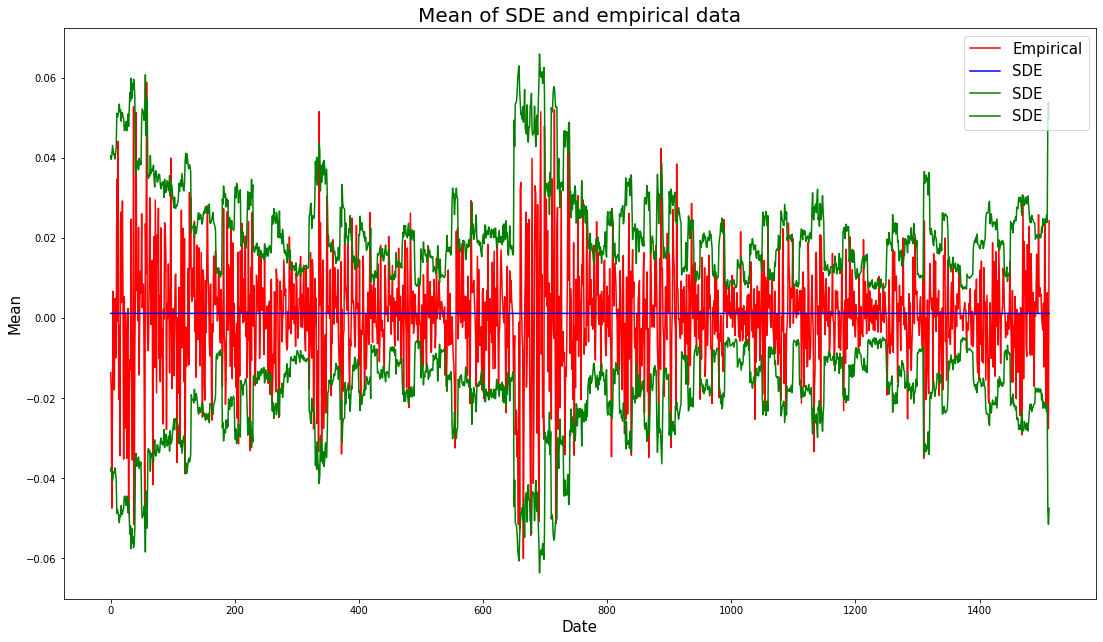

In [30]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_train_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu,color='blue',label='SDE')
plt.plot(mu+1.95*sigma,color='green',label='SDE')
plt.plot(mu-1.95*sigma,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

np.mean((y_train_reg*X1_std[0]+X1_mean[0]-mu)**2)

In [31]:
alpha_test = params['alpharnn_simp']['model'].predict(x_test_reg)
# mu_test = alpha_test[:,0]*dt
# sigma_test = np.exp(-alpha_test[:,1]/2)*np.sqrt(dt)
mu_test = alpha_test[:,0]*dt*X1_std[0]+X1_mean[0]
sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]*np.sqrt(dt)

In [32]:
mu_test1 = alpha_test[:,0]*dt
sigma_test1 = np.exp(-alpha_test[:,1]/2)*np.sqrt(dt)
RNN_simp_test = {'mu':mu_test1,'sigma':sigma_test1}
RNN_simp_test = pd.DataFrame(RNN_simp_test)
RNN_simp_test.to_csv("RNN_simp_test.csv",index=False,header=True)

0.00013743867853706555
0.010029992


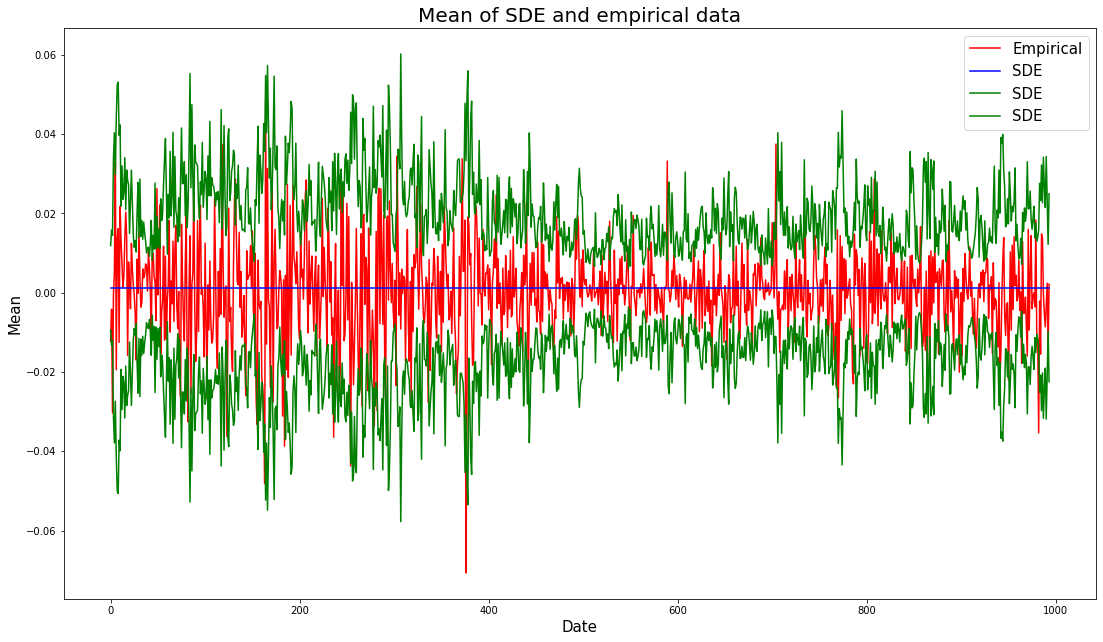

In [33]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_test,color='blue',label='SDE')
plt.plot(mu_test+1.95*sigma_test,color='green',label='SDE')
plt.plot(mu_test-1.95*sigma_test,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

print(np.mean((y_test_reg*X1_std[0]+X1_mean[0]-mu_test)**2))
print(np.mean(sigma_test))

In [ ]:
from scipy.stats import norm, binom, chi2

quantile = 0.95
refit = 252
test_num = y_test_reg.shape[0]
refit_times = test_num//refit + (test_num%refit > 0)

for key in params.keys():
  model_temp = params[key]['function'](params[key]['H'],params[key]['D'],params[key]['l1_reg'])
  rand_seed = 1000

  model_name=key
  out_dir='output/checkpoint/'

  pruning_dir = out_dir + 'pruning_summary/'
  
  mu_result = np.array([0])
  sigma_result = np.array([0])
  for k in range(refit_times):
    end = np.minimum(test_num,k*refit)
    x_train_reg_temp = np.concatenate((x_train_reg,x_test_reg[0:end,:,:]),axis=0) 
    y_train_reg_temp = np.concatenate((y_train_reg,y_test_reg[0:end]),axis=0) 
    x_test_reg_temp = x_test_reg[end:np.minimum(end+refit,test_num),:,:]
    y_test_reg_temp = y_test_reg[end:np.minimum(end+refit,test_num)]
    if k == 0:
      tag = out_dir + model_name + '_simp2_' + str(rand_seed)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'
      model_temp.load_weights(checkpoint_filepath)
    else:
      tag = out_dir + model_name + '_simp2_' + str(rand_seed)+ '_' + str(k)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'

      pruning_dir = out_dir + 'pruning_summary/'
      
      if not os.path.exists(pruning_dir):
        os.makedirs(pruning_dir)
      # train the pruned model
      tf.random.set_seed(rand_seed)
      if glob(checkpoint_filepath_all):
        model_temp.load_weights(checkpoint_filepath)
      else:
        model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
        csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
        history = model_temp.fit(x_train_reg_temp,y_train_reg_temp,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    alpha_test = model_temp.predict(x_test_reg_temp)
    mu_test = alpha_test[:,0]*dt*X1_std[0]+X1_mean[0]
    sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]*np.sqrt(dt)
    mu_result = np.concatenate((mu_result,mu_test),axis=0)
    sigma_result = np.concatenate((sigma_result,sigma_test),axis=0)

mu_result = mu_result[1:]
sigma_result = sigma_result[1:]

Epoch 1/6000
1765/1765 [==============================] - 2s 900us/step - loss: 621.0515
Epoch 2/6000
1765/1765 [==============================] - 1s 407us/step - loss: 626.0440
Epoch 3/6000
1765/1765 [==============================] - 1s 479us/step - loss: 622.9677
Epoch 4/6000
1765/1765 [==============================] - 1s 503us/step - loss: 621.3419
Epoch 5/6000
1765/1765 [==============================] - 1s 396us/step - loss: 621.0241
Epoch 6/6000
1765/1765 [==============================] - 1s 453us/step - loss: 622.1498
Epoch 7/6000
1765/1765 [==============================] - 1s 472us/step - loss: 620.1290
Epoch 8/6000
1765/1765 [==============================] - 1s 470us/step - loss: 619.7867
Epoch 9/6000
1765/1765 [==============================] - 1s 538us/step - loss: 619.3374
Epoch 10/6000
1765/1765 [==============================] - 1s 695us/step - loss: 619.1230
Epoch 11/6000
1765/1765 [==============================] - 1s 581us/step - loss: 619.0032
Epoch 12/6000
1765/

In [ ]:
quantile = 0.99
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

0.011920066813701169
3.0
20.0


In [ ]:
VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

30
0.030181086519114688


In [ ]:
import vartests as vr
vr.duration_test(avg_all, conf_level=quantile)

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


{'weibull exponential': array([0.92700338]),
 'unrestricted log-likelihood': array([-131.30997566]),
 'restricted log-likelihood': array([-131.46962487]),
 'log-likelihood': array([0.31929842]),
 'log-likelihood ratio test statistic': array([0.57202957]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [ ]:
quantile = 0.975
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)
vr.duration_test(avg_all, conf_level=quantile)

0.030234351148735183
15.0
37.0
41
0.04124748490945674
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


{'weibull exponential': array([0.87137392]),
 'unrestricted log-likelihood': array([-167.73589435]),
 'restricted log-likelihood': array([-168.4740484]),
 'log-likelihood': array([1.4763081]),
 'log-likelihood ratio test statistic': array([0.22435305]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [ ]:
quantile = 0.95
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)
vr.duration_test(avg_all, conf_level=quantile)

0.046935563329324914
37.0
65.0
60
0.060362173038229376
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


{'weibull exponential': array([0.88283275]),
 'unrestricted log-likelihood': array([-224.69416406]),
 'restricted log-likelihood': array([-225.56839999]),
 'log-likelihood': array([1.74847185]),
 'log-likelihood ratio test statistic': array([0.18606896]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [ ]:
quantile = 0.925
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)
vr.duration_test(avg_all, conf_level=quantile)

0.06520332606961299
60.0
91.0
73
0.07344064386317907
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


{'weibull exponential': array([0.98881917]),
 'unrestricted log-likelihood': array([-260.92481345]),
 'restricted log-likelihood': array([-260.93264724]),
 'log-likelihood': array([0.01566759]),
 'log-likelihood ratio test statistic': array([0.90038877]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [ ]:
quantile = 0.9
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)
vr.duration_test(avg_all, conf_level=quantile)

0.09265017082917193
84.0
116.0
90
0.09054325955734406
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


{'weibull exponential': array([1.0338119]),
 'unrestricted log-likelihood': array([-303.59343813]),
 'restricted log-likelihood': array([-303.67639219]),
 'log-likelihood': array([0.16590812]),
 'log-likelihood ratio test statistic': array([0.68377429]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

## alpha-RNN with factors:

In [34]:
def AlphaRNN_(n_units = 10, d_units=16,l1_reg=0, seed=0,dt=dt):
  inputs = Input(shape=(x_train_reg.shape[1],x_train_reg.shape[2]))
  in1 = Lambda(lambda x: tf.slice(x,[0,0,0],[-1,-1,x_train_reg1.shape[2]]))(inputs)
  in2 = Lambda(lambda x: tf.slice(x,[0,0,x_train_reg1.shape[2]],[-1,-1,-1]))(inputs)
  x1 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg1.shape[1], x_train_reg1.shape[-1]), unroll=True)(in1)
  x2 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg2.shape[1], x_train_reg2.shape[-1]), unroll=True)(in2)
  x1 = Dense(d_units,activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  x2 = Dense(d_units,activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out1 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  out2 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out =  Lambda(lambda x :K.concatenate(x,1))([out1,out2])
  Mymodel = Model(inputs=inputs,outputs=out)

  Mymodel.compile(loss=Loss.loss_lnS, optimizer='adam')
  return Mymodel

In [35]:
max_epoches=6000
batch_size=10
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=0.01, restore_best_weights=True)
params = {'alpharnn': {'model':'', 'function':AlphaRNN_,'l1_reg':0.0, 'D':16,'H':10,'D':16,'color': 'green', 'label': '$\\alpha$-RNN' }}

In [36]:
x_train_reg = x_train_reg.astype('float32')
y_train_reg = y_train_reg.astype('float32')

In [106]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [3,5,10]
    l1_reg = [0.1]
    d_units = [4,16,32]

    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,d_units=d_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scorer,error_score="raise",cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']
        params[key]['D']= grid_result.best_params_['d_units']

        joblib.dump(grid, key + 'grid10.pkl')

Streaming output truncated to the last 5000 lines.
Epoch 36/6000
 - 0s - loss: 731.1222
Epoch 37/6000
 - 0s - loss: 723.2824
Epoch 38/6000
 - 0s - loss: 719.6039
Epoch 39/6000
 - 0s - loss: 713.4451
Epoch 40/6000
 - 0s - loss: 710.9059
Epoch 41/6000
 - 0s - loss: 706.5841
Epoch 42/6000
 - 0s - loss: 708.0893
Epoch 43/6000
 - 0s - loss: 701.9071
Epoch 44/6000
 - 0s - loss: 700.8590
Epoch 45/6000
 - 0s - loss: 697.2555
Epoch 46/6000
 - 0s - loss: 697.0106
Epoch 47/6000
 - 0s - loss: 695.8630
Epoch 48/6000
 - 0s - loss: 694.3428
Epoch 49/6000
 - 0s - loss: 694.5241
Epoch 50/6000
 - 0s - loss: 691.1485
Epoch 51/6000
 - 0s - loss: 690.5534
Epoch 52/6000
 - 0s - loss: 688.7595
Epoch 53/6000
 - 0s - loss: 689.3755
Epoch 54/6000
 - 0s - loss: 688.3031
Epoch 55/6000
 - 0s - loss: 684.8571
Epoch 56/6000
 - 0s - loss: 684.2633
Epoch 57/6000
 - 0s - loss: 683.4512
Epoch 58/6000
 - 0s - loss: 685.3086
Epoch 59/6000
 - 0s - loss: 684.3391
Epoch 60/6000
 - 0s - loss: 684.5003
Epoch 61/6000
 - 0s - lo

In [ ]:
# Best: -1607.432910 using {'d_units': 16, 'l1_reg': 0.1, 'n_units': 5}
# -1730.058716 (223.486201) with {'d_units': 4, 'l1_reg': 0, 'n_units': 5}
# -5823.594238 (8513.348547) with {'d_units': 4, 'l1_reg': 0, 'n_units': 10}
# -1628.334863 (110.766885) with {'d_units': 4, 'l1_reg': 0, 'n_units': 20}
# -2356.832275 (1553.559317) with {'d_units': 4, 'l1_reg': 0, 'n_units': 50}
# -13201.610010 (23262.774670) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 5}
# -1616.404639 (99.851008) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 10}
# -1703.728369 (178.961242) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 20}
# -1627.911963 (99.872920) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 50}
# -3721.120117 (4296.493639) with {'d_units': 16, 'l1_reg': 0, 'n_units': 5}
# -1710.039673 (319.501502) with {'d_units': 16, 'l1_reg': 0, 'n_units': 10}
# -1662.835522 (202.056786) with {'d_units': 16, 'l1_reg': 0, 'n_units': 20}
# -1672.439282 (221.323047) with {'d_units': 16, 'l1_reg': 0, 'n_units': 50}
# -1607.432910 (120.115155) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 5}
# -1627.019116 (100.470000) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 10}
# -1616.107300 (106.634105) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 20}
# -1630.561768 (89.524368) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 50}
# -1675.749829 (243.935083) with {'d_units': 64, 'l1_reg': 0, 'n_units': 5}
# -1642.720752 (151.553089) with {'d_units': 64, 'l1_reg': 0, 'n_units': 10}
# -1651.909473 (216.292668) with {'d_units': 64, 'l1_reg': 0, 'n_units': 20}
# -2129.857129 (1121.077740) with {'d_units': 64, 'l1_reg': 0, 'n_units': 50}
# -1615.739868 (112.931432) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 5}
# -1694.650854 (147.358868) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 10}
# -1625.266724 (123.964589) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 20}
# -1632.622656 (86.317704) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 50}

# Best: -1617.734595 using {'l1_reg': 0, 'n_units': 20}
# -1629.121436 (102.117782) with {'l1_reg': 0, 'n_units': 10}
# -1617.734595 (96.265442) with {'l1_reg': 0, 'n_units': 20}
# -1637.180908 (82.392636) with {'l1_reg': 0, 'n_units': 50}
# -1626.717871 (97.934338) with {'l1_reg': 0.001, 'n_units': 10}
# -1640.471338 (103.360591) with {'l1_reg': 0.001, 'n_units': 20}
# -1635.391699 (82.847721) with {'l1_reg': 0.001, 'n_units': 50}
# -1627.713013 (92.470055) with {'l1_reg': 0.01, 'n_units': 10}
# -1628.233350 (97.112601) with {'l1_reg': 0.01, 'n_units': 20}
# -1631.966382 (91.116517) with {'l1_reg': 0.01, 'n_units': 50}

In [ ]:
#load your model for further usage
# joblib.load("model_file_name.pkl")

params

{'alpharnn': {'model': '',
  'function': <function __main__.AlphaRNN_(n_units=10, l1_reg=0, seed=0, dt=0.0027397260273972603)>,
  'l1_reg': 0.01,
  'H': 10,
  'color': 'green',
  'label': '$\\alpha$-RNN'}}

In [37]:
params['alpharnn']['l1_reg'] = 0.1
params['alpharnn']['H'] = 5
params['alpharnn']['D'] = 16

In [38]:
# norm_new4: l1_reg': 0.01, n = 10
# norm_new1: l1_reg': 0, n = 20
# norm_new2: l1_reg': 0, n = 10, D = 64
# norm_new3: l1_reg': 0, n = 5, D = 64
# norm_new5: l1_reg': 0.1, n = 20
# norm_new6: l1_reg: 0.1, n = 5, D = 16 (0,10,100,1000)

from keras.callbacks.callbacks import ModelCheckpoint, CSVLogger

for key in params.keys():
  rand_seed = 1000
  tf.compat.v1.set_random_seed(rand_seed)
  model=params[key]['function'](params[key]['H'],params[key]['D'],params[key]['l1_reg'])

  model_name=key
  out_dir='output/checkpoint/'

  tag = out_dir + model_name + '_norm_new6_' + str(rand_seed)
  checkpoint_filepath = tag
  checkpoint_filepath_all = tag + '*'
  csv_fname = tag + '_history.csv'

  pruning_dir = out_dir + 'pruning_summary/'
  if not os.path.exists(pruning_dir):
    os.makedirs(pruning_dir)

  # train the pruned model
  tf.random.set_seed(rand_seed)
  if glob(checkpoint_filepath_all):
    model.load_weights(checkpoint_filepath)
  else:
    model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
    csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
    
    history = model.fit(x_train_reg,y_train_reg,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    # plot training loss history
    plot_fname = tag + '_history.png'
    hist = pd.DataFrame(history.history)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()

    plt.savefig(plot_fname, dpi=500)
    plt.close()
  params[key]['model']=model


<Figure size 648x180 with 0 Axes>

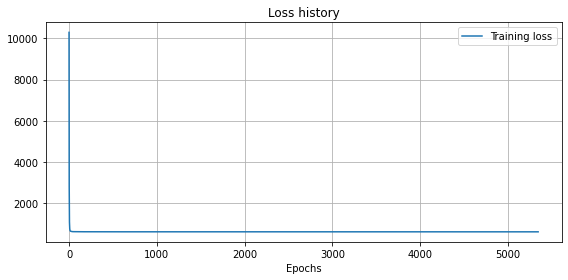

In [39]:
rand_seed = 1000
fig = plt.figure(figsize=(9, 2.5))
for key in params.keys():
    model_name=key
    out_dir='output/checkpoint/'
    tag = out_dir + model_name + '_norm_new6_' + str(rand_seed)
    csv_fname = tag + '_history.csv'
    df_hist = pd.read_csv(csv_fname, index_col=0)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.set_title(fr'Loss history')
    ax.plot(df_hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()


In [ ]:
# for key in params.keys():
#   params[key]['model'].save(key + 'n6norm.hdf5', overwrite=True)  # creates a HDF5 file
# for key in params.keys():
#   params[key]['model']=load_model(key + '.hdf5')

In [40]:
alpha = params['alpharnn']['model'].predict(x_train_reg)
# mu = alpha[:,0]*dt
# sigma = np.exp(-alpha[:,1]/2)*np.sqrt(dt)
mu = alpha[:,0]*dt*X1_std[0]+X1_mean[0]
sigma = np.exp(-alpha[:,1]/2)*X1_std[0]*np.sqrt(dt)

In [41]:
mu1 = alpha[:,0]*dt
sigma1 = np.exp(-alpha[:,1]/2)*np.sqrt(dt)
RNN = {'mu':mu1,'sigma':sigma1}
RNN = pd.DataFrame(RNN)
RNN.to_csv("RNN3.csv",index=False,header=True)

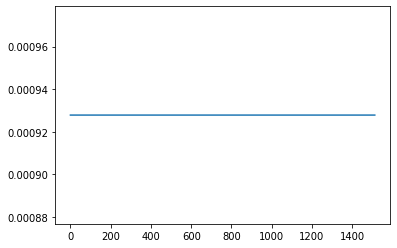

In [42]:
plt.plot(mu)

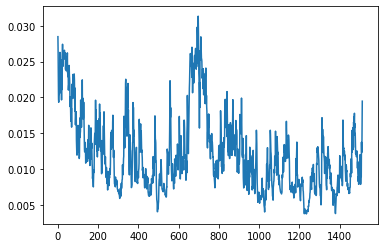

In [43]:
plt.plot(sigma)

0.00018527737

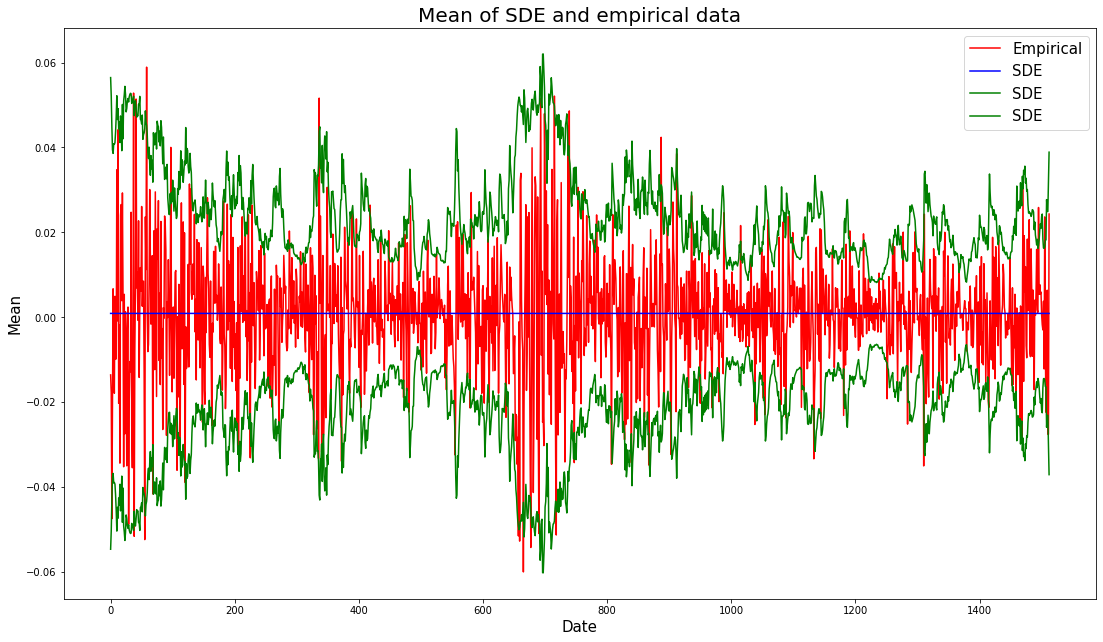

In [44]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_train_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu,color='blue',label='SDE')
plt.plot(mu+1.95*sigma,color='green',label='SDE')
plt.plot(mu-1.95*sigma,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

np.mean((y_train_reg*X1_std[0]+X1_mean[0]-mu)**2)

In [32]:
res = y_train_reg*X1_std[0]+X1_mean[0]-mu

adf, p, usedlag, nobs, cvs,aic = sm.tsa.stattools.adfuller(res)
print(adf,p)

adf2, p2, usedlag2, nobs2, cvs2,aic2 = sm.tsa.stattools.adfuller(res**2)
print(adf2,p2)

-27.731926751671047 0.0
-3.7079679289334817 0.0040024638119895125


In [45]:
alpha_test = params['alpharnn']['model'].predict(x_test_reg)
# mu_test = alpha_test[:,0]*dt
# sigma_test = np.exp(-alpha_test[:,1]/2)*np.sqrt(dt)
mu_test = alpha_test[:,0]*dt*X1_std[0]+X1_mean[0]
sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]*np.sqrt(dt)

In [46]:
mu_test1 = alpha_test[:,0]*dt
sigma_test1 = np.exp(-alpha_test[:,1]/2)*np.sqrt(dt)
RNN_test = {'mu':mu_test1,'sigma':sigma_test1}
RNN_test = pd.DataFrame(RNN_test)
RNN_test.to_csv("RNN_test3.csv",index=False,header=True)

0.00013686483952286523
0.010855763


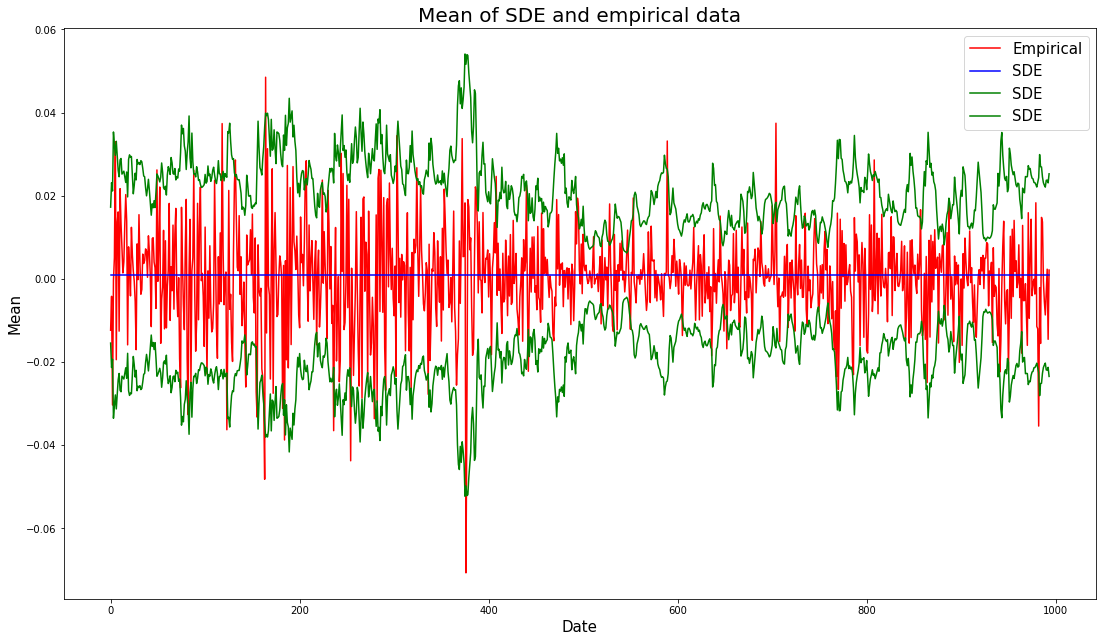

In [47]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_test,color='blue',label='SDE')
plt.plot(mu_test+1.95*sigma_test,color='green',label='SDE')
plt.plot(mu_test-1.95*sigma_test,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

print(np.mean((y_test_reg*X1_std[0]+X1_mean[0]-mu_test)**2))
print(np.mean(sigma_test))

In [36]:
from scipy.stats import norm, binom, chi2

quantile = 0.95
refit = 252
test_num = y_test_reg.shape[0]
refit_times = test_num//refit + (test_num%refit > 0)

for key in params.keys():
  model_temp = AlphaRNN_(params[key]['H'],params[key]['D'],params[key]['l1_reg'])
  rand_seed = 1000

  model_name=key
  out_dir='output/checkpoint/'

  pruning_dir = out_dir + 'pruning_summary/'
  
  mu_result = np.array([0])
  sigma_result = np.array([0])
  for k in range(refit_times):
    end = np.minimum(test_num,k*refit)
    x_train_reg_temp = np.concatenate((x_train_reg,x_test_reg[0:end,:,:]),axis=0) 
    y_train_reg_temp = np.concatenate((y_train_reg,y_test_reg[0:end]),axis=0) 
    x_test_reg_temp = x_test_reg[end:np.minimum(end+refit,test_num),:,:]
    y_test_reg_temp = y_test_reg[end:np.minimum(end+refit,test_num)]
    if k == 0:
      tag = out_dir + model_name + '_norm_new6_' + str(rand_seed)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'
      model_temp.load_weights(checkpoint_filepath)
    else:
      tag = out_dir + model_name + '_norm_new6_' + str(rand_seed)+ '_' + str(k)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'

      pruning_dir = out_dir + 'pruning_summary/'
      
      if not os.path.exists(pruning_dir):
        os.makedirs(pruning_dir)
      # train the pruned model
      tf.random.set_seed(rand_seed)
      if glob(checkpoint_filepath_all):
        model_temp.load_weights(checkpoint_filepath)
      else:
        model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
        csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
        history = model_temp.fit(x_train_reg_temp,y_train_reg_temp,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    alpha_test = model_temp.predict(x_test_reg_temp)
    mu_test = alpha_test[:,0]*dt*X1_std[0]+X1_mean[0]
    sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]*np.sqrt(dt)
    mu_result = np.concatenate((mu_result,mu_test),axis=0)
    sigma_result = np.concatenate((sigma_result,sigma_test),axis=0)


mu_result = mu_result[1:]
sigma_result = sigma_result[1:]


  

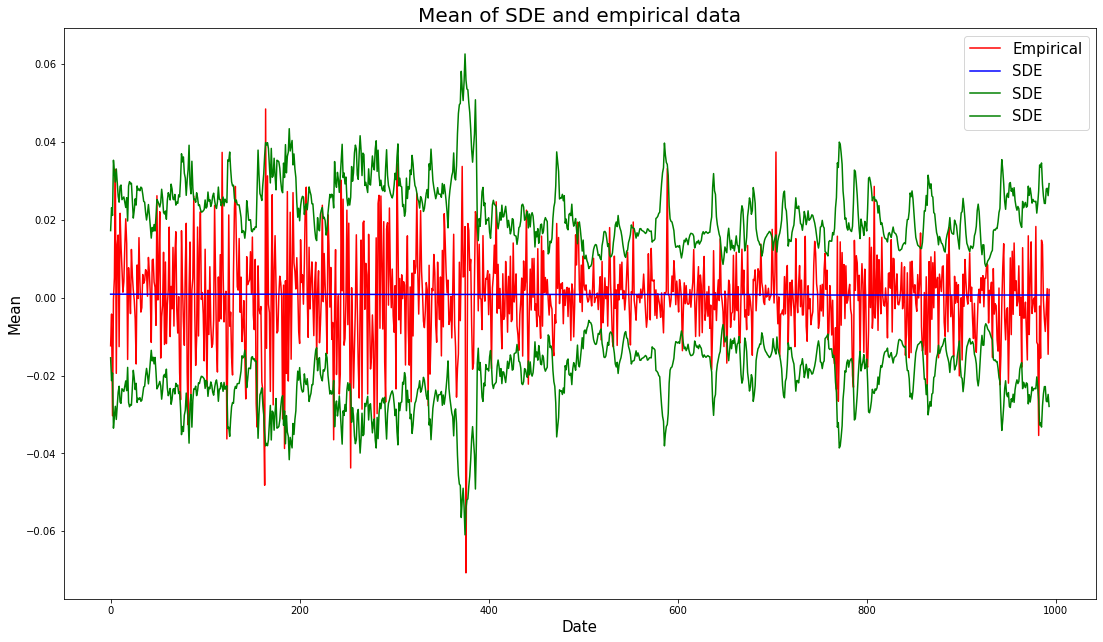

In [37]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_result,color='blue',label='SDE')
plt.plot(mu_result+1.95*sigma_result,color='green',label='SDE')
plt.plot(mu_result-1.95*sigma_result,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

In [38]:
quantile = 0.9
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

0.09265017082917193
84.0
116.0


In [39]:
VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

94
0.09456740442655935


In [40]:
quantile = 0.925
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

0.06520332606961299
60.0
91.0
73
0.07344064386317907


In [41]:
quantile = 0.95
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

0.046935563329324914
37.0
65.0
58
0.05835010060362173


In [42]:
quantile = 0.975
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

0.030234351148735183
15.0
37.0
27
0.02716297786720322


In [43]:
quantile = 0.99
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

0.011920066813701169
3.0
20.0
17
0.01710261569416499


In [53]:
import vartests as vr

vr.duration_test(avg_all, conf_level=quantile)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


{'weibull exponential': array([1.02053797]),
 'unrestricted log-likelihood': array([-313.20109255]),
 'restricted log-likelihood': array([-313.23619889]),
 'log-likelihood': array([0.07021268]),
 'log-likelihood ratio test statistic': array([0.79102736]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [19]:
def AlphaRNN_std_(n_units = 10,dense_units = 64, l1_reg=0, seed=0,dt=dt):
  inputs = Input(shape=(x_train_reg.shape[1],x_train_reg.shape[2]))
  in1 = Lambda(lambda x: tf.slice(x,[0,0,0],[-1,-1,x_train_reg1.shape[2]]))(inputs)
  in2 = Lambda(lambda x: tf.slice(x,[0,0,x_train_reg1.shape[2]],[-1,-1,-1]))(inputs)
  x1 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg1.shape[1], x_train_reg1.shape[-1]), unroll=True)(in1)
  x2 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg2.shape[1], x_train_reg2.shape[-1]), unroll=True)(in2)
  x1 = Dense(dense_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  x3 = Dense(dense_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  x2 = Dense(dense_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out1 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  out2 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out3 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x3)
  out =  Lambda(lambda x :K.concatenate(x,1))([out1,out2,out3])
  Mymodel = Model(inputs=inputs,outputs=out)

  Mymodel.compile(loss=Loss.loss_lnS_std, optimizer='adam')
  return Mymodel

In [20]:
def custom_loss_function_std(y_true, y_pred):
    alpha = y_pred[:,0].astype('float32')
    gamma = y_pred[:,1].astype('float32')

    nu = np.mean((y_pred[:,2])**2)
           
    # compute log-likelihood
    
    score = -np.sum(-gamma + (nu+1)/2*np.log(1+np.square(y_true - alpha)*np.exp(gamma)/nu) +2*tf.math.lgamma(nu/2)-2*tf.math.lgamma((nu+1)/2)+np.log(nu))

    return score

scorer_std = make_scorer(custom_loss_function_std, greater_is_better=True)

In [21]:
max_epoches = 6000
batch_size = 10
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=0.1, restore_best_weights=True)
params = {'alpharnn_std': {'model':'', 'function':AlphaRNN_std_,'l1_reg':0.0, 'H':10, 'D':64,'color': 'green', 'label': '$\\alpha$-RNN_std' }}

In [142]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [10,20,50,100]
    l1_reg = [0.01,0.1]
    dense_units = [4,16,64]

    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,dense_units=dense_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scorer_std,error_score="raise",cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']
        params[key]['D']= grid_result.best_params_['dense_units']
        

        joblib.dump(grid, key + 'grid_std2.pkl')

Streaming output truncated to the last 5000 lines.
Epoch 249/6000
 - 0s - loss: 193.3404
Epoch 250/6000
 - 0s - loss: 193.7392
Epoch 251/6000
 - 0s - loss: 193.6437
Epoch 252/6000
 - 0s - loss: 193.1081
Epoch 253/6000
 - 0s - loss: 193.4871
Epoch 254/6000
 - 0s - loss: 194.9053
Epoch 255/6000
 - 0s - loss: 193.7214
Epoch 256/6000
 - 0s - loss: 193.5823
Epoch 257/6000
 - 0s - loss: 193.1887
Epoch 258/6000
 - 0s - loss: 193.6943
Epoch 259/6000
 - 0s - loss: 194.7049
Epoch 260/6000
 - 0s - loss: 192.8848
Epoch 261/6000
 - 0s - loss: 193.7637
Epoch 262/6000
 - 0s - loss: 194.0841
Epoch 263/6000
 - 0s - loss: 193.4933
Epoch 264/6000
 - 0s - loss: 193.4979
Epoch 265/6000
 - 0s - loss: 193.5505
Epoch 266/6000
 - 0s - loss: 192.5723
Epoch 267/6000
 - 0s - loss: 193.2069
Epoch 268/6000
 - 0s - loss: 193.1186
Epoch 269/6000
 - 0s - loss: 192.4824
Epoch 270/6000
 - 0s - loss: 193.9457
Epoch 271/6000
 - 0s - loss: 193.5048
Epoch 272/6000
 - 0s - loss: 193.7435
Epoch 273/6000
 - 0s - loss: 193.1336

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Restoring model weights from the end of the best epoch
Epoch 00233: early stopping
Best: -233.446281 using {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 100}
-244.080534 (68.475320) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 10}
-240.959884 (68.919884) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 20}
-239.659239 (65.519455) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 50}
-237.167935 (68.750457) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 100}
-242.141347 (68.633505) with {'dense_units': 4, 'l1_reg': 0.1, 'n_units': 10}
-244.108267 (65.694892) with {'dense_units': 4, 'l1_reg': 0.1, 'n_units': 20}
-239.513256 (70.417834) with {'dense_units': 4, 'l1_reg': 0.1, 'n_units': 50}
-246.141416 (64.538027) with {'dense_units': 4, 'l1_reg': 0.1, 'n_units': 100}
-241.301726 (69.957344) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 10}
-237.984341 (68.166528) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 20}
-235.156976 (68.026296) with {'dense_units': 16, 'l

OSError: ignored

In [ ]:
# Best: -245.483013 using {'dense_units': 64, 'l1_reg': 0.1, 'n_units': 100}
# -247.576663 (75.600656) with {'dense_units': 64, 'l1_reg': 0.1, 'n_units': 50}
# -245.483013 (64.850662) with {'dense_units': 64, 'l1_reg': 0.1, 'n_units': 100}
# -246.228410 (66.843835) with {'dense_units': 128, 'l1_reg': 0.1, 'n_units': 50}
# -249.032820 (61.360007) with {'dense_units': 128, 'l1_reg': 0.1, 'n_units': 100}


# Best: -250.177062 using {'dense_units': 64, 'l1_reg': 0.1, 'n_units': 50}
# -699.552326 (949.707531) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 10}
# -253.714663 (59.825949) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 20}
# -269.621350 (93.482577) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 50}
# -719.240898 (587.256916) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 10}
# -258.682899 (83.363987) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 20}
# -254.930407 (77.177170) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 50}
# -473.978394 (494.561396) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 10}
# -545.786394 (582.248990) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 20}
# -273.590998 (109.264143) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 50}
# -652.215572 (845.567517) with {'dense_units': 4, 'l1_reg': 0.1, 'n_units': 10}
# -546.850186 (571.004593) with {'dense_units': 4, 'l1_reg': 0.1, 'n_units': 20}
# -265.175797 (94.174601) with {'dense_units': 4, 'l1_reg': 0.1, 'n_units': 50}
# -1293.266828 (1271.848852) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 10}
# -274.997319 (86.737214) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 20}
# -259.467408 (75.078485) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 50}
# -317.856793 (189.251631) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 10}
# -268.417366 (81.455114) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 20}
# -262.926714 (92.033101) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 50}
# -270.198883 (96.802400) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 10}
# -411.352765 (339.576313) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 20}
# -338.953342 (219.695574) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 50}
# -477.350184 (435.968985) with {'dense_units': 16, 'l1_reg': 0.1, 'n_units': 10}
# -316.296558 (187.864944) with {'dense_units': 16, 'l1_reg': 0.1, 'n_units': 20}
# -254.942826 (75.532126) with {'dense_units': 16, 'l1_reg': 0.1, 'n_units': 50}
# -269.276728 (76.827068) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 10}
# -333.955101 (196.121833) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 20}
# -537.077129 (616.493863) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 50}
# -524.038336 (466.500692) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 10}
# -837.194393 (1200.607811) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 20}
# -359.144197 (280.233574) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 50}
# -632.794363 (788.564533) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 10}
# -555.266443 (494.302651) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 20}
# -318.697279 (197.645711) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 50}
# -250.308315 (71.594153) with {'dense_units': 64, 'l1_reg': 0.1, 'n_units': 10}
# -540.199805 (611.100387) with {'dense_units': 64, 'l1_reg': 0.1, 'n_units': 20}
# -250.177062 (80.055188) with {'dense_units': 64, 'l1_reg': 0.1, 'n_units': 50}

In [ ]:
#load your model for further usage
# joblib.load("model_file_name.pkl")

params

In [45]:
# std3: l1_reg = 0.1, H: 50, D: 64 
# std4: l1_reg = 0.1, H: 100, D: 64
# std6: l1_reg = 0.1, H: 50, D: 16

# std7: l1_reg = 0.1, H: 100, D: 64 (mean)
# std9: l1_reg = 0.01, H: 100, D: 16 (mean)
params['alpharnn_std']['l1_reg'] = 0.01
params['alpharnn_std']['H'] = 100
params['alpharnn_std']['D'] = 16

In [46]:
from keras.callbacks.callbacks import ModelCheckpoint, CSVLogger

for key in params.keys():
  rand_seed = 0
  tf.compat.v1.set_random_seed(rand_seed)
  model=params[key]['function'](params[key]['H'],params[key]['D'],params[key]['l1_reg'])

  model_name=key
  out_dir='output/checkpoint/'

  tag = out_dir + model_name + '_std9_' + str(rand_seed)
  checkpoint_filepath = tag
  checkpoint_filepath_all = tag + '*'
  csv_fname = tag + '_history.csv'

  pruning_dir = out_dir + 'pruning_summary/'
  if not os.path.exists(pruning_dir):
    os.makedirs(pruning_dir)

  # train the pruned model
  tf.random.set_seed(rand_seed)
  if glob(checkpoint_filepath_all):
    model.load_weights(checkpoint_filepath)
  else:
    model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
    csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
    
    history = model.fit(x_train_reg,y_train_reg,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    # plot training loss history
    plot_fname = tag + '_history.png'
    hist = pd.DataFrame(history.history)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()

    plt.savefig(plot_fname, dpi=500)
    plt.close()
  params[key]['model']=model


Epoch 1/6000
1513/1513 [==============================] - 5s 3ms/step - loss: 173.2106
Epoch 2/6000
1513/1513 [==============================] - 1s 728us/step - loss: 156.2924
Epoch 3/6000
1513/1513 [==============================] - 1s 656us/step - loss: 154.5787
Epoch 4/6000
1513/1513 [==============================] - 1s 703us/step - loss: 152.4862
Epoch 5/6000
1513/1513 [==============================] - 1s 652us/step - loss: 149.8212
Epoch 6/6000
1513/1513 [==============================] - 1s 701us/step - loss: 149.2269
Epoch 7/6000
1513/1513 [==============================] - 1s 629us/step - loss: 148.7449
Epoch 8/6000
1513/1513 [==============================] - 1s 622us/step - loss: 148.2783
Epoch 9/6000
1513/1513 [==============================] - 1s 706us/step - loss: 147.3636
Epoch 10/6000
1513/1513 [==============================] - 1s 667us/step - loss: 146.8524
Epoch 11/6000
1513/1513 [==============================] - 1s 607us/step - loss: 146.4845
Epoch 12/6000
1513/15

<Figure size 648x180 with 0 Axes>

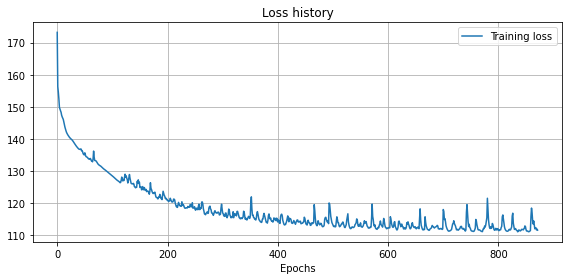

In [47]:
rand_seed = 0
fig = plt.figure(figsize=(9, 2.5))
for key in params.keys():
    model_name=key
    out_dir='output/checkpoint/'
    tag = out_dir + model_name + '_std9_' + str(rand_seed)
    csv_fname = tag + '_history.csv'
    df_hist = pd.read_csv(csv_fname, index_col=0)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.set_title(fr'Loss history')
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()


In [ ]:
# for key in params.keys():
#   params[key]['model'].save(key + 'std.hdf5', overwrite=True)  # creates a HDF5 file
# for key in params.keys():
#   params[key]['model']=load_model(key + 'std.hdf5')

In [48]:
import scipy.stats

alpha = params['alpharnn_std']['model'].predict(x_train_reg)
mu = alpha[:,0]*X1_std[0]+X1_mean[0]
sigma = np.exp(-alpha[:,1]/2)*X1_std[0]
nu = np.mean((alpha[:,2])**2)
print(nu)
ci = scipy.stats.t.ppf(q=0.95,df=nu)
print(ci)

86.62813
1.66263416875351


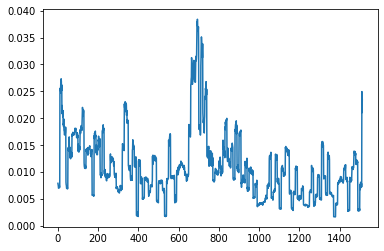

In [49]:
plt.plot(sigma)

In [50]:
print(alpha[alpha.shape[0]-1,0])
print(np.exp(-alpha[alpha.shape[0]-1,1]/2))

-0.5270053
1.719900274600997


In [51]:
alpha[:,2]**2

array([ 6.6510086,  0.8208973,  1.018622 , ..., 43.954487 , 11.691866 ,
       17.144463 ], dtype=float32)

In [52]:
from scipy.stats import norm, binom, chi2, t

lower = t.ppf(0.025,loc=alpha[:,0],scale=np.exp(-alpha[:,1]/2),df=nu)*X1_std[0]+X1_mean[0]
upper = t.ppf(0.975,loc=alpha[:,0],scale=np.exp(-alpha[:,1]/2),df=nu)*X1_std[0]+X1_mean[0]

In [ ]:
upper

array([0.00245517, 0.00244875, 0.00245646, ..., 0.00234034, 0.00231074,
       0.0022585 ])

0.00016510685520091645

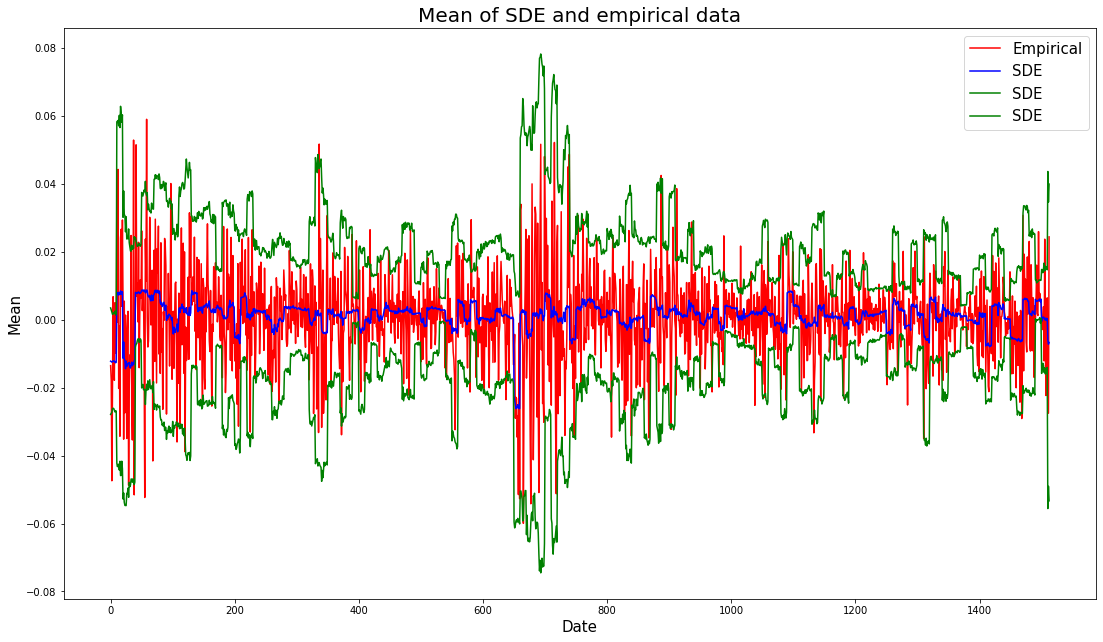

In [53]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_train_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu,color='blue',label='SDE')
plt.plot(lower,color='green',label='SDE')
plt.plot(upper,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

np.mean((y_train_reg*X1_std[0]+X1_mean[0]-mu)**2)

In [54]:
res = y_train_reg*X1_std[0]+X1_mean[0]-mu

adf, p, usedlag, nobs, cvs,aic = sm.tsa.stattools.adfuller(res)
print(adf,p)

adf2, p2, usedlag2, nobs2, cvs2,aic2 = sm.tsa.stattools.adfuller(res**2)
print(adf2,p2)

-11.060223259604667 4.83034699198174e-20
-3.3943390732350633 0.011153372653858663


In [55]:
mu

array([-0.01224162, -0.01235686, -0.01252385, ..., -0.00601584,
       -0.00724365, -0.00673232], dtype=float32)

In [56]:
sigma

array([0.00788181, 0.00764424, 0.00741444, ..., 0.02494599, 0.021035  ,
       0.02344307], dtype=float32)

In [62]:
alpha_test = params['alpharnn_std']['model'].predict(x_test_reg)
# mu_test = alpha_test[:,0]*dt
# sigma_test = np.exp(-alpha_test[:,1]/2)*np.sqrt(dt)
mu_test = alpha_test[:,0]*X1_std[0]+X1_mean[0]
sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]
nu_test = np.mean((alpha_test[:,2])**2)
print(nu_test)
ci_test = scipy.stats.t.ppf(q=0.95,df=nu_test)
print(ci_test)

lower_test = t.ppf(0.025,loc=alpha_test[:,0],scale=np.exp(-alpha_test[:,1]/2),df=nu)*X1_std[0]+X1_mean[0]
upper_test = t.ppf(0.975,loc=alpha_test[:,0],scale=np.exp(-alpha_test[:,1]/2),df=nu)*X1_std[0]+X1_mean[0]

81.62924
1.6637355330686319


0.00014550291949422427
0.010089019


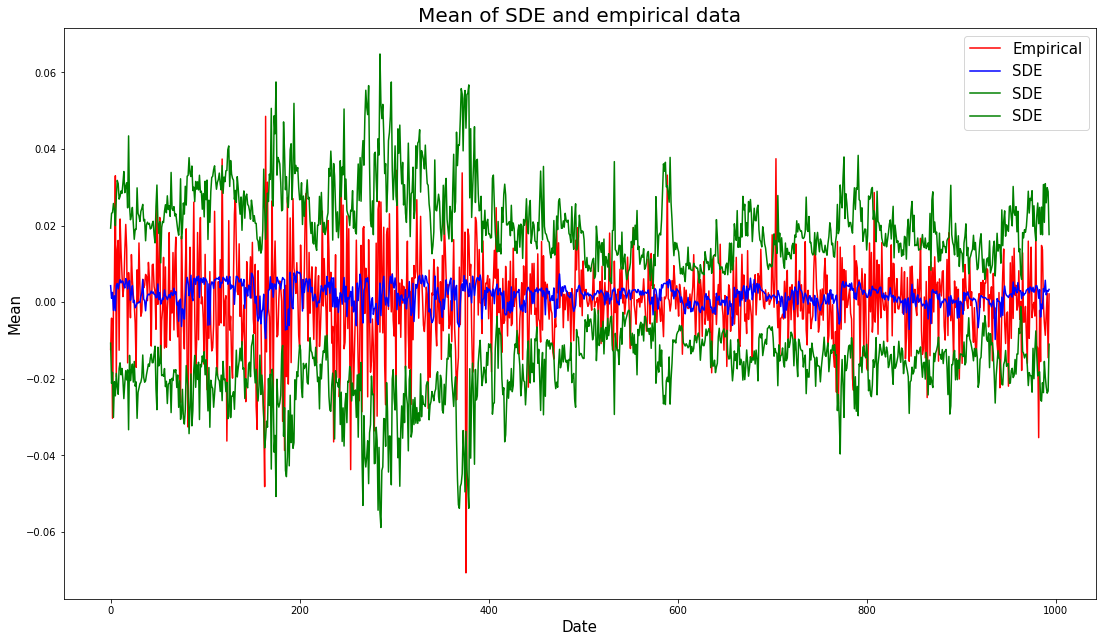

In [63]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_test,color='blue',label='SDE')
plt.plot(lower_test,color='green',label='SDE')
plt.plot(upper_test,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

print(np.mean((y_test_reg*X1_std[0]+X1_mean[0]-mu_test)**2))
print(np.mean(sigma_test))

In [67]:
from scipy.stats import norm, binom, chi2, t

quantile = 0.95
refit = 253
test_num = y_test_reg.shape[0]
refit_times = test_num//refit + (test_num%refit > 0)

for key in params.keys():
  model_temp = AlphaRNN_std_(params[key]['H'],params[key]['D'],params[key]['l1_reg'])
  rand_seed = 0

  model_name=key
  out_dir='output/checkpoint/'

  pruning_dir = out_dir + 'pruning_summary/'
  
  mu_result = np.array([0])
  sigma_result = np.array([0])
  nu_result = np.array([0])
  for k in range(refit_times):
    end = np.minimum(test_num,k*refit)
    x_train_reg_temp = np.concatenate((x_train_reg,x_test_reg[0:end,:,:]),axis=0) 
    y_train_reg_temp = np.concatenate((y_train_reg,y_test_reg[0:end]),axis=0) 
    x_test_reg_temp = x_test_reg[end:np.minimum(end+refit,test_num),:,:]
    y_test_reg_temp = y_test_reg[end:np.minimum(end+refit,test_num)]
    if k == 0:
      tag = out_dir + model_name + '_std9_' + str(rand_seed)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'
      model_temp.load_weights(checkpoint_filepath)
    else:
      tag = out_dir + model_name + '_std9_' + str(rand_seed)+ '_' + str(k)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'

      pruning_dir = out_dir + 'pruning_summary/'
      
      if not os.path.exists(pruning_dir):
        os.makedirs(pruning_dir)
      # train the pruned model
      tf.random.set_seed(rand_seed)
      if glob(checkpoint_filepath_all):
        model_temp.load_weights(checkpoint_filepath)
      else:
        model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
        csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
        history = model_temp.fit(x_train_reg_temp,y_train_reg_temp,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    alpha_train = model_temp.predict(x_train_reg_temp)
    alpha_test = model_temp.predict(x_test_reg_temp)
    mu_test = alpha_test[:,0]*X1_std[0]+X1_mean[0]
    sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]
    nu_test = np.mean((alpha_train[:,2])**2)*np.ones(mu_test.shape)
    mu_result = np.concatenate((mu_result,mu_test),axis=0)
    sigma_result = np.concatenate((sigma_result,sigma_test),axis=0)
    nu_result = np.concatenate((nu_result,nu_test),axis=0)

mu_result = mu_result[1:]
sigma_result = sigma_result[1:]
nu_result = nu_result[1:]



In [70]:
quantile = 0.99

lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(lower_bd)
print(upper_bd)
print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))

VaR_all = t.ppf(quantile,loc=mu_result,scale=sigma_result,df=nu_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

3.0
20.0
0.011920066813701169
47
0.047283702213279676


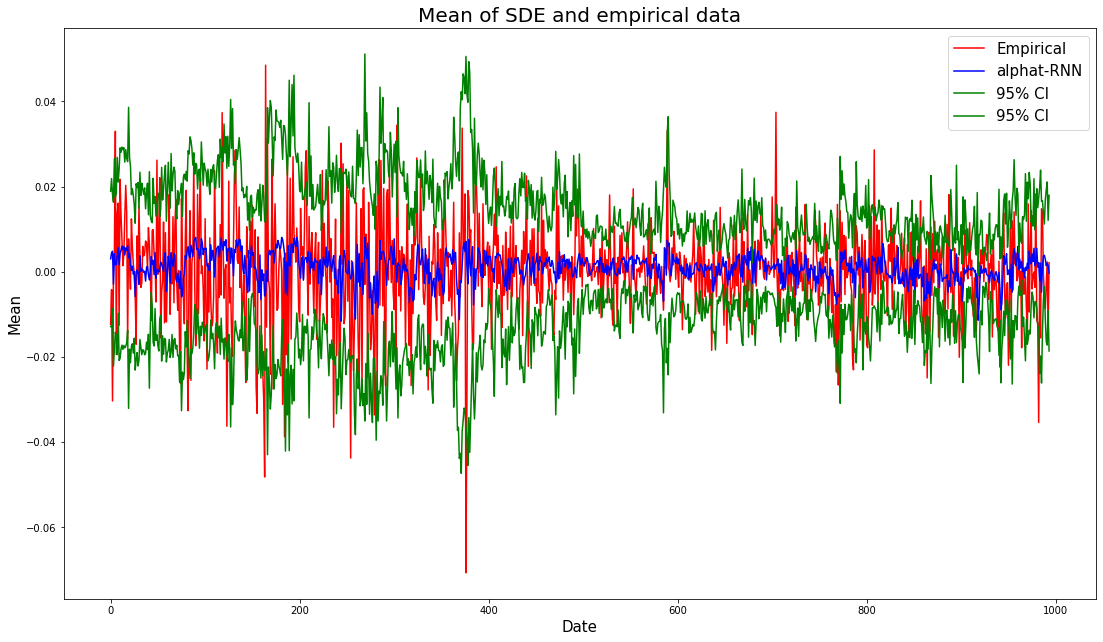

In [44]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_result,color='blue',label='alphat-RNN')
plt.plot(mu_result+scipy.stats.t.ppf(q=0.95,df=nu_result)*sigma_result,color='green',label='95% CI')
plt.plot(mu_result-scipy.stats.t.ppf(q=0.95,df=nu_result)*sigma_result,color='green',label='95% CI')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

In [ ]:
import vartests as vr

vr.duration_test(avg_all, conf_level=0.95)

In [ ]:
# Separate model
x_train_reg1 = x_train_reg[:,:,0:4]
x_train_reg2 = x_train_reg[:,:,-6:]

In [ ]:
def AlphaRNN_mu_(n_units = 10, dense_units=64, l1_reg=0, seed=0,dt=dt):
  Mymodel = Sequential()
  Mymodel.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg1.shape[1], x_train_reg1.shape[-1]), unroll=True))
  Mymodel.add(Dense(dense_units,activation='tanh',kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  Mymodel.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  Mymodel.compile(loss='mean_squared_error', optimizer='adam')
  return Mymodel

In [ ]:
params = {'alpharnn_mu': {'model':'', 'function':AlphaRNN_mu_,'l1_reg':0.0, 'H':10, 'D':64,'color': 'green', 'label': '$\\alpha$-RNN_mu' }}
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-5, restore_best_weights=True)

In [ ]:
max_epoches = 6000
batch_size = 10

In [ ]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [10,20,50,100]
    l1_reg = [0, 0.001, 0.01,0.1]
    dense_units = [4,16,64,128]

    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,dense_units=dense_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring='neg_mean_squared_error',error_score="raise",cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg1,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']
        params[key]['D']= grid_result.best_params_['dense_units']

        joblib.dump(grid, key + 'grid_mu1.pkl')

Streaming output truncated to the last 5000 lines.
 - 0s - loss: 1.5310
Epoch 302/6000
 - 0s - loss: 1.5305
Epoch 303/6000
 - 0s - loss: 1.5301
Epoch 304/6000
 - 0s - loss: 1.5307
Epoch 305/6000
 - 0s - loss: 1.5306
Epoch 306/6000
 - 0s - loss: 1.5311
Epoch 307/6000
 - 0s - loss: 1.5312
Epoch 308/6000
 - 0s - loss: 1.5310
Epoch 309/6000
 - 0s - loss: 1.5315
Epoch 310/6000
 - 0s - loss: 1.5312
Epoch 311/6000
 - 0s - loss: 1.5309
Epoch 312/6000
 - 0s - loss: 1.5308
Epoch 313/6000
 - 0s - loss: 1.5304
Epoch 314/6000
 - 0s - loss: 1.5308
Epoch 315/6000
 - 0s - loss: 1.5303
Epoch 316/6000
 - 0s - loss: 1.5303
Epoch 317/6000
 - 0s - loss: 1.5303
Epoch 318/6000
 - 0s - loss: 1.5306
Epoch 319/6000
 - 0s - loss: 1.5304
Epoch 320/6000
 - 0s - loss: 1.5306
Epoch 321/6000
 - 0s - loss: 1.5306
Epoch 322/6000
 - 0s - loss: 1.5308
Epoch 323/6000
 - 0s - loss: 1.5303
Epoch 324/6000
 - 0s - loss: 1.5296
Epoch 325/6000
 - 0s - loss: 1.5299
Epoch 326/6000
 - 0s - loss: 1.5304
Epoch 327/6000
 - 0s - loss:

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Restoring model weights from the end of the best epoch
Epoch 00509: early stopping
Best: -0.858518 using {'dense_units': 16, 'l1_reg': 0.1, 'n_units': 20}
-2.180254 (1.337149) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 10}
-3.383888 (2.159087) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 20}
-2.090426 (0.911841) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 50}
-1.767343 (0.636574) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 100}
-3.622307 (3.582823) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 10}
-2.098328 (0.999290) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 20}
-2.165772 (1.149738) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 50}
-1.252259 (0.630069) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 100}
-2.344039 (2.294785) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 10}
-1.696921 (1.094406) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 20}
-2.198666 (1.023781) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 50}
-0.863713 (0.46

OSError: ignored

In [ ]:
# Best: -0.858518 using {'dense_units': 16, 'l1_reg': 0.1, 'n_units': 20}
# -2.180254 (1.337149) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 10}
# -3.383888 (2.159087) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 20}
# -2.090426 (0.911841) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 50}
# -1.767343 (0.636574) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 100}
# -3.622307 (3.582823) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 10}
# -2.098328 (0.999290) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 20}
# -2.165772 (1.149738) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 50}
# -1.252259 (0.630069) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 100}
# -2.344039 (2.294785) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 10}
# -1.696921 (1.094406) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 20}
# -2.198666 (1.023781) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 50}
# -0.863713 (0.469348) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 100}
# -0.858626 (0.470936) with {'dense_units': 4, 'l1_reg': 0.1, 'n_units': 10}
# -0.858546 (0.470784) with {'dense_units': 4, 'l1_reg': 0.1, 'n_units': 20}
# -0.858669 (0.471055) with {'dense_units': 4, 'l1_reg': 0.1, 'n_units': 50}
# -0.858827 (0.471429) with {'dense_units': 4, 'l1_reg': 0.1, 'n_units': 100}
# -3.756788 (3.246990) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 10}
# -3.058500 (1.465233) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 20}
# -1.763006 (0.611555) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 50}
# -1.568524 (0.642906) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 100}
# -1.568163 (1.234097) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 10}
# -2.309671 (1.091737) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 20}
# -1.789841 (0.497124) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 50}
# -1.433287 (0.662853) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 100}
# -1.110611 (0.511446) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 10}
# -1.859974 (0.848678) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 20}
# -1.262997 (0.611732) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 50}
# -1.255019 (0.855614) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 100}
# -0.858736 (0.471290) with {'dense_units': 16, 'l1_reg': 0.1, 'n_units': 10}
# -0.858518 (0.470944) with {'dense_units': 16, 'l1_reg': 0.1, 'n_units': 20}
# -0.858595 (0.470719) with {'dense_units': 16, 'l1_reg': 0.1, 'n_units': 50}
# -0.858654 (0.470955) with {'dense_units': 16, 'l1_reg': 0.1, 'n_units': 100}
# -3.935396 (2.143892) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 10}
# -3.920221 (1.883114) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 20}
# -1.914925 (0.543085) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 50}
# -1.440356 (0.672540) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 100}
# -3.521238 (2.871129) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 10}
# -2.297471 (0.917981) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 20}
# -1.970039 (0.771884) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 50}
# -1.550241 (0.708271) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 100}
# -0.921540 (0.467536) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 10}
# -0.858752 (0.471300) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 20}
# -0.858726 (0.471124) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 50}
# -1.135381 (0.667031) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 100}
# -0.858747 (0.471310) with {'dense_units': 64, 'l1_reg': 0.1, 'n_units': 10}
# -0.858645 (0.470900) with {'dense_units': 64, 'l1_reg': 0.1, 'n_units': 20}
# -0.858699 (0.470927) with {'dense_units': 64, 'l1_reg': 0.1, 'n_units': 50}
# -0.858523 (0.470958) with {'dense_units': 64, 'l1_reg': 0.1, 'n_units': 100}
# -3.754020 (1.938934) with {'dense_units': 128, 'l1_reg': 0, 'n_units': 10}
# -5.629224 (4.674502) with {'dense_units': 128, 'l1_reg': 0, 'n_units': 20}
# -1.859538 (0.996119) with {'dense_units': 128, 'l1_reg': 0, 'n_units': 50}
# -1.504879 (0.655006) with {'dense_units': 128, 'l1_reg': 0, 'n_units': 100}
# -1.845271 (1.179521) with {'dense_units': 128, 'l1_reg': 0.001, 'n_units': 10}
# -3.072856 (1.373989) with {'dense_units': 128, 'l1_reg': 0.001, 'n_units': 20}
# -1.968141 (0.968258) with {'dense_units': 128, 'l1_reg': 0.001, 'n_units': 50}
# -1.300014 (0.383484) with {'dense_units': 128, 'l1_reg': 0.001, 'n_units': 100}
# -0.858871 (0.470551) with {'dense_units': 128, 'l1_reg': 0.01, 'n_units': 10}
# -0.859153 (0.471367) with {'dense_units': 128, 'l1_reg': 0.01, 'n_units': 20}
# -1.054525 (0.563030) with {'dense_units': 128, 'l1_reg': 0.01, 'n_units': 50}
# -0.858919 (0.471019) with {'dense_units': 128, 'l1_reg': 0.01, 'n_units': 100}
# -0.859059 (0.471073) with {'dense_units': 128, 'l1_reg': 0.1, 'n_units': 10}
# -0.860772 (0.474962) with {'dense_units': 128, 'l1_reg': 0.1, 'n_units': 20}
# -0.858807 (0.471090) with {'dense_units': 128, 'l1_reg': 0.1, 'n_units': 50}
# -0.858761 (0.470979) with {'dense_units': 128, 'l1_reg': 0.1, 'n_units': 100}

In [ ]:
params

{'alpharnn_mu': {'model': '',
  'function': <function __main__.AlphaRNN_mu_(n_units=10, dense_units=64, l1_reg=0, seed=0, dt=0.0027397260273972603)>,
  'l1_reg': 0.1,
  'H': 20,
  'D': 16,
  'color': 'green',
  'label': '$\\alpha$-RNN_mu'}}

In [ ]:
params['alpharnn_mu']['l1_reg'] = 0.01
params['alpharnn_mu']['H'] = 20
params['alpharnn_mu']['D'] = 1


In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, restore_best_weights=True)

In [ ]:
# mu_try0: l1: 0.001; H: 100; D: 4
# mu_try1: l1: 0.005; H: 100; D: 4
# mu_try4: l1: 0.01; H: 100; D: 16
params['alpharnn_mu']['l1_reg'] = 0.001
params['alpharnn_mu']['H'] = 100
params['alpharnn_mu']['D'] = 4

In [ ]:
# l1_reg': 0, H = 20, D = 1
from keras.callbacks.callbacks import ModelCheckpoint, CSVLogger

for key in params.keys():
  rand_seed = 0
  tf.compat.v1.set_random_seed(rand_seed)
  model=params[key]['function'](params[key]['H'],params[key]['D'],params[key]['l1_reg'])

  model_name=key
  out_dir='output/checkpoint/'

  tag = out_dir + model_name + '_mu_try0_' + str(rand_seed)
  checkpoint_filepath = tag
  checkpoint_filepath_all = tag + '*'
  csv_fname = tag + '_history.csv'

  pruning_dir = out_dir + 'pruning_summary/'
  if not os.path.exists(pruning_dir):
    os.makedirs(pruning_dir)

  # train the pruned model
  tf.random.set_seed(rand_seed)
  if glob(checkpoint_filepath_all):
    model.load_weights(checkpoint_filepath)
  else:
    model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
    csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
    
    history = model.fit(x_train_reg1,y_train_reg,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    # plot training loss history
    plot_fname = tag + '_history.png'
    hist = pd.DataFrame(history.history)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()

    plt.savefig(plot_fname, dpi=500)
    plt.close()
  params[key]['model']=model

<Figure size 648x180 with 0 Axes>

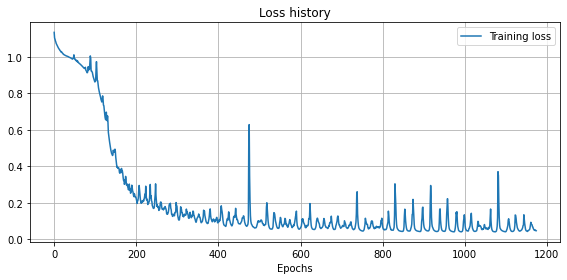

In [ ]:
rand_seed = 0
fig = plt.figure(figsize=(9, 2.5))
for key in params.keys():
    model_name=key
    out_dir='output/checkpoint/'
    tag = out_dir + model_name + '_mu_try0_' + str(rand_seed)
    csv_fname = tag + '_history.csv'
    df_hist = pd.read_csv(csv_fname, index_col=0)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.set_title(fr'Loss history')
    ax.plot(df_hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()

In [ ]:
alpha = model.predict(x_train_reg1)
mu = alpha*X1_std[0]+X1_mean[0]
np.mean(((y_train_reg.reshape(1,-1)-alpha.reshape(1,-1))*X1_std[0])**2)

1.9857115748314833e-06

In [ ]:
alpha_test = model.predict(x_test_reg1)
mu_test = alpha_test*X1_std[0]+X1_mean[0]
np.mean(((y_test_reg.reshape(1,-1)-alpha_test.reshape(1,-1))*X1_std[0])**2)

0.00020865163275991247

In [ ]:
y_test_reg[0:10]*X1_std[0]+X1_mean[0]

array([-0.01232786, -0.00417467, -0.0303157 , -0.0003708 ,  0.00510815,
        0.03300911, -0.01941057,  0.01373147,  0.01612865, -0.01254632])

In [ ]:
mu_test[0:10]

array([[ 0.00217693],
       [ 0.00112797],
       [ 0.00281396],
       [ 0.00246194],
       [ 0.01904832],
       [-0.0061846 ],
       [ 0.00077423],
       [ 0.01924464],
       [ 0.00550137],
       [ 0.01025126]], dtype=float32)

In [ ]:
np.mean((mu[0:10].reshape(-1,1)-(y_test_reg[0:10].reshape(-1,1)*X1_std[0]+X1_mean[0]))**2)

0.00039023109931826574

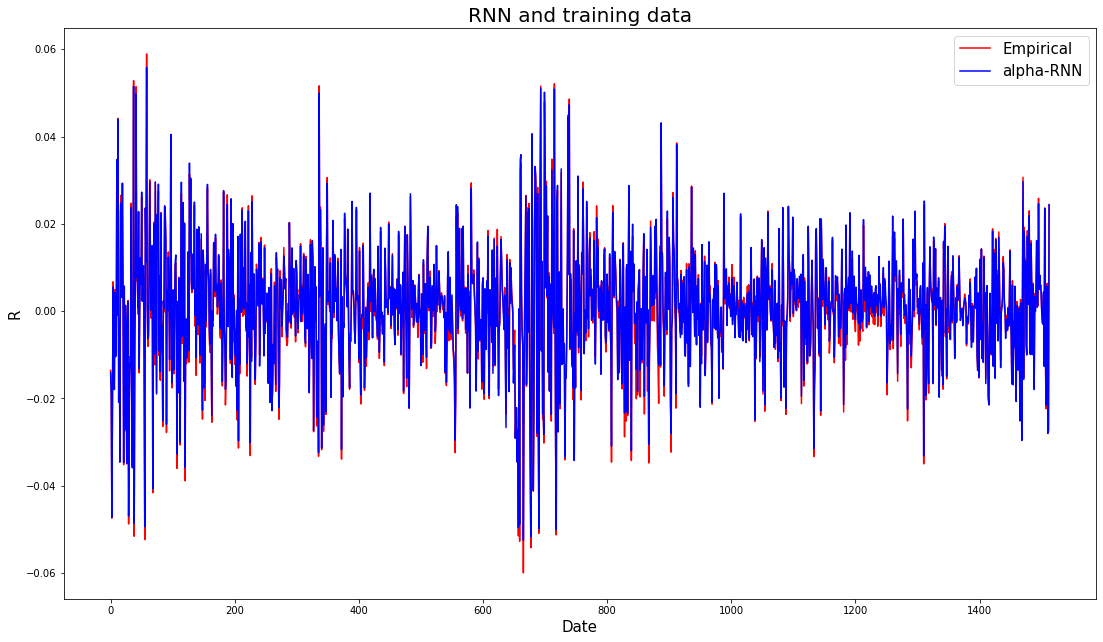

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_train_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu,color='blue',label='alpha-RNN')
plt.xlabel('Date',fontsize=15)
plt.ylabel('R',fontsize=15)
plt.title('RNN and training data',fontsize=20)
plt.legend(fontsize=15)

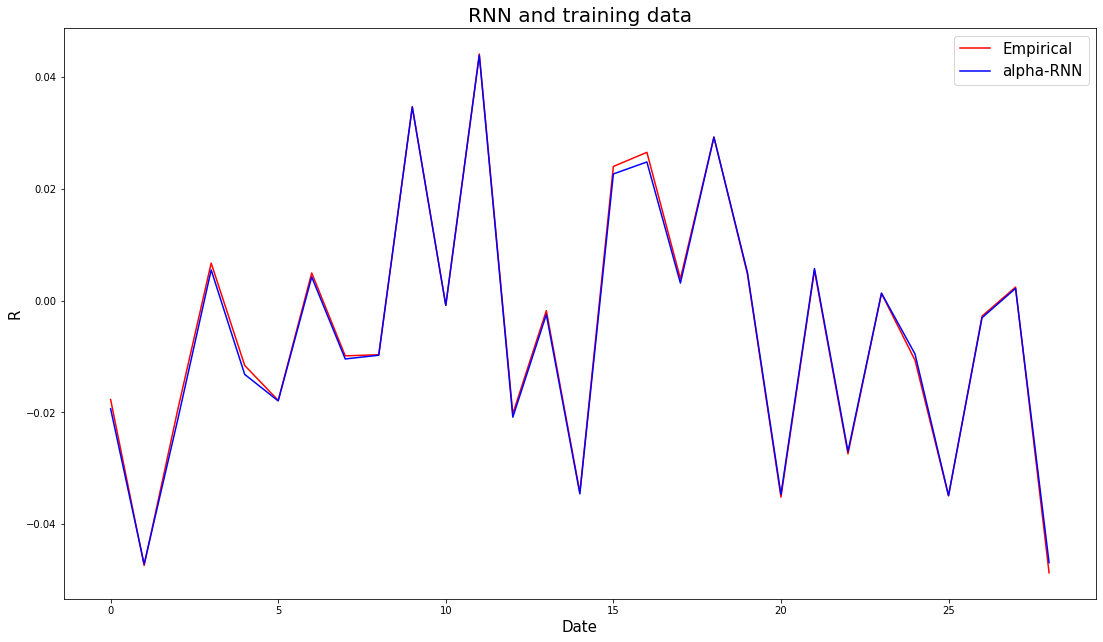

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_train_reg[1:30]*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu[1:30],color='blue',label='alpha-RNN')
plt.xlabel('Date',fontsize=15)
plt.ylabel('R',fontsize=15)
plt.title('RNN and training data',fontsize=20)
plt.legend(fontsize=15)

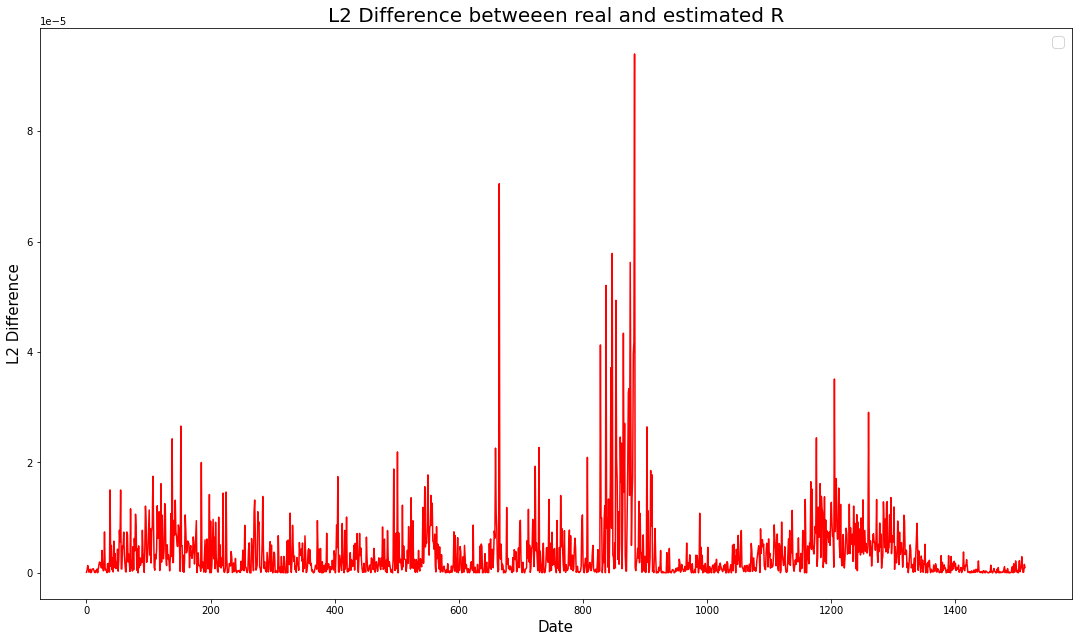

In [ ]:
diff = (mu.reshape(-1,1)-y_train_reg.reshape(-1,1)*X1_std[0]+X1_mean[0])**2
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(diff,color='red')
plt.xlabel('Date',fontsize=15)
plt.ylabel('L2 Difference',fontsize=15)
plt.title('L2 Difference betweeen real and estimated R',fontsize=20)
plt.legend(fontsize=15)

Text(0.5, 0.98, 'L2 Difference betweeen real and estimated R')

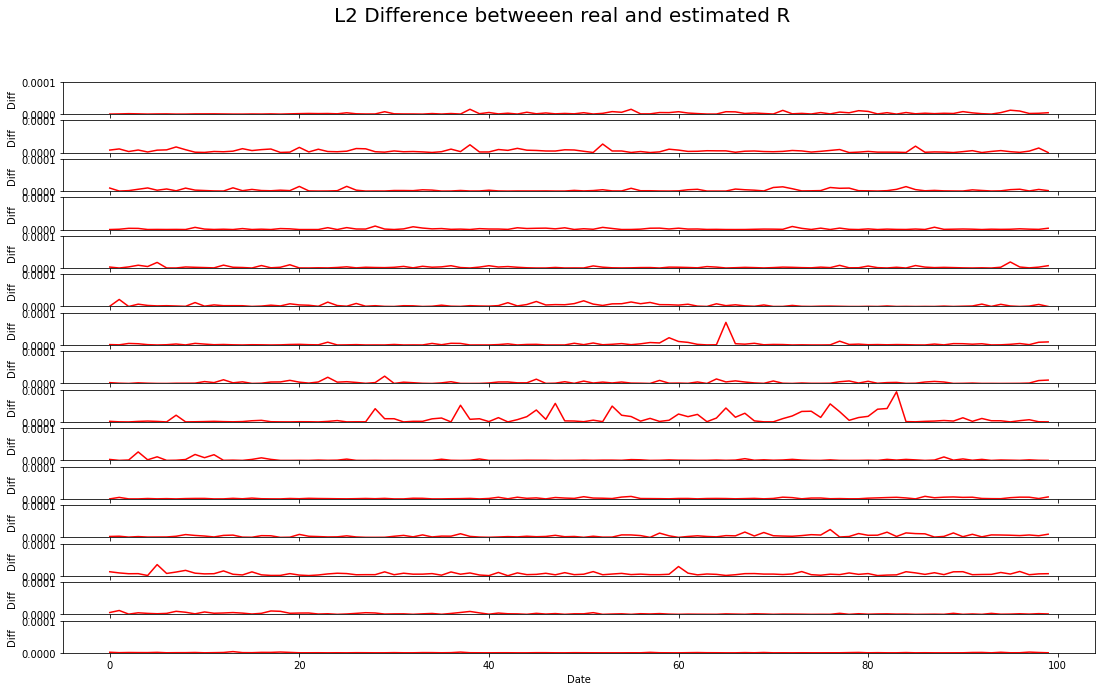

In [ ]:
diff_train = (mu.reshape(-1,1)-y_train_reg.reshape(-1,1)*X1_std[0]+X1_mean[0])**2
fig,ax = plt.subplots(15,1)
fig.set_size_inches(18.5, 10.5)
for k in range(15):
  ax[k].plot(diff_train[k*100:(k+1)*100],color='red')
  ax[k].set(xlabel='Date', ylabel='Diff')
  ax[k].set_ylim([0,0.0001])
  # ax[k].set_title('Period %i' %k,fontsize=7)
  ax[k].label_outer()
fig.suptitle('L2 Difference betweeen real and estimated R',fontsize=20)



Text(0.5, 0.98, 'Absolute Percentage Error betweeen real and estimated R')

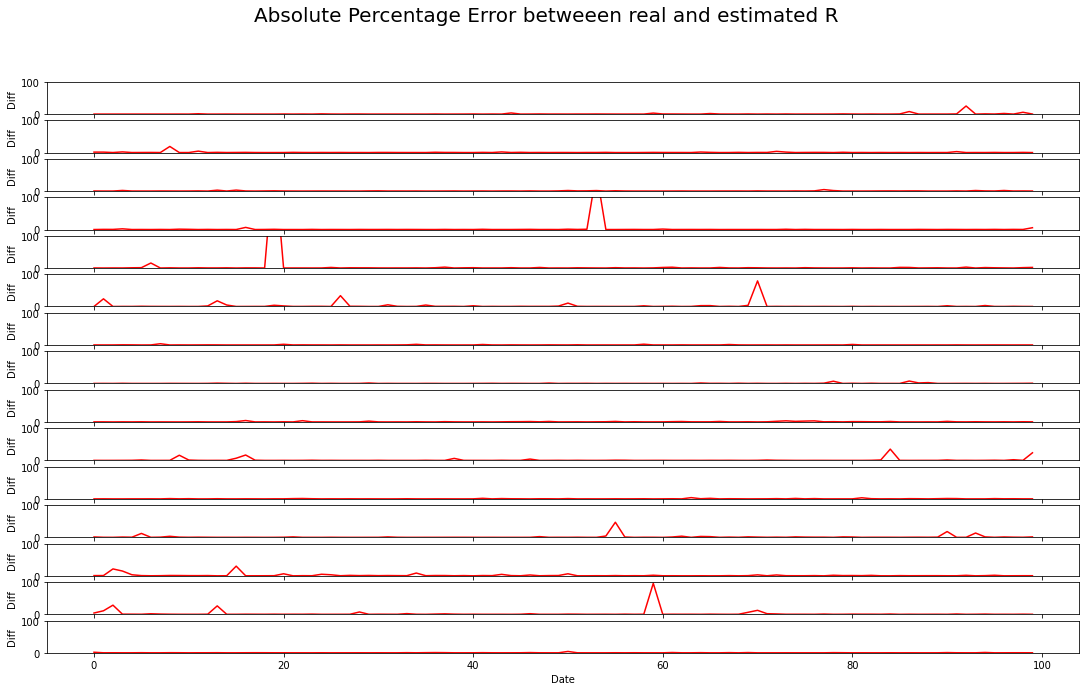

In [ ]:
diff_train2 = np.abs((mu.reshape(-1,1)-y_train_reg.reshape(-1,1)*X1_std[0]+X1_mean[0])/(y_train_reg.reshape(-1,1)*X1_std[0]+X1_mean[0]))
fig,ax = plt.subplots(15,1)
fig.set_size_inches(18.5, 10.5)
for k in range(15):
  ax[k].plot(diff_train2[k*100:(k+1)*100],color='red')
  ax[k].set(xlabel='Date', ylabel='Diff')
  ax[k].set_ylim([0,100])
  # ax[k].set_title('Period %i' %k,fontsize=7)
  ax[k].label_outer()
fig.suptitle('Absolute Percentage Error betweeen real and estimated R',fontsize=20)



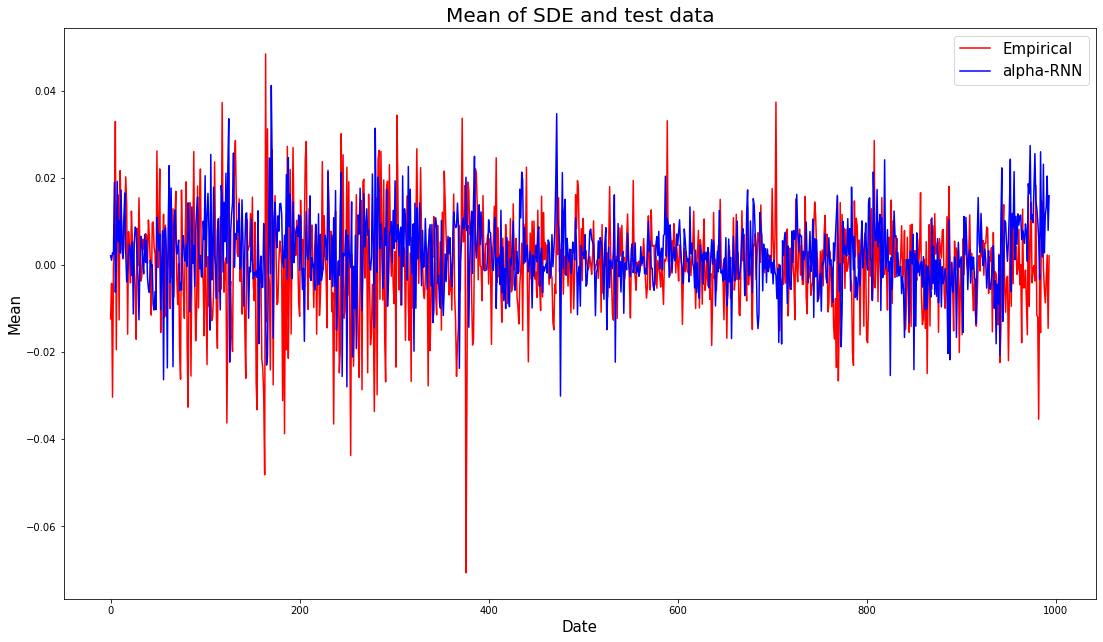

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_test.reshape(-1,),color='blue',label='alpha-RNN')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and test data',fontsize=20)
plt.legend(fontsize=15)

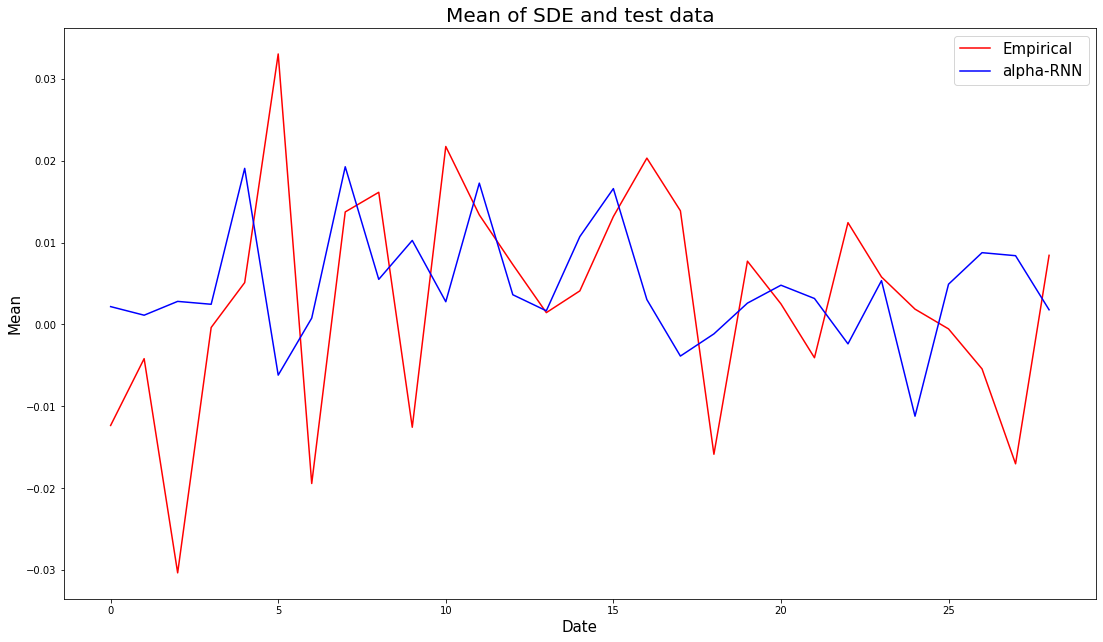

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg[0:29]*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_test[0:29],color='blue',label='alpha-RNN')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and test data',fontsize=20)
plt.legend(fontsize=15)

Text(0.5, 0.98, 'L2 Difference betweeen real and estimated R')

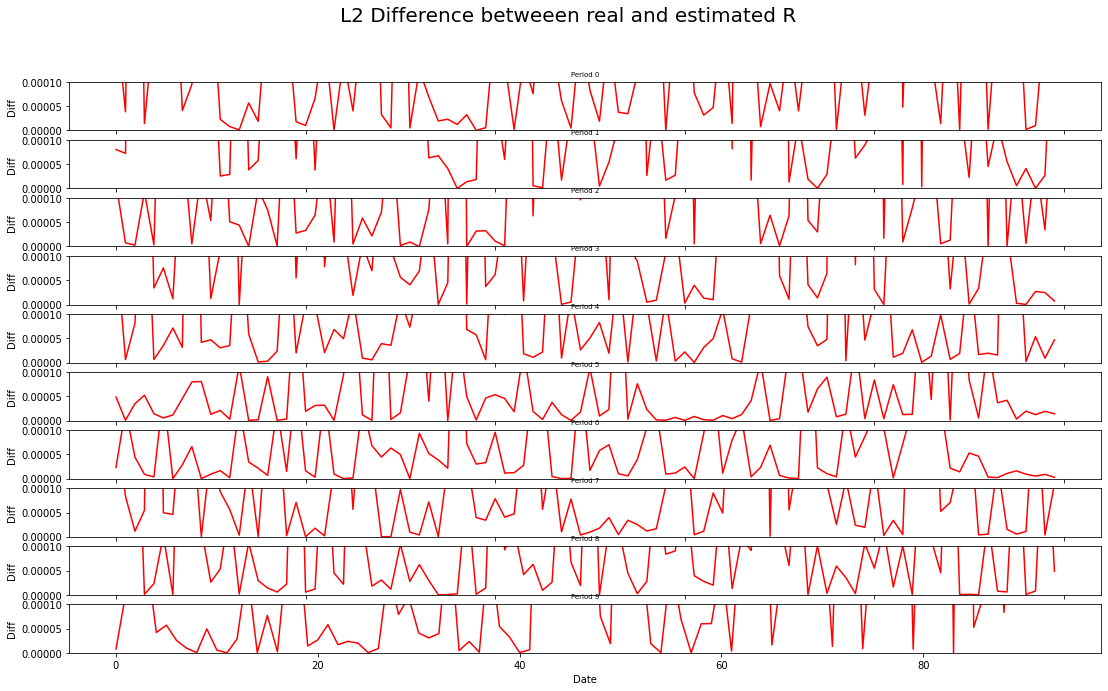

In [ ]:
diff_test = (mu_test.reshape(-1,1)-y_test_reg.reshape(-1,1)*X1_std[0]+X1_mean[0])**2
fig,ax = plt.subplots(10,1)
fig.set_size_inches(18.5, 10.5)
for k in range(10):
  ax[k].plot(diff_test[k*100:(k+1)*100],color='red')
  ax[k].set(xlabel='Date', ylabel='Diff')
  ax[k].set_ylim([0,0.0001])
  ax[k].set_title('Period %i' %k,fontsize=7)
  ax[k].label_outer()
fig.suptitle('L2 Difference betweeen real and estimated R',fontsize=20)



Text(0.5, 0.98, 'Absolute Percentage Error of real and estimated R')

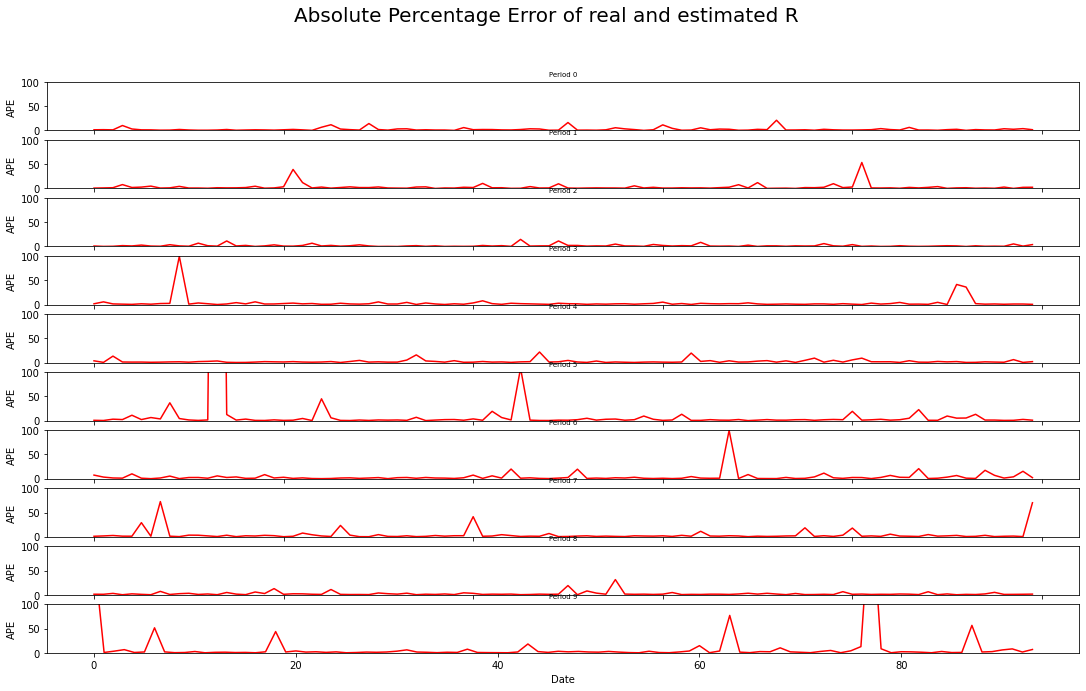

In [ ]:
diff_test2 = np.abs((mu_test.reshape(-1,1)-y_test_reg.reshape(-1,1)*X1_std[0]+X1_mean[0])/(y_test_reg.reshape(-1,1)*X1_std[0]+X1_mean[0]))
fig,ax = plt.subplots(10,1)
fig.set_size_inches(18.5, 10.5)
for k in range(10):
  ax[k].plot(diff_test2[k*100:(k+1)*100],color='red')
  ax[k].set(xlabel='Date', ylabel='APE')
  ax[k].set_ylim([0,100])
  ax[k].set_title('Period %i' %k,fontsize=7)
  ax[k].label_outer()
fig.suptitle('Absolute Percentage Error of real and estimated R',fontsize=20)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density of Training and Test R')

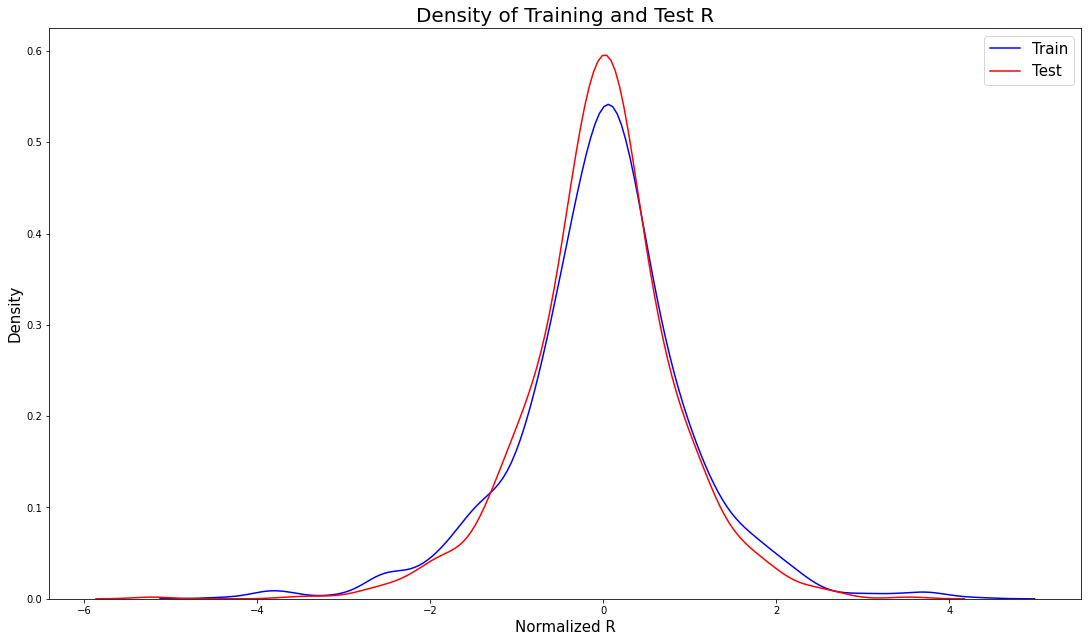

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.distplot(y_train_reg, hist=False, kde=True, 
             bins=int(180/5), color = 'blue')
sns.distplot(y_test_reg, hist=False, kde=True, 
             bins=int(180/5), color = 'red')
plt.legend(labels=['Train', 'Test'],fontsize=15)
plt.xlabel('Normalized R',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Density of Training and Test R',fontsize=20)

In [ ]:
res_train = y_train_reg - mu.reshape(-1,)
res_train.shape
res_test = y_test_reg - mu_test.reshape(-1,)
res_test.shape

(994,)

In [ ]:
def AlphaRNN_sigma_(n_units = 10, dense_units=64, l1_reg=0, seed=0,dt=dt):
  inputs = Input(shape=(x_train_reg2.shape[1],x_train_reg2.shape[2]))
  x2 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg2.shape[1], x_train_reg2.shape[-1]), unroll=True)(inputs)
  x2 = Dense(dense_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out2 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  Mymodel = Model(inputs=inputs,outputs=out2)

  Mymodel.compile(loss=Loss.loss_lnS_sigma, optimizer='adam')
  return Mymodel

In [ ]:
def custom_loss_function_sigma(y_true, y_pred):
    gamma = y_pred.astype('float32')
    alpha = y_true.astype('float32')
            
    # compute log-likelihood
    score = -np.sum(-gamma+tf.square(alpha)*tf.exp(gamma)/dt )


    return score

scorer_sigma = make_scorer(custom_loss_function_sigma, greater_is_better=True)

In [ ]:
params_sigma = {'alpharnn_sigma': {'model':'', 'function':AlphaRNN_sigma_,'l1_reg':0.0, 'H':10, 'D':64,'color': 'green', 'label': '$\\alpha$-RNN_sigma' }}
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-5, restore_best_weights=True)

In [ ]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [10,20,50]
    l1_reg = [0, 0.001, 0.01]
    dense_units = [4,16,64]

    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,dense_units=dense_units,l1_reg=l1_reg)

    for key in params_sigma.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params_sigma[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scorer_sigma,error_score="raise",cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg2,res_train,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params_sigma[key]['H'] = grid_result.best_params_['n_units']
        params_sigma[key]['l1_reg']= grid_result.best_params_['l1_reg']
        params_sigma[key]['D']= grid_result.best_params_['dense_units']

        joblib.dump(grid, key + 'grid_sigma.pkl')

Streaming output truncated to the last 5000 lines.
 - 0s - loss: 53.8355
Epoch 1474/6000
 - 0s - loss: 58.6225
Epoch 1475/6000
 - 0s - loss: 60.0217
Epoch 1476/6000
 - 0s - loss: 56.1831
Epoch 1477/6000
 - 0s - loss: 56.4122
Epoch 1478/6000
 - 0s - loss: 54.0852
Epoch 1479/6000
 - 0s - loss: 53.6022
Epoch 1480/6000
 - 0s - loss: 53.4544
Epoch 1481/6000
 - 0s - loss: 53.2932
Epoch 1482/6000
 - 0s - loss: 53.2291
Epoch 1483/6000
 - 0s - loss: 53.1920
Epoch 1484/6000
 - 0s - loss: 53.1882
Epoch 1485/6000
 - 0s - loss: 53.1562
Epoch 1486/6000
 - 0s - loss: 53.1562
Epoch 1487/6000
 - 0s - loss: 53.1387
Epoch 1488/6000
 - 0s - loss: 53.1294
Epoch 1489/6000
 - 0s - loss: 53.1765
Epoch 1490/6000
 - 0s - loss: 53.1435
Epoch 1491/6000
 - 0s - loss: 53.1311
Epoch 1492/6000
 - 0s - loss: 53.1712
Epoch 1493/6000
 - 0s - loss: 53.1830
Epoch 1494/6000
 - 0s - loss: 53.2052
Epoch 1495/6000
 - 0s - loss: 53.4041
Epoch 1496/6000
 - 0s - loss: 57.1828
Epoch 1497/6000
 - 0s - loss: 57.8138
Epoch 1498/6000

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Restoring model weights from the end of the best epoch
Epoch 02259: early stopping
Best: -9941.992383 using {'dense_units': 4, 'l1_reg': 0, 'n_units': 10}
-9941.992383 (14190.727958) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 10}
-68622.738672 (97061.577946) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 20}
-159491.474536 (235415.511275) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 50}
-54998.869214 (60417.176472) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 10}
-29881.475586 (26149.732561) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 20}
-20044.075488 (8881.415924) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 50}
-301722.845679 (590067.442952) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 10}
-37254.763794 (61961.461481) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 20}
-129098.246680 (163596.759928) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 50}
-2257919.796289 (3383823.968086) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 10}
-1396

OSError: ignored

In [ ]:
# -9941.992383 using {'dense_units': 4, 'l1_reg': 0, 'n_units': 10}
# -9941.992383 (14190.727958) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 10}
# -68622.738672 (97061.577946) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 20}
# -159491.474536 (235415.511275) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 50}
# -54998.869214 (60417.176472) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 10}
# -29881.475586 (26149.732561) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 20}
# -20044.075488 (8881.415924) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 50}
# -301722.845679 (590067.442952) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 10}
# -37254.763794 (61961.461481) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 20}
# -129098.246680 (163596.759928) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 50}
# -2257919.796289 (3383823.968086) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 10}
# -139628.088281 (189370.162876) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 20}
# -183827.406250 (308312.295876) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 50}
# -1068875.781836 (2074432.159788) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 10}
# -331247.000195 (351488.759092) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 20}
# -94558.113477 (110671.064841) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 50}
# -40954.761133 (39553.308553) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 10}
# -191182.444531 (252314.013765) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 20}
# -27415.657422 (12572.015649) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 50}
# -290423.872852 (437700.736188) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 10}
# -505495.638281 (752401.965567) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 20}
# -160812.738672 (262232.259638) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 50}
# -80273.620605 (66000.504038) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 10}
# -575439.952148 (724864.664781) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 20}
# -20490.014551 (21052.725303) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 50}
# -55116.661133 (54777.673725) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 10}
# -745633.772266 (894477.078841) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 20}
# -174548.477734 (287519.578467) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 50}

In [ ]:
params_sigma

{'alpharnn_sigma': {'model': '',
  'function': <function __main__.AlphaRNN_sigma_(n_units=10, dense_units=64, l1_reg=0, seed=0, dt=0.0027397260273972603)>,
  'l1_reg': 0,
  'H': 10,
  'D': 4,
  'color': 'green',
  'label': '$\\alpha$-RNN_sigma'}}

In [ ]:
params_sigma['alpharnn_sigma']['l1_reg'] = 0
params_sigma['alpharnn_sigma']['H'] = 10
params_sigma['alpharnn_sigma']['D'] = 4

In [ ]:
for key in params_sigma.keys():
  rand_seed = 0
  tf.compat.v1.set_random_seed(rand_seed)
  model=params_sigma[key]['function'](params_sigma[key]['H'],params_sigma[key]['D'],params_sigma[key]['l1_reg'])

  model_name=key
  out_dir='output/checkpoint/'

  tag = out_dir + model_name + '_sigma0_' + str(rand_seed)
  checkpoint_filepath = tag
  checkpoint_filepath_all = tag + '*'
  csv_fname = tag + '_history.csv'

  pruning_dir = out_dir + 'pruning_summary/'
  if not os.path.exists(pruning_dir):
    os.makedirs(pruning_dir)

  # train the pruned model
  tf.random.set_seed(rand_seed)
  if glob(checkpoint_filepath_all):
    model.load_weights(checkpoint_filepath)
  else:
    model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
    csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
    
    history = model.fit(x_train_reg2,res_train,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    # plot training loss history
    plot_fname = tag + '_history.png'
    hist = pd.DataFrame(history.history)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()

    plt.savefig(plot_fname, dpi=500)
    plt.close()
  params_sigma[key]['model']=model

Streaming output truncated to the last 5000 lines.
Epoch 833/6000
1513/1513 [==============================] - 0s 246us/step - loss: 62.1682
Epoch 834/6000
1513/1513 [==============================] - 0s 196us/step - loss: 62.1643
Epoch 835/6000
1513/1513 [==============================] - 0s 213us/step - loss: 62.1605
Epoch 836/6000
1513/1513 [==============================] - 0s 224us/step - loss: 62.1566
Epoch 837/6000
1513/1513 [==============================] - 0s 176us/step - loss: 62.1527
Epoch 838/6000
1513/1513 [==============================] - 0s 159us/step - loss: 62.1487
Epoch 839/6000
1513/1513 [==============================] - 0s 162us/step - loss: 62.1448
Epoch 840/6000
1513/1513 [==============================] - 0s 192us/step - loss: 62.1409
Epoch 841/6000
1513/1513 [==============================] - 0s 202us/step - loss: 62.1369
Epoch 842/6000
1513/1513 [==============================] - 0s 185us/step - loss: 62.1330
Epoch 843/6000
1513/1513 [=======================

In [ ]:
sigma = model.predict(x_train_reg2)
sigma = np.exp(sigma/2)*np.sqrt(dt)*X1_std[0]
sigma_test = model.predict(x_test_reg2)
sigma_test = np.exp(sigma_test/2)*np.sqrt(dt)*X1_std[0]

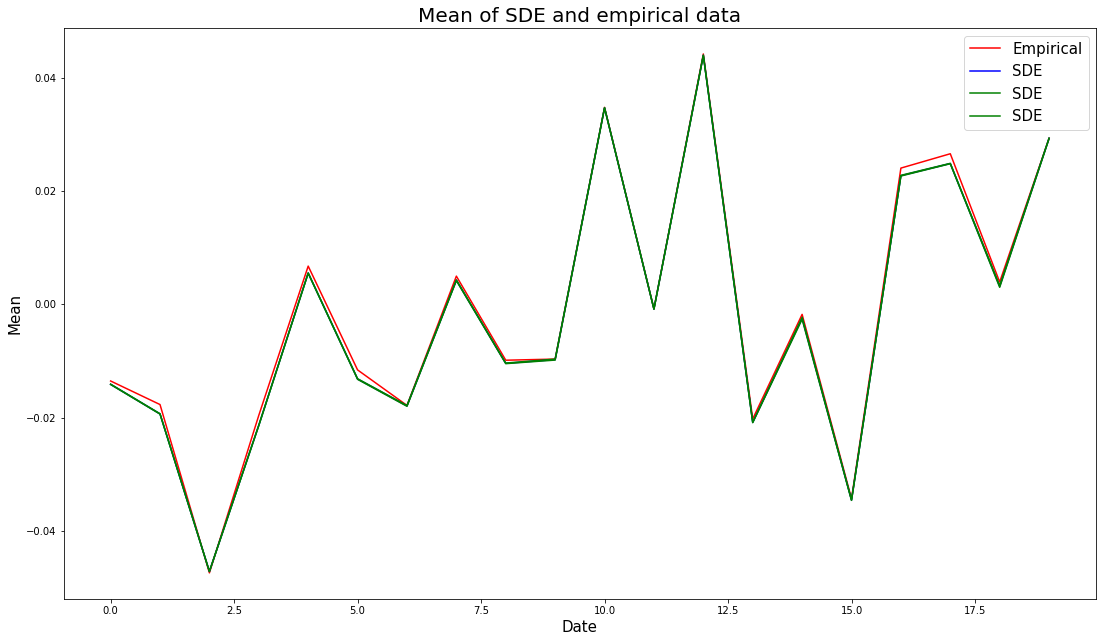

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_train_reg[0:20]*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu[0:20],color='blue',label='SDE')
plt.plot(mu[0:20]+1.95*sigma[0:20],color='green',label='SDE')
plt.plot(mu[0:20]-1.95*sigma[0:20],color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)


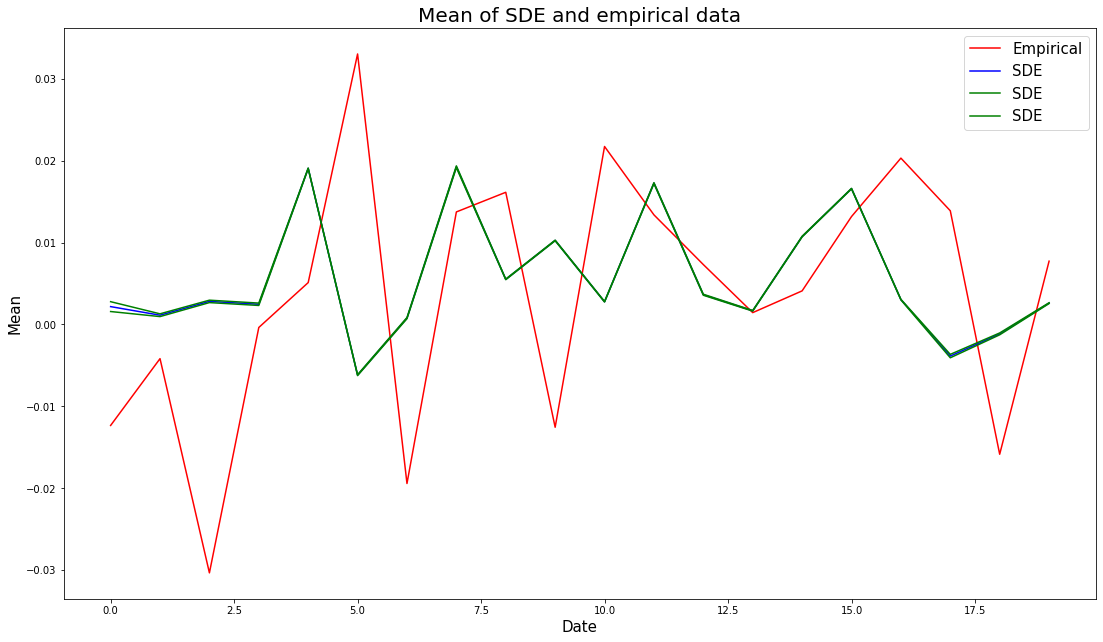

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg[0:20]*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_test[0:20],color='blue',label='SDE')
plt.plot(mu_test[0:20]+1.95*sigma_test[0:20],color='green',label='SDE')
plt.plot(mu_test[0:20]-1.95*sigma_test[0:20],color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)


In [ ]:
from scipy.stats import norm, binom, chi2

quantile = 0.95
refit = 253
test_num = y_test_reg.shape[0]
refit_times = test_num//refit + (test_num%refit > 0)

for key in params.keys():
  model_temp = AlphaRNN_(params[key]['H'],params[key]['D'],params[key]['l1_reg'])
  rand_seed = 0

  model_name=key
  out_dir='output/checkpoint/'

  pruning_dir = out_dir + 'pruning_summary/'
  
  mu_result = np.array([0])
  sigma_result = np.array([0])
  for k in range(refit_times):
    end = np.minimum(test_num,k*refit)
    x_train_reg_temp = np.concatenate((x_train_reg,x_test_reg[0:end,:,:]),axis=0) 
    y_train_reg_temp = np.concatenate((y_train_reg,y_test_reg[0:end]),axis=0) 
    x_test_reg_temp = x_test_reg[end:np.minimum(end+refit,test_num),:,:]
    y_test_reg_temp = y_test_reg[end:np.minimum(end+refit,test_num)]
    if k == 0:
      tag = out_dir + model_name[0] + '_norm6_' + str(rand_seed)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'
      model_temp.load_weights(checkpoint_filepath)
    else:
      tag = out_dir + model_name[0] + '_norm6_' + str(rand_seed)+ '_' + str(k)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'

      pruning_dir = out_dir + 'pruning_summary/'
      
      if not os.path.exists(pruning_dir):
        os.makedirs(pruning_dir)
      # train the pruned model
      tf.random.set_seed(rand_seed)
      if glob(checkpoint_filepath_all):
        model_temp.load_weights(checkpoint_filepath)
      else:
        model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
        csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
        history = model_temp.fit(x_train_reg_temp,y_train_reg_temp,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    alpha_test = model_temp.predict(x_test_reg_temp)
    mu_test = alpha_test[:,0]*dt*X1_std[0]+X1_mean[0]
    sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]*np.sqrt(dt)
    mu_result = np.concatenate((mu_result,mu_test),axis=0)
    sigma_result = np.concatenate((sigma_result,sigma_test),axis=0)


mu_result = mu_result[1:]
sigma_result = sigma_result[1:]

In [ ]:
def AlphaRNN_MD_(n_units = 10, dense_units=64, l1_reg=0, seed=0,dt=dt):
  inputs = Input(shape=(x_train_reg.shape[1],x_train_reg.shape[2]))
  in1 = Lambda(lambda x: tf.slice(x,[0,0,0],[-1,-1,x_train_reg1.shape[2]]))(inputs)
  in2 = Lambda(lambda x: tf.slice(x,[0,0,x_train_reg1.shape[2]],[-1,-1,-1]))(inputs)
  x1 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg1.shape[1], x_train_reg1.shape[-1]), unroll=True)(in1)
  x2 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg2.shape[1], x_train_reg2.shape[-1]), unroll=True)(in2)
  x1 = Dense(dense_units, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  x2 = Dense(dense_units, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out1 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  out2 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out =  Lambda(lambda x :K.concatenate(x,1))([out1,out2])
  Mymodel = Model(inputs=inputs,outputs=out)

  Mymodel.compile(loss=Loss.loss_lnS_MD, optimizer='adam')
  return Mymodel

In [ ]:
def custom_loss_function_MD(y_true, y_pred):
    alpha = y_pred[:,0].astype('float32')
    gamma = y_pred[:,1].astype('float32')
            
    # compute log-likelihood
    score = -np.sum(tf.square(y_true - (alpha)*dt)*tf.exp(gamma)/dt )


    return score

scorer_MD = make_scorer(custom_loss_function_MD, greater_is_better=True)

In [ ]:
params = {'alpharnn_MD': {'model':'', 'function':AlphaRNN_MD_,'l1_reg':0.0, 'H':10, 'D':64,'color': 'green', 'label': '$\\alpha$-RNN_MD' }}

In [ ]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [5,10,20,50]
    l1_reg = [0, 0.001, 0.01]
    dense_units= [16,32,64]
    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,dense_units=dense_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scorer_MD,error_score="raise",cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

        joblib.dump(grid, key + 'grid.pkl')

Streaming output truncated to the last 5000 lines.
 - 0s - loss: 1218.8337
Epoch 3012/6000
 - 0s - loss: 1214.7781
Epoch 3013/6000
 - 0s - loss: 1152.5960
Epoch 3014/6000
 - 0s - loss: 1118.8449
Epoch 3015/6000
 - 0s - loss: 1150.4844
Epoch 3016/6000
 - 0s - loss: 1195.2638
Epoch 3017/6000
 - 0s - loss: 1165.9279
Epoch 3018/6000
 - 0s - loss: 1129.7509
Epoch 3019/6000
 - 0s - loss: 1215.9833
Epoch 3020/6000
 - 0s - loss: 1191.0339
Epoch 3021/6000
 - 0s - loss: 1200.6351
Epoch 3022/6000
 - 0s - loss: 1137.3369
Epoch 3023/6000
 - 0s - loss: 1176.1311
Epoch 3024/6000
 - 0s - loss: 1138.5362
Epoch 3025/6000
 - 0s - loss: 1123.3218
Epoch 3026/6000
 - 0s - loss: 1113.1284
Epoch 3027/6000
 - 0s - loss: 1167.8899
Epoch 3028/6000
 - 0s - loss: 1146.8974
Epoch 3029/6000
 - 0s - loss: 1175.2173
Epoch 3030/6000
 - 0s - loss: 1151.5588
Epoch 3031/6000
 - 0s - loss: 1178.1703
Epoch 3032/6000
 - 0s - loss: 1153.4278
Epoch 3033/6000
 - 0s - loss: 1169.0025
Epoch 3034/6000
 - 0s - loss: 1127.6852
Epoch

In [ ]:
# Best: -0.006773 using {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 50}
# -0.115889 (0.136739) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 5}
# -0.703931 (1.292444) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 10}
# -0.459470 (0.826874) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 20}
# -0.039018 (0.046801) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 50}
# -0.938577 (1.081482) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 5}
# -0.532713 (0.619092) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 10}
# -0.237884 (0.245893) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 20}
# -0.129806 (0.110733) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 50}
# -3.233147 (4.262878) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 5}
# -0.379973 (0.245230) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 10}
# -0.168874 (0.150965) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 20}
# -0.407983 (0.754414) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 50}
# -0.348486 (0.325738) with {'dense_units': 32, 'l1_reg': 0, 'n_units': 5}
# -0.255780 (0.388023) with {'dense_units': 32, 'l1_reg': 0, 'n_units': 10}
# -0.018496 (0.023135) with {'dense_units': 32, 'l1_reg': 0, 'n_units': 20}
# -0.107628 (0.150828) with {'dense_units': 32, 'l1_reg': 0, 'n_units': 50}
# -0.693654 (0.745707) with {'dense_units': 32, 'l1_reg': 0.001, 'n_units': 5}
# -0.031938 (0.019802) with {'dense_units': 32, 'l1_reg': 0.001, 'n_units': 10}
# -0.038342 (0.032873) with {'dense_units': 32, 'l1_reg': 0.001, 'n_units': 20}
# -0.030527 (0.054959) with {'dense_units': 32, 'l1_reg': 0.001, 'n_units': 50}
# -6.882568 (12.627071) with {'dense_units': 32, 'l1_reg': 0.01, 'n_units': 5}
# -0.240423 (0.266771) with {'dense_units': 32, 'l1_reg': 0.01, 'n_units': 10}
# -0.269039 (0.384877) with {'dense_units': 32, 'l1_reg': 0.01, 'n_units': 20}
# -0.176440 (0.224122) with {'dense_units': 32, 'l1_reg': 0.01, 'n_units': 50}
# -0.633229 (0.857907) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 5}
# -0.029733 (0.030353) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 10}
# -0.030141 (0.056966) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 20}
# -0.012011 (0.019279) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 50}
# -0.185358 (0.268395) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 5}
# -0.179872 (0.291998) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 10}
# -0.034325 (0.062485) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 20}
# -0.031635 (0.026672) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 50}
# -0.088041 (0.105817) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 5}
# -1.354430 (2.413327) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 10}
# -0.016103 (0.012185) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 20}
# -0.006773 (0.009408) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 50}

# Shock

In [48]:
# load OptionMetric data
ls_securityid = ['DAX']
in_dir = '/content/drive/My Drive/Python/ImpVol/input/'
dt = 1./365

curr_module = sys.modules[__name__]

ls_X = []
ls_dX = []
ls_S = []
ls_S_test = []
ls_C = []
ls_C_test = []
ls_dates = []
for i_securityid in range(len(ls_securityid)):
    securityid = ls_securityid[i_securityid]
    
    fname = in_dir + f'om_{securityid}.pkl'
    with open(fname, 'rb') as f:
        cache = pickle.load(f)
        
    for k, v in vars(cache).items():
        setattr(curr_module, k, v)
    
    ls_X.append(X)
    ls_dX.append(dX)
    ls_S.append(S)
    ls_S_test.append(S_test)
    ls_C.append(cs)
    ls_C_test.append(cs_test)
    ls_dates.append(dates_train)

# concatenate factor data
X = np.vstack(ls_X)
dX = np.vstack(ls_dX)

start = 0
end = 3000
R = np.diff(np.log(S))
S = S[:-1]
R = R[start:end]
S = S[start:end]


# Create Date data for ploting
N_test = 1000
t = dates_train[0:-N_test]
t = t[0:-1]
t = t.astype(datetime)
Date = [datetime.strptime(x,'%Y-%m-%d') for x in t]

t_test = dates_train[-N_test:]
t_test = t_test[0:-1]
t_test = t_test.astype(datetime)
Date_test = [datetime.strptime(x,'%Y-%m-%d') for x in t_test]

# Split data to training and test
S_all = S
X_all = X
cs_all = cs
S_test = S[-N_test:]
X_test = X[-N_test:,:]
cs_test = cs[-N_test:,:]
S = S[0:-N_test]
X = X[0:-N_test,:]
cs = cs[0:-N_test,:]

In [49]:
dates_train[1999+425]

'2011-07-29'

In [50]:
V_norm_all_sk = pd.read_csv('/content/drive/My Drive/Python/ImpVol/input/V_norm_all_shock.csv')
R_all = pd.DataFrame(R,columns=['R'])
V_norm1_sk = V_norm_all_sk.iloc[:,0:2]
V_norm2_sk = V_norm_all_sk.iloc[:,-4:]

In [51]:
V_norm1_sk.shape

(3000, 2)

In [52]:
X1 = R_all.drop(R_all.tail(1).index,inplace=False)
X1.reset_index(drop=True, inplace=True)
X1_train = X1.iloc[:(-N_test),:]
X1_mean = X1_train.mean()
X1_std = X1_train.std()
X1 = (X1-X1_mean[0])/X1_std[0]
X_norm1_sk = V_norm1_sk.drop(V_norm1_sk.head(1).index,inplace=False)
X_norm1_sk.reset_index(drop=True, inplace=True)
X_all1_sk = pd.concat([X1,X_norm1_sk],axis=1)
X_norm2_sk = V_norm2_sk.drop(V_norm2_sk.head(1).index,inplace=False)
X_norm2_sk.reset_index(drop=True, inplace=True)
X_all2_sk = pd.concat([X1,X_norm2_sk],axis=1)

X_train1_sk = X_all1_sk.iloc[:(-N_test),:]
X_test1_sk = X_all1_sk.iloc[-N_test:,:]
X_train2_sk = X_all2_sk.iloc[:(-N_test),:]
X_test2_sk = X_all2_sk.iloc[-N_test:,:]

X_train_sk = [X_train1_sk,X_train2_sk]
X_test_sk = [X_test1_sk,X_test2_sk]

In [53]:
X_train2_sk

R  Comp 1.1  Comp 2.1    Comp 3    Comp 4
0     1.152172  0.350579  0.098852 -0.338031  1.121686
1     0.536918  0.090854 -0.209882 -1.512272  1.290611
2    -0.967710  0.264156 -0.050934 -0.876087  1.132168
3     0.043736  0.230129 -0.159387 -0.759313  1.242310
4     0.577536  0.268006 -0.062876 -0.409045  1.036531
...        ...       ...       ...       ...       ...
1994  1.417372  0.183380 -1.836812 -0.260229  0.188871
1995 -0.329742  0.257667 -1.808386  0.207923  0.319163
1996  0.340247  0.169587 -1.974721  0.003907  0.460789
1997 -1.949405  0.554603 -1.219223  0.756131 -0.024875
1998  0.742689  0.436110 -1.436047  0.523746  0.035241

[1999 rows x 5 columns]

In [54]:
use_features1=['R','Comp 1','Comp 2']
use_features2=['R','Comp 1.1','Comp 2.1','Comp 3','Comp 4']
n_steps_all = []
for feature in use_features1:
  pacf=sm.tsa.stattools.pacf(X_train1_sk[feature], nlags=30)
  n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(X_train1_sk[feature])))==False)[0][0] -1
  n_steps_all.append(n_steps)
for feature in use_features2:
  pacf=sm.tsa.stattools.pacf(X_train2_sk[feature], nlags=30)
  n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(X_train2_sk[feature])))==False)[0][0] -1
  n_steps_all.append(n_steps)
n_steps = np.max(n_steps_all)
print(n_steps)

5


In [55]:
n_steps_ahead=1

target='R'

# For R
x_train_list1 = []
for use_feature in use_features1:
    x_train_reg1 = get_lagged_features(X_train1_sk, n_steps, n_steps_ahead).dropna()
    x_train_list1.append(x_train_reg1)
x_train_reg1 = pd.concat(x_train_list1, axis=1)

col_ords1 = []
for i in range(n_steps):
    for j in range(len(use_features1)):
        col_ords1.append(j + i*len(use_features1))

x_train_reg1 = x_train_reg1.iloc[:, col_ords1]
y_train_reg = X_train1_sk.loc[x_train_reg1.index, [target]].values
x_train_reg1 = np.reshape(x_train_reg1.values, (x_train_reg1.shape[0], np.int(x_train_reg1.shape[1] / len(use_features1)), len(use_features1)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list1 = []
for use_feature in use_features1:
    x_test_reg1 = get_lagged_features(X_test1_sk, n_steps,n_steps_ahead).dropna()
    x_test_list1.append(x_test_reg1)
x_test_reg1 = pd.concat(x_test_list1, axis=1)

x_test_reg1 = x_test_reg1.iloc[:, col_ords1]
y_test_reg = X_test1_sk.loc[x_test_reg1.index, [target]].values
x_test_reg1 = np.reshape(x_test_reg1.values, (x_test_reg1.shape[0], np.int(x_test_reg1.shape[1]/len(use_features1)), len(use_features1)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

# For R^2
x_train_list2 = []
for use_feature in use_features2:
    x_train_reg2 = get_lagged_features(X_train2_sk, n_steps, n_steps_ahead).dropna()
    x_train_list2.append(x_train_reg2)
x_train_reg2 = pd.concat(x_train_list2, axis=1)

col_ords2 = []
for i in range(n_steps):
    for j in range(len(use_features2)):
        col_ords2.append(j + i*len(use_features2))

x_train_reg2 = x_train_reg2.iloc[:, col_ords2]
#y_train_reg2 = X_train2.loc[x_train_reg2.index, [target]].values
x_train_reg2 = np.reshape(x_train_reg2.values, (x_train_reg2.shape[0], np.int(x_train_reg2.shape[1] / len(use_features2)), len(use_features2)))
#y_train_reg2 = np.reshape(y_train_reg2, (y_train_reg2.shape[0], 1, 1))

x_test_list2 = []
for use_feature in use_features2:
    x_test_reg2 = get_lagged_features(X_test2_sk, n_steps,n_steps_ahead).dropna()
    x_test_list2.append(x_test_reg2)
x_test_reg2 = pd.concat(x_test_list2, axis=1)

x_test_reg2 = x_test_reg2.iloc[:, col_ords2]
#y_test_reg2 = X_test1.loc[x_test_reg2.index, [target]].values
x_test_reg2 = np.reshape(x_test_reg2.values, (x_test_reg2.shape[0], np.int(x_test_reg2.shape[1]/len(use_features2)), len(use_features2)))

#y_test_reg2 = np.reshape(y_test_reg2, (y_test_reg2.shape[0], 1, 1))
y_train_reg1 = y_train_reg
y_test_reg1 = y_test_reg
y_test_reg = np.squeeze(y_test_reg)
y_train_reg = np.squeeze(y_train_reg)

<ipython-input-55-89fde048dadd>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train_reg1 = np.reshape(x_train_reg1.values, (x_train_reg1.shape[0], np.int(x_train_reg1.shape[1] / len(use_features1)), len(use_features1)))
<ipython-input-55-89fde048dadd>:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to r

In [56]:
print(x_train_reg1.shape,y_train_reg.shape,x_test_reg1.shape,y_test_reg.shape)
print(x_train_reg2.shape,y_train_reg.shape,x_test_reg2.shape,y_test_reg.shape)

(1994, 5, 3) (1994,) (995, 5, 3) (995,)
(1994, 5, 5) (1994,) (995, 5, 5) (995,)


In [57]:
X_train1_sk.head(8)

R    Comp 1    Comp 2
0  1.152172  0.272979 -0.837558
1  0.536918 -0.041897 -1.466022
2 -0.967710  0.164351 -1.095062
3  0.043736  0.140407 -1.000822
4  0.577536  0.202213 -0.730241
5 -0.675520  0.132179 -1.106071
6 -0.207191  0.205533 -0.850238
7 -1.653758  0.315023 -0.801393

In [58]:
x_train_reg1[0,:,:]

array([[ 1.15217201,  0.27297946, -0.83755823],
       [ 0.53691842, -0.04189695, -1.46602216],
       [-0.96770951,  0.16435127, -1.09506216],
       [ 0.04373565,  0.14040746, -1.00082203],
       [ 0.57753561,  0.20221283, -0.73024148]])

In [59]:
y_train_reg[0:3]

array([-0.67552041, -0.20719078, -1.65375754])

In [60]:
x_train_reg = np.concatenate((x_train_reg1,x_train_reg2),axis=2)
x_test_reg = np.concatenate((x_test_reg1,x_test_reg2),axis=2)
n_obs, lag, n_comp = x_train_reg.shape
n_comp1 = x_train_reg1.shape[2]
n_comp2 = x_train_reg2.shape[2]

In [61]:
def AlphatRNN_(n_units = 10, d_units = 16, l1_reg=0, seed=0,dt=dt):
  inputs = Input(shape=(x_train_reg.shape[1],x_train_reg.shape[2]))
  in1 = Lambda(lambda x: tf.slice(x,[0,0,0],[-1,-1,x_train_reg1.shape[2]]))(inputs)
  in2 = Lambda(lambda x: tf.slice(x,[0,0,x_train_reg1.shape[2]],[-1,-1,-1]))(inputs)
  x1 = AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg1.shape[1], x_train_reg1.shape[-1]), unroll=True)(in1)
  x2 = AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg2.shape[1], x_train_reg2.shape[-1]), unroll=True)(in2)
  x1 = Dense(d_units,activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  x2 = Dense(d_units,activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out1 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  out2 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out =  Lambda(lambda x :K.concatenate(x,1))([out1,out2])
  Mymodel = Model(inputs=inputs,outputs=out)

  Mymodel.compile(loss=Loss.loss_lnS, optimizer='adam')
  return Mymodel

In [62]:
max_epoches=6000
batch_size=10
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=0.1, restore_best_weights=True)
params_sk = {'alphatrnn': {'model':'', 'function':AlphatRNN_,'l1_reg':0.0,'H':10,'color': 'green', 'label': '$\\alpha_t$-RNN' }}

In [63]:
def custom_loss_function(y_true, y_pred):
    alpha = y_pred[:,0].astype('float32')
    gamma = y_pred[:,1].astype('float32')
            
    # compute log-likelihood
    score = -np.sum(-gamma + tf.square(y_true - (alpha)*dt)*tf.exp(gamma)/dt )


    return score

scorer = make_scorer(custom_loss_function, greater_is_better=True)

In [64]:
x_train_reg = x_train_reg.astype('float32')
y_train_reg = y_train_reg.astype('float32')

In [63]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [5,10,20,50]
    l1_reg = [0.01, 0.1]
    d_units = [4,16,64,128]

    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,d_units=d_units,l1_reg=l1_reg)

    for key in params_sk.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params_sk[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scorer,error_score="raise",cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params_sk[key]['H'] = grid_result.best_params_['n_units']
        params_sk[key]['l1_reg']= grid_result.best_params_['l1_reg']
        params_sk[key]['D']= grid_result.best_params_['d_units']

        joblib.dump(grid, key + 'grid_sk8.pkl')

Streaming output truncated to the last 5000 lines.
Epoch 373/6000
 - 1s - loss: 668.2630
Epoch 374/6000
 - 1s - loss: 669.0844
Epoch 375/6000
 - 1s - loss: 668.8167
Epoch 376/6000
 - 1s - loss: 667.6742
Epoch 377/6000
 - 1s - loss: 668.9730
Epoch 378/6000
 - 1s - loss: 668.0188
Epoch 379/6000
 - 1s - loss: 668.3926
Epoch 380/6000
 - 1s - loss: 668.0487
Epoch 381/6000
 - 1s - loss: 668.1505
Epoch 382/6000
 - 1s - loss: 668.2878
Epoch 383/6000
 - 1s - loss: 668.7755
Epoch 384/6000
 - 1s - loss: 668.9405
Epoch 385/6000
 - 1s - loss: 668.2173
Epoch 386/6000
 - 1s - loss: 667.6103
Epoch 387/6000
 - 1s - loss: 668.1126
Epoch 388/6000
 - 1s - loss: 668.3151
Epoch 389/6000
 - 1s - loss: 668.8475
Epoch 390/6000
 - 1s - loss: 668.8961
Epoch 391/6000
 - 1s - loss: 667.9994
Restoring model weights from the end of the best epoch
Epoch 00391: early stopping
[CV] END ................d_units=128, l1_reg=0.1, n_units=20; total time= 5.0min
Epoch 1/6000
 - 1s - loss: 7561.4966
Epoch 2/6000
 - 0s - loss:

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Restoring model weights from the end of the best epoch
Epoch 00256: early stopping
Best: -2187.428125 using {'d_units': 64, 'l1_reg': 0.01, 'n_units': 10}
-2272.998389 (238.433557) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 5}
-11016.459375 (17483.447592) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 10}
-2252.073242 (245.754769) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 20}
-2246.421240 (218.218031) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 50}
-2225.874561 (203.294093) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 5}
-2264.950684 (249.101739) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 10}
-2250.232617 (209.648753) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 20}
-2273.161377 (242.132155) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 50}
-2594.090991 (873.945523) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 5}
-2255.904639 (244.837926) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 10}
-3417.731982 (2459.481061) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 20

OSError: ignored

In [ ]:
# -2187.428125 using {'d_units': 64, 'l1_reg': 0.01, 'n_units': 10}
# -2272.998389 (238.433557) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 5}
# -11016.459375 (17483.447592) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 10}
# -2252.073242 (245.754769) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 20}
# -2246.421240 (218.218031) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 50}
# -2225.874561 (203.294093) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 5}
# -2264.950684 (249.101739) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 10}
# -2250.232617 (209.648753) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 20}
# -2273.161377 (242.132155) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 50}
# -2594.090991 (873.945523) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 5}
# -2255.904639 (244.837926) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 10}
# -3417.731982 (2459.481061) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 20}
# -2235.033691 (213.593563) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 50}
# -2250.952002 (223.613972) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 5}
# -2269.064307 (262.470269) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 10}
# -2220.628491 (203.737222) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 20}
# -2255.201318 (220.435149) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 50}
# -2253.541748 (237.062883) with {'d_units': 64, 'l1_reg': 0.01, 'n_units': 5}
# -2187.428125 (224.089522) with {'d_units': 64, 'l1_reg': 0.01, 'n_units': 10}
# -2196.205908 (264.495694) with {'d_units': 64, 'l1_reg': 0.01, 'n_units': 20}
# -2222.404785 (203.014714) with {'d_units': 64, 'l1_reg': 0.01, 'n_units': 50}
# -2223.536670 (239.386271) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 5}
# -2222.872168 (207.471353) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 10}
# -2241.538159 (231.837258) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 20}
# -2217.286670 (242.694034) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 50}
# -2284.122461 (347.350419) with {'d_units': 128, 'l1_reg': 0.01, 'n_units': 5}
# -2215.094775 (206.229781) with {'d_units': 128, 'l1_reg': 0.01, 'n_units': 10}
# -2250.846484 (215.774523) with {'d_units': 128, 'l1_reg': 0.01, 'n_units': 20}
# -2224.460742 (183.419113) with {'d_units': 128, 'l1_reg': 0.01, 'n_units': 50}
# -2229.398047 (198.900130) with {'d_units': 128, 'l1_reg': 0.1, 'n_units': 5}
# -2187.698364 (199.925520) with {'d_units': 128, 'l1_reg': 0.1, 'n_units': 10}
# -2254.594141 (232.912642) with {'d_units': 128, 'l1_reg': 0.1, 'n_units': 20}
# -2280.037744 (176.823942) with {'d_units': 128, 'l1_reg': 0.1, 'n_units': 50}

In [22]:
#load your model for further usage
# joblib.load("model_file_name.pkl")

params_sk

{'alphatrnn': {'model': '',
  'function': <function __main__.AlphatRNN_(n_units=10, d_units=16, l1_reg=0, seed=0, dt=0.0027397260273972603)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'green',
  'label': '$\\alpha_t$-RNN'}}

In [65]:
# sk: l1: 0.001, H: 50, D: 128
# sk2: l1: 0.001, H: 20, D: 64
# sk4: l1:0, H:150, D:128
# sk5: l1: 0.1, H: 50, D: 128
# sk6: l1: 0.1, H: 10, D: 64 (0,1000)
# sk_new1: l1: 0.01, H: 10, D: 64 (0,1000)
# sk_new2: l1: 0.1, H: 10: D: 128
params_sk['alphatrnn']['l1_reg'] = 0.1
params_sk['alphatrnn']['H'] = 10
params_sk['alphatrnn']['D'] = 128

In [66]:
# l1_reg': 0.01, n = 10
from keras.callbacks.callbacks import ModelCheckpoint, CSVLogger

for key in params_sk.keys():
  rand_seed = 0
  tf.compat.v1.set_random_seed(rand_seed)
  model=params_sk[key]['function'](params_sk[key]['H'],params_sk[key]['D'],params_sk[key]['l1_reg'])

  model_name=key
  out_dir='output/checkpoint/'

  tag = out_dir + model_name[0] + '_sk_new2_' + str(rand_seed)
  checkpoint_filepath = tag
  checkpoint_filepath_all = tag + '*'
  csv_fname = tag + '_history.csv'

  pruning_dir = out_dir + 'pruning_summary/'
  if not os.path.exists(pruning_dir):
    os.makedirs(pruning_dir)

  # train the pruned model
  tf.random.set_seed(rand_seed)
  if glob(checkpoint_filepath_all):
    model.load_weights(checkpoint_filepath)
  else:
    model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
    csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
    
    history = model.fit(x_train_reg,y_train_reg,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    # plot training loss history
    plot_fname = tag + '_history.png'
    hist = pd.DataFrame(history.history)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()

    plt.savefig(plot_fname, dpi=500)
    plt.close()
  params_sk[key]['model']=model


<Figure size 648x180 with 0 Axes>

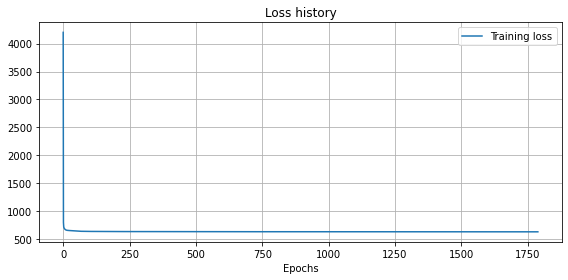

In [29]:
rand_seed = 0
fig = plt.figure(figsize=(9, 2.5))
for key in params_sk.keys():
    model_name=key
    out_dir='output/checkpoint/'
    tag = out_dir + model_name[0] + '_sk_new2_' + str(rand_seed)
    csv_fname = tag + '_history.csv'
    df_hist = pd.read_csv(csv_fname, index_col=0)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.set_title(fr'Loss history')
    ax.plot(df_hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()


In [67]:
alpha = params_sk['alphatrnn']['model'].predict(x_train_reg)
# mu = alpha[:,0]*dt
# sigma = np.exp(-alpha[:,1]/2)*np.sqrt(dt)
mu = alpha[:,0]*dt*X1_std[0]+X1_mean[0]
sigma = np.exp(-alpha[:,1]/2)*X1_std[0]*np.sqrt(dt)

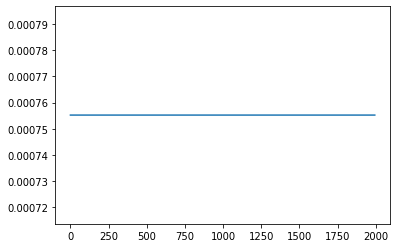

In [68]:
plt.plot(mu)

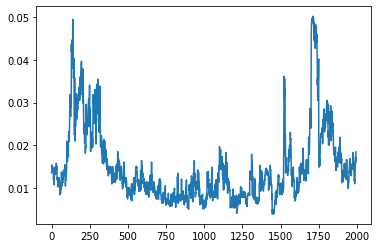

In [69]:
plt.plot(sigma)

0.0002895116

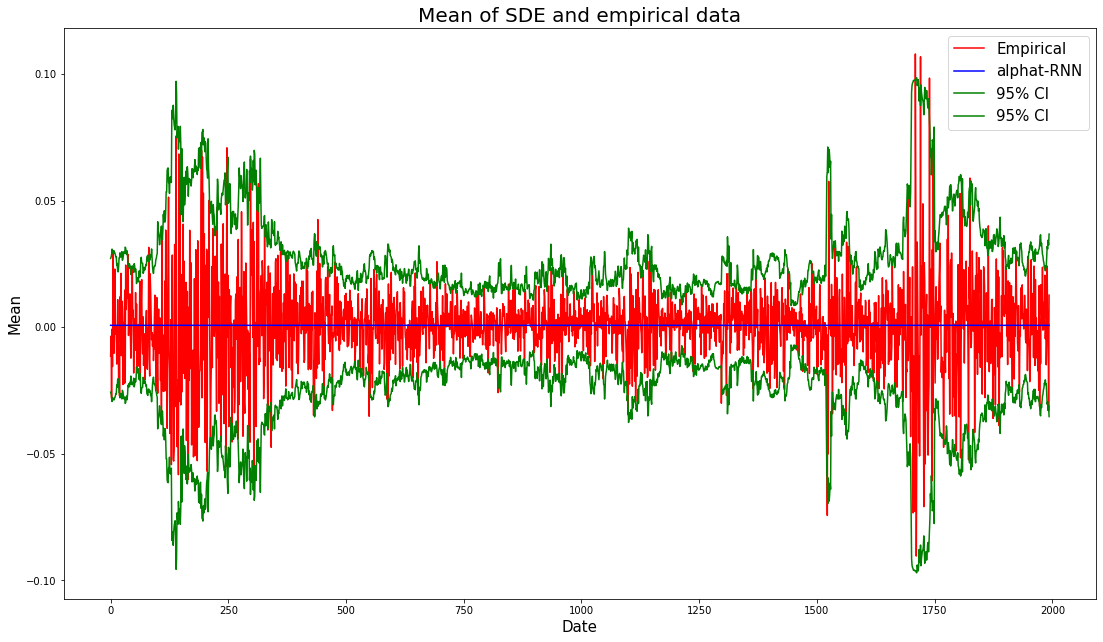

In [70]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_train_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu,color='blue',label='alphat-RNN')
plt.plot(mu+1.95*sigma,color='green',label='95% CI')
plt.plot(mu-1.95*sigma,color='green',label='95% CI')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

np.mean((y_train_reg*X1_std[0]+X1_mean[0]-mu)**2)

In [71]:
res = y_train_reg*X1_std[0]+X1_mean[0]-mu

adf, p, usedlag, nobs, cvs,aic = sm.tsa.stattools.adfuller(res)
print(adf,p)

adf2, p2, usedlag2, nobs2, cvs2,aic2 = sm.tsa.stattools.adfuller(res**2)
print(adf2,p2)

-21.243822908638407 0.0
-4.341820498579316 0.00037569462928674927


In [72]:
alpha_test = params_sk['alphatrnn']['model'].predict(x_test_reg)
# mu_test = alpha_test[:,0]*dt
# sigma_test = np.exp(-alpha_test[:,1]/2)*np.sqrt(dt)
mu_test = alpha_test[:,0]*dt*X1_std[0]+X1_mean[0]
sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]*np.sqrt(dt)

In [ ]:
mu_test1 = alpha_test[:,0]*dt
sigma_test1 = np.exp(-alpha_test[:,1]/2)*np.sqrt(dt)
RNN_test = {'mu':mu_test1,'sigma':sigma_test1}
RNN_test = pd.DataFrame(RNN_test)
RNN_test.to_csv("RNN_test3.csv",index=False,header=True)

0.00017425475838107302
0.011629171


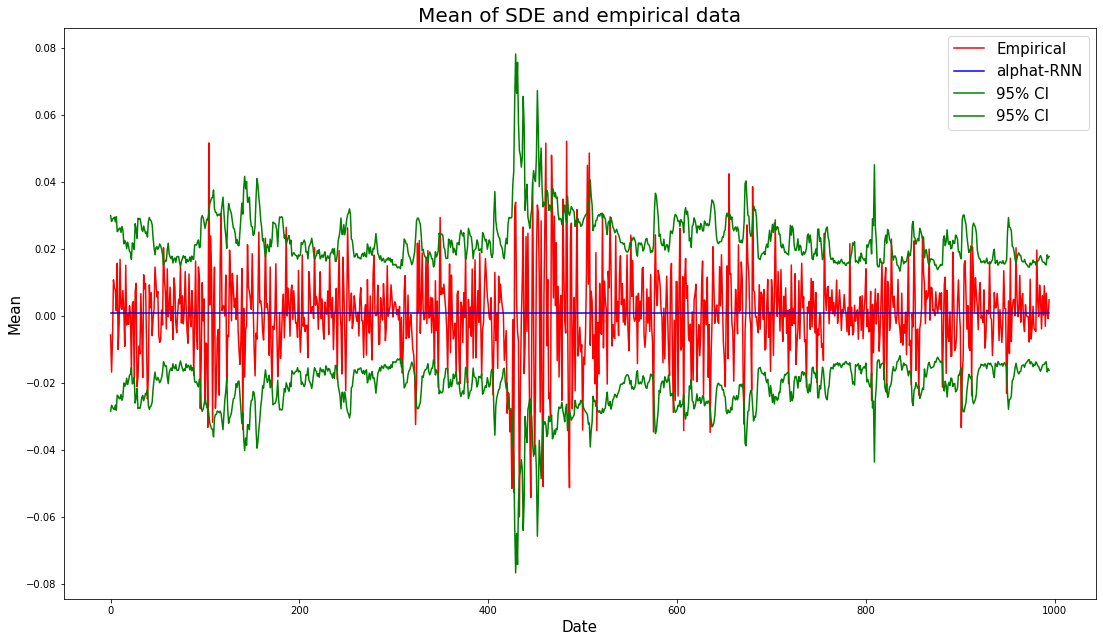

In [73]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_test,color='blue',label='alphat-RNN')
plt.plot(mu_test+1.95*sigma_test,color='green',label='95% CI')
plt.plot(mu_test-1.95*sigma_test,color='green',label='95% CI')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

print(np.mean((y_test_reg*X1_std[0]+X1_mean[0]-mu_test)**2))
print(np.mean(sigma_test))

In [74]:
from scipy.stats import norm, binom, chi2

quantile = 0.95
refit = 252
test_num = y_test_reg.shape[0]
refit_times = test_num//refit + (test_num%refit > 0)

for key in params_sk.keys():
  model_temp = AlphatRNN_(params_sk[key]['H'],params_sk[key]['D'],params_sk[key]['l1_reg'])
  rand_seed = 0

  model_name=key
  out_dir='output/checkpoint/'

  pruning_dir = out_dir + 'pruning_summary/'
  
  mu_result = np.array([0])
  sigma_result = np.array([0])
  for k in range(refit_times):
    end = np.minimum(test_num,k*refit)
    x_train_reg_temp = np.concatenate((x_train_reg,x_test_reg[0:end,:,:]),axis=0) 
    y_train_reg_temp = np.concatenate((y_train_reg,y_test_reg[0:end]),axis=0) 
    x_test_reg_temp = x_test_reg[end:np.minimum(end+refit,test_num),:,:]
    y_test_reg_temp = y_test_reg[end:np.minimum(end+refit,test_num)]
    if k == 0:
      tag = out_dir + model_name[0] + '_sk_new2_' + str(rand_seed)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'
      model_temp.load_weights(checkpoint_filepath)
    else:
      tag = out_dir + model_name[0] + '_sk_new2_' + str(rand_seed)+ '_' + str(k)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'

      pruning_dir = out_dir + 'pruning_summary/'
      
      if not os.path.exists(pruning_dir):
        os.makedirs(pruning_dir)
      # train the pruned model
      tf.random.set_seed(rand_seed)
      if glob(checkpoint_filepath_all):
        model_temp.load_weights(checkpoint_filepath)
      else:
        model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
        csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
        history = model_temp.fit(x_train_reg_temp,y_train_reg_temp,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    alpha_test = model_temp.predict(x_test_reg_temp)
    mu_test = alpha_test[:,0]*dt*X1_std[0]+X1_mean[0]
    sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]*np.sqrt(dt)
    mu_result = np.concatenate((mu_result,mu_test),axis=0)
    sigma_result = np.concatenate((sigma_result,sigma_test),axis=0)


mu_result = mu_result[1:]
sigma_result = sigma_result[1:]


  

In [38]:
quantile = 0.99
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

0.011859800265348164
3.0
20.0


In [39]:
VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,) > VaR_all.reshape(-1,))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

21
0.021105527638190954


In [40]:
!pip install vartests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.3/907.3 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.3/912.3 KB 39.3 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.4.1 which is incompatible.


In [41]:
import vartests as vr

vr.duration_test(avg_all, conf_level=quantile)

0.2.0.1
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


{'weibull exponential': array([0.85087956]),
 'unrestricted log-likelihood': array([-96.77258084]),
 'restricted log-likelihood': array([-97.23568666]),
 'log-likelihood': array([0.92621164]),
 'log-likelihood ratio test statistic': array([0.33584927]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [42]:
quantile = 0.975
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,) > VaR_all.reshape(-1,))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

vr.duration_test(avg_all, conf_level=quantile)

0.027030084935096843
15.0
38.0
35
0.035175879396984924
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


{'weibull exponential': array([1.03783459]),
 'unrestricted log-likelihood': array([-147.22331952]),
 'restricted log-likelihood': array([-147.25930678]),
 'log-likelihood': array([0.07197454]),
 'log-likelihood ratio test statistic': array([0.78848326]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [43]:
quantile = 0.95
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,) > VaR_all.reshape(-1,))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

vr.duration_test(avg_all, conf_level=quantile)

0.04668418181766476
37.0
65.0
64
0.06432160804020101
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


{'weibull exponential': array([1.01944322]),
 'unrestricted log-likelihood': array([-233.98614711]),
 'restricted log-likelihood': array([-234.00605845]),
 'log-likelihood': array([0.03982267]),
 'log-likelihood ratio test statistic': array([0.8418277]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [44]:
quantile = 0.925
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,) > VaR_all.reshape(-1,))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

vr.duration_test(avg_all, conf_level=quantile)

0.06494994876194982
60.0
91.0
85
0.08542713567839195
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


{'weibull exponential': array([1.03206033]),
 'unrestricted log-likelihood': array([-287.76679823]),
 'restricted log-likelihood': array([-287.84278384]),
 'log-likelihood': array([0.15197122]),
 'log-likelihood ratio test statistic': array([0.69665866]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [45]:
quantile = 0.9
lower_bd = binom.ppf((1-quantile)/2, test_num, 1-quantile)
upper_bd = binom.ppf(1-(1-quantile)/2, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,) > VaR_all.reshape(-1,))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

vr.duration_test(avg_all, conf_level=quantile)

0.09242574045236507
84.0
116.0
97
0.09748743718592964
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


{'weibull exponential': array([1.07616274]),
 'unrestricted log-likelihood': array([-315.6883069]),
 'restricted log-likelihood': array([-316.14416784]),
 'log-likelihood': array([0.91172189]),
 'log-likelihood ratio test statistic': array([0.33965796]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

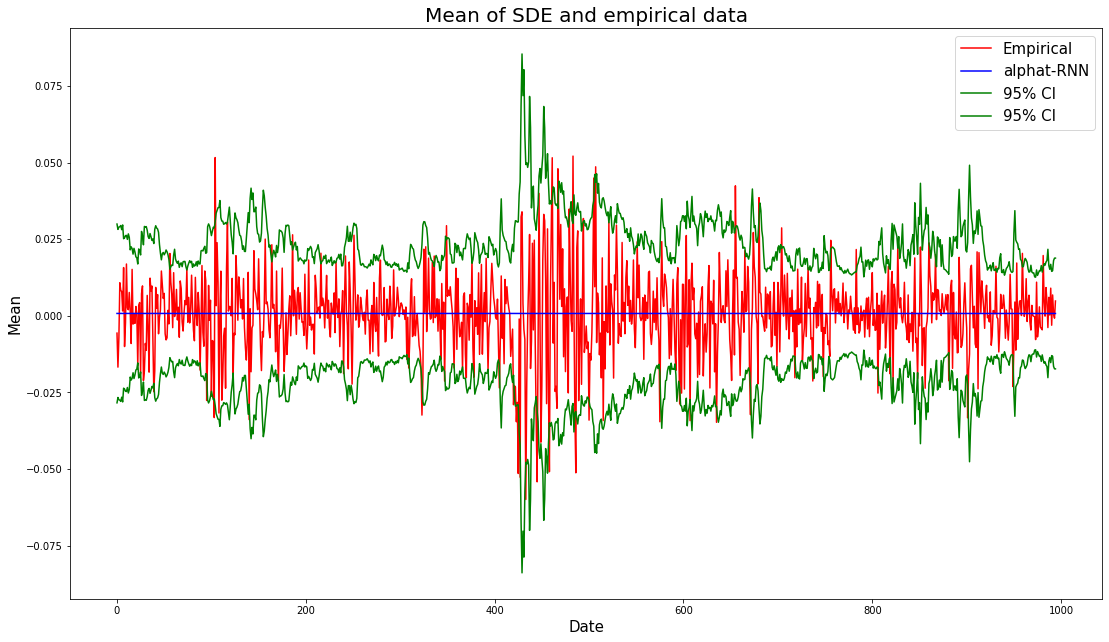

In [75]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_result,color='blue',label='alphat-RNN')
plt.plot(mu_result+1.95*sigma_result,color='green',label='95% CI')
plt.plot(mu_result-1.95*sigma_result,color='green',label='95% CI')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

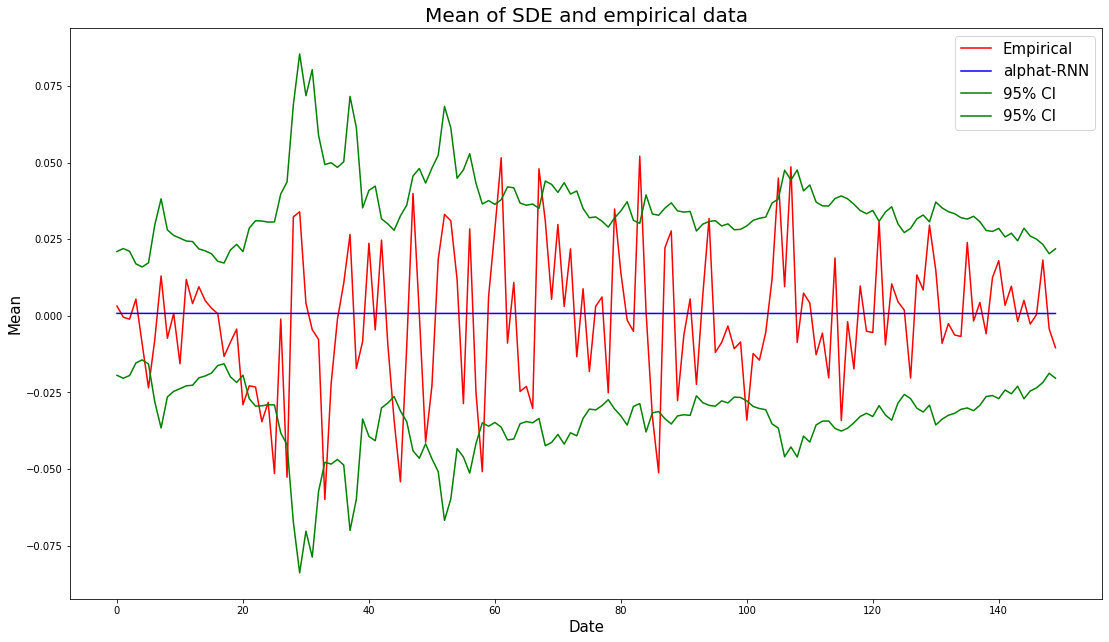

In [47]:
start = 400
end = 550
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg[start:end]*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_result[start:end],color='blue',label='alphat-RNN')
plt.plot(mu_result[start:end]+1.95*sigma_result[start:end],color='green',label='95% CI')
plt.plot(mu_result[start:end]-1.95*sigma_result[start:end],color='green',label='95% CI')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

In [76]:
sigma_RNN = {'sigma':sigma_result}
sigma_RNN = pd.DataFrame(sigma_RNN)
sigma_RNN.to_csv("sigma_RNN.csv",index=False,header=True)

# Dynamic of factors
1) alpha-RNN with MSE;
2) (possible) alpha-RNN with NSDE# New Section.

In [10]:
use_features1_factor = ['Comp 1','Comp 2','Comp 3']
use_features2_factor = ['Comp 1.1','Comp 2.1','Comp 3.1','Comp 4','Comp 5']
n_steps_all = []
for feature in use_features1_factor:
  pacf=sm.tsa.stattools.pacf(X_train1[feature], nlags=30)
  n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(X_train1[feature])))==False)[0][0] -1
  n_steps_all.append(n_steps)
for feature in use_features2_factor:
  pacf=sm.tsa.stattools.pacf(X_train2[feature], nlags=30)
  n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(X_train2[feature])))==False)[0][0] -1
  n_steps_all.append(n_steps)
n_steps = np.max(n_steps_all)
print(n_steps_all)

[2, 2, 2, 2, 5, 6, 2, 2]


In [11]:
X_train1_factor = X_train1[use_features1_factor]
X_train2_factor = X_train2[use_features2_factor]
X_test1_factor = X_test1[use_features1_factor]
X_test2_factor = X_test2[use_features2_factor]

In [12]:
n_steps_ahead = 1
n_steps1 = n_steps

target1 = ['Comp 1','Comp 2','Comp 3']
target2 = ['Comp 1.1','Comp 2.1','Comp 3.1','Comp 4','Comp 5']

# For R
x_train_list1_factor = []
for use_feature in use_features1_factor:
    x_train_reg1_factor = get_lagged_features(X_train1_factor, n_steps1, n_steps_ahead).dropna()
    x_train_list1_factor.append(x_train_reg1_factor)
x_train_reg1_factor = pd.concat(x_train_list1_factor, axis=1)

col_ords1 = []
for i in range(n_steps1):
    for j in range(len(use_features1_factor)):
        col_ords1.append(j + i * len(use_features1_factor))


x_train_reg1_factor = x_train_reg1_factor.iloc[:, col_ords1]
y_train_reg1_factor = X_train1_factor.loc[x_train_reg1_factor.index, target1].values
x_train_reg1_factor = np.reshape(x_train_reg1_factor.values, (x_train_reg1_factor.shape[0], np.int(x_train_reg1_factor.shape[1] / len(use_features1_factor)), len(use_features1_factor)))
y_train_reg1_factor = np.reshape(y_train_reg1_factor, (y_train_reg1_factor.shape[0], y_train_reg1_factor.shape[1], 1))

x_test_list1_factor = []
for use_feature in use_features1_factor:
    x_test_reg1_factor = get_lagged_features(X_test1_factor, n_steps1,n_steps_ahead).dropna()
    x_test_list1_factor.append(x_test_reg1_factor)
x_test_reg1_factor = pd.concat(x_test_list1_factor, axis=1)

x_test_reg1_factor = x_test_reg1_factor.iloc[:, col_ords1]
y_test_reg1_factor = X_test1_factor.loc[x_test_reg1_factor.index, target1].values
x_test_reg1_factor = np.reshape(x_test_reg1_factor.values, (x_test_reg1_factor.shape[0], np.int(x_test_reg1_factor.shape[1]/len(use_features1_factor)), len(use_features1_factor)))

y_test_reg1_factor = np.reshape(y_test_reg1_factor, (y_test_reg1_factor.shape[0], y_test_reg1_factor.shape[1], 1))

# For R^2
x_train_list2_factor = []
for use_feature in use_features2_factor:
    x_train_reg2_factor = get_lagged_features(X_train2_factor, n_steps, n_steps_ahead).dropna()
    x_train_list2_factor.append(x_train_reg2_factor)
x_train_reg2_factor = pd.concat(x_train_list2_factor, axis=1)

col_ords2 = []
for i in range(n_steps):
    for j in range(len(use_features2_factor)):
        col_ords2.append(j + i * len(use_features2_factor))

x_train_reg2_factor = x_train_reg2_factor.iloc[:, col_ords2]
y_train_reg2_factor = X_train2.loc[x_train_reg2_factor.index, target2].values
x_train_reg2_factor = np.reshape(x_train_reg2_factor.values, (x_train_reg2_factor.shape[0], np.int(x_train_reg2_factor.shape[1] / len(use_features2_factor)), len(use_features2_factor)))
y_train_reg2_factor = np.reshape(y_train_reg2_factor, (y_train_reg2_factor.shape[0], y_train_reg2_factor.shape[1], 1))

x_test_list2_factor = []
for use_feature in use_features2_factor:
    x_test_reg2_factor = get_lagged_features(X_test2_factor, n_steps,n_steps_ahead).dropna()
    x_test_list2_factor.append(x_test_reg2_factor)
x_test_reg2_factor = pd.concat(x_test_list2_factor, axis=1)

x_test_reg2_factor = x_test_reg2_factor.iloc[:, col_ords2]
y_test_reg2_factor = X_test2_factor.loc[x_test_reg2_factor.index, target2].values
x_test_reg2_factor = np.reshape(x_test_reg2_factor.values, (x_test_reg2_factor.shape[0], np.int(x_test_reg2_factor.shape[1]/len(use_features2_factor)), len(use_features2_factor)))

y_test_reg2_factor = np.reshape(y_test_reg2_factor, (y_test_reg2_factor.shape[0], y_test_reg2_factor.shape[1], 1))

y_test_reg1_factor = np.squeeze(y_test_reg1_factor)
y_train_reg1_factor = np.squeeze(y_train_reg1_factor)
y_test_reg2_factor = np.squeeze(y_test_reg2_factor)
y_train_reg2_factor = np.squeeze(y_train_reg2_factor)

<ipython-input-12-970216f336ff>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train_reg1_factor = np.reshape(x_train_reg1_factor.values, (x_train_reg1_factor.shape[0], np.int(x_train_reg1_factor.shape[1] / len(use_features1_factor)), len(use_features1_factor)))
<ipython-input-12-970216f336ff>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` 

In [13]:
y_train_reg1_factor = np.concatenate((X_train1_factor.to_numpy()[n_steps-1,:].reshape(1,-1),y_train_reg1_factor),axis=0)
y_train_reg2_factor = np.concatenate((X_train2_factor.to_numpy()[n_steps-1,:].reshape(1,-1),y_train_reg2_factor),axis=0)
y_train_reg1_factor = np.diff(y_train_reg1_factor,axis=0)
y_train_reg2_factor = np.diff(y_train_reg2_factor,axis=0)
y_test_reg1_factor = np.concatenate((X_test1_factor.to_numpy()[n_steps-1,:].reshape(1,-1),y_test_reg1_factor),axis=0)
y_test_reg2_factor = np.concatenate((X_test2_factor.to_numpy()[n_steps-1,:].reshape(1,-1),y_test_reg2_factor),axis=0)
y_test_reg1_factor = np.diff(y_test_reg1_factor,axis=0)
y_test_reg2_factor = np.diff(y_test_reg2_factor,axis=0)

In [14]:
X_test1_factor.head(10)

Comp 1    Comp 2    Comp 3
1519  0.029203 -1.428057  1.064069
1520 -0.482802 -0.584011 -0.150846
1521 -0.467644 -0.907500 -0.670950
1522 -0.426217 -0.945618 -0.086607
1523 -0.510795 -0.819939 -0.513157
1524 -0.351169 -1.174397  0.320555
1525 -0.143927 -1.427952  0.939646
1526 -0.199042 -1.380772  0.919719
1527  0.019602 -1.697313  1.782086
1528  0.029005 -1.787208  1.642281

In [15]:
x_train_reg1_factor[0:3,:,:]

array([[[ 1.87950844,  0.18796357, -3.19038109],
        [ 1.95915967,  0.10459169, -2.74533761],
        [ 1.86064892,  0.26208657, -2.65820492],
        [ 2.09236824, -0.09811087, -2.32148146],
        [ 2.27808477, -0.22250112, -2.22572161],
        [ 2.38932411, -0.24440799, -2.46043019]],

       [[ 1.95915967,  0.10459169, -2.74533761],
        [ 1.86064892,  0.26208657, -2.65820492],
        [ 2.09236824, -0.09811087, -2.32148146],
        [ 2.27808477, -0.22250112, -2.22572161],
        [ 2.38932411, -0.24440799, -2.46043019],
        [ 2.46088188, -0.4128029 , -2.49136202]],

       [[ 1.86064892,  0.26208657, -2.65820492],
        [ 2.09236824, -0.09811087, -2.32148146],
        [ 2.27808477, -0.22250112, -2.22572161],
        [ 2.38932411, -0.24440799, -2.46043019],
        [ 2.46088188, -0.4128029 , -2.49136202],
        [ 2.64043677, -0.1827156 , -2.36115428]]])

In [16]:
y_train_reg1_factor[0:3,:]

array([[ 0.07155777, -0.16839492, -0.03093183],
       [ 0.17955489,  0.2300873 ,  0.13020773],
       [ 0.59853235, -0.43864928,  0.97622222]])

In [17]:
y_test_reg1_factor[0:3,:]

array([[ 0.2072422 , -0.25355429,  0.61909095],
       [-0.05511517,  0.04717947, -0.01992666],
       [ 0.21864402, -0.31654031,  0.86236663]])

In [18]:
print(x_train_reg1_factor.shape,y_train_reg1_factor.shape,x_test_reg1_factor.shape,y_test_reg1_factor.shape)
print(x_train_reg2_factor.shape,y_train_reg2_factor.shape,x_test_reg2_factor.shape,y_test_reg2_factor.shape)

(1513, 6, 3) (1513, 3) (994, 6, 3) (994, 3)
(1513, 6, 5) (1513, 5) (994, 6, 5) (994, 5)


In [19]:
dim1 = y_train_reg1_factor.shape[1]
dim1m = int(dim1*(dim1+1)/2)
dim2 = y_train_reg2_factor.shape[1]
dim2m = int(dim2*(dim2+1)/2)

mask1 = tf.eye(dim1,dtype=tf.dtypes.float32)
mask2 = tf.eye(dim2,dtype=tf.dtypes.float32)

In [20]:
class Loss(object):
  def loss_lnS(y_true, y_pred):
    alpha = y_pred[:,0]
    gamma = y_pred[:,1]
    dX = y_true
            
    # compute log-likelihood
    l = tf.reduce_sum(-gamma + tf.square(dX - (alpha)*dt)*tf.exp(gamma)/dt )
    return l
  
  def loss_lnS_std(y_true,y_pred):
    alpha = y_pred[:,0]
    gamma = y_pred[:,1]

    nu = tf.reduce_mean(tf.square(y_pred[:,2]))
    nu = tf.cast(nu,tf.float32)
    # nu = tf.math.maximum(1,nu)
    
    dX = y_true

    l = tf.reduce_sum(-gamma + (nu+1)*tf.math.log(1+tf.square(dX - alpha)*tf.exp(gamma)/nu) +2*tf.math.lgamma(nu/2)-2*tf.math.lgamma((nu+1)/2)+tf.math.log(nu))

    return l
  
  def loss_lnS_MD(y_true,y_pred):
    alpha = y_pred[:,0]
    gamma = y_pred[:,1]

    dX = y_true

    l = tf.reduce_sum( tf.square(dX - (alpha)*dt)*tf.exp(gamma)/dt )

    return l

  def loss_lnS_sigma(y_true,y_pred):

    l = tf.reduce_sum(-y_pred + tf.square(y_true)*tf.exp(y_pred)/dt )

    return l

  def loss_R(y_true,y_pred):
    
    mu = y_pred[:,0:dim1]*dt
    P = y_pred[:,-dim1m:] 
    
    sigma = tfp.math.fill_triangular(P)
    mask1 = tf.eye(sigma.shape[1],dtype=tf.dtypes.float32)
    D = tf.math.multiply(sigma,mask1)

    D_exp = tf.exp(D)
    D_exp = tf.math.multiply(D_exp,mask1)
    sigma = sigma-D+D_exp


    l1 = 2*tf.reduce_sum(D)
    sigma_inv = tf.linalg.inv(sigma)
    u = y_true-mu
    u = tf.reshape(u,[tf.shape(u)[0],tf.shape(u)[1],1])
    u1 = tf.linalg.matmul(sigma_inv,u)
    l2 = tf.reduce_sum(tf.square(u1))/dt

    l = l1+l2
    return l

  def loss_R2(y_true,y_pred):
    
    mu = y_pred[:,0:dim2]*dt
    P = y_pred[:,-dim2m:] 
    
    sigma = tfp.math.fill_triangular(P)
    mask2 = tf.eye(sigma.shape[1],dtype=tf.dtypes.float32)
    D = tf.math.multiply(sigma,mask2)

    D_exp = tf.exp(D)
    D_exp = tf.math.multiply(D_exp,mask1)
    sigma = sigma-D+D_exp


    l1 = 2*tf.reduce_sum(D)
    sigma_inv = tf.linalg.inv(sigma)
    u = y_true-mu
    u = tf.reshape(u,[tf.shape(u)[0],tf.shape(u)[1],1])
    u1 = tf.linalg.matmul(sigma_inv,u)
    l2 = tf.norm(u1)**2/dt

    l = l1+l2
    return l

In [21]:
def AlphaRNN_R_(n_units = 10, d_units=64, l1_reg=0, seed=1000, dt=dt):
  inputs = Input(shape=(x_train_reg1_factor.shape[1],x_train_reg1_factor.shape[2]))
  x1 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg1_factor.shape[1], x_train_reg1_factor.shape[-1]), unroll=True)(inputs)
  x2 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg1_factor.shape[1], x_train_reg1_factor.shape[-1]), unroll=True)(inputs)
  x1 = Dense(d_units,activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  x2 = Dense(d_units,activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out1 = Dense(dim1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  out2 = Dense(dim1m, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out =  Lambda(lambda x :K.concatenate(x,1))([out1,out2])
  Mymodel = Model(inputs=inputs,outputs=out)

  Mymodel.compile(loss=Loss.loss_R,optimizer='adam' )
  return Mymodel

In [139]:
def custom_loss_function_R(y_true, y_pred):
  mu = (y_pred[:,0:dim1]*dt).astype('float32')
  P = y_pred[:,-dim1m:].astype('float32')
    
  sigma = tfp.math.fill_triangular(P)
  mask1 = tf.eye(sigma.shape[1],dtype=tf.dtypes.float32)
  D = tf.math.multiply(sigma,mask1)

  D_exp = tf.exp(D)
  D_exp = tf.math.multiply(D_exp,mask1)
  sigma = sigma-D+D_exp

  l1 = 2*np.sum(D)
  sigma_inv = tf.linalg.inv(sigma)
  u = y_true-mu
  u = tf.reshape(u,[tf.shape(u)[0],tf.shape(u)[1],1])
  u1 = tf.linalg.matmul(sigma_inv,u)
  l2 = np.sum(u1**2)/dt

  score = -l1-l2
  
  return score

scorer_R = make_scorer(custom_loss_function_R, greater_is_better=True)

In [22]:
x_train_reg1_factor = x_train_reg1_factor.astype('float32')
y_train_reg1_factor = y_train_reg1_factor.astype('float32')

In [23]:
params_R = {'alpharnn_R': {'model':'', 'function':AlphaRNN_R_,'l1_reg':0.0, 'H':10, 'D':64,'color': 'green', 'label': '$\\alpha$-RNN_R' }}
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=0.1, restore_best_weights=True)

In [24]:
max_epoches = 6000
batch_size = 10

In [144]:
mm = AlphaRNN_R_(n_units = 10, d_units=4, l1_reg=0, seed=0, dt=dt)
mm.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 6, 3)         0                                            
__________________________________________________________________________________________________
alpha_rnn_53 (AlphaRNN)         (None, 10)           141         input_27[0][0]                   
__________________________________________________________________________________________________
alpha_rnn_54 (AlphaRNN)         (None, 10)           141         input_27[0][0]                   
__________________________________________________________________________________________________
dense_105 (Dense)               (None, 4)            44          alpha_rnn_53[0][0]               
___________________________________________________________________________________________

In [145]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [5,10,20]
    l1_reg = [0.001, 0.01, 0.1]
    d_units = [4,16,64]

    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,d_units=d_units,l1_reg=l1_reg)

    for key in params_R.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params_R[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scorer_R,error_score="raise",cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg1_factor,y_train_reg1_factor,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params_R[key]['H'] = grid_result.best_params_['n_units']
        params_R[key]['l1_reg']= grid_result.best_params_['l1_reg']
        params_R[key]['D']= grid_result.best_params_['d_units']

        joblib.dump(grid, key + 'grid_R1.pkl')

Streaming output truncated to the last 5000 lines.
 - 0s - loss: 117.9916
Epoch 200/6000
 - 0s - loss: 117.5661
Epoch 201/6000
 - 0s - loss: 117.6618
Epoch 202/6000
 - 0s - loss: 117.2991
Epoch 203/6000
 - 0s - loss: 117.2817
Epoch 204/6000
 - 0s - loss: 116.9790
Epoch 205/6000
 - 0s - loss: 116.8476
Epoch 206/6000
 - 0s - loss: 116.7947
Epoch 207/6000
 - 0s - loss: 115.9783
Epoch 208/6000
 - 0s - loss: 116.8087
Epoch 209/6000
 - 0s - loss: 116.6462
Epoch 210/6000
 - 0s - loss: 116.5250
Epoch 211/6000
 - 0s - loss: 116.1479
Epoch 212/6000
 - 0s - loss: 116.0601
Epoch 213/6000
 - 0s - loss: 116.0466
Epoch 214/6000
 - 0s - loss: 116.1005
Epoch 215/6000
 - 0s - loss: 115.3930
Epoch 216/6000
 - 0s - loss: 115.7285
Epoch 217/6000
 - 0s - loss: 115.5475
Epoch 218/6000
 - 0s - loss: 115.4243
Epoch 219/6000
 - 0s - loss: 115.3457
Epoch 220/6000
 - 0s - loss: 115.3843
Epoch 221/6000
 - 0s - loss: 114.9927
Epoch 222/6000
 - 0s - loss: 115.0293
Epoch 223/6000
 - 0s - loss: 114.5902
Epoch 224/6000

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Restoring model weights from the end of the best epoch
Epoch 00208: early stopping
Best: -2314.962792 using {'d_units': 16, 'l1_reg': 0.001, 'n_units': 5}
-2379.430822 (251.222891) with {'d_units': 4, 'l1_reg': 0.001, 'n_units': 5}
-2446.206169 (359.938116) with {'d_units': 4, 'l1_reg': 0.001, 'n_units': 10}
-3084.689491 (832.806052) with {'d_units': 4, 'l1_reg': 0.001, 'n_units': 20}
-4462.227740 (4218.123106) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 5}
-2380.597519 (224.955502) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 10}
-2532.123156 (483.971323) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 20}
-2431.019645 (309.606950) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 5}
-2413.702627 (317.731810) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 10}
-2581.813031 (619.209271) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 20}
-2314.962792 (205.889998) with {'d_units': 16, 'l1_reg': 0.001, 'n_units': 5}
-2786.351808 (825.249839) with {'d_units': 16, 'l1_reg': 0.001, 'n_units': 1

OSError: ignored

In [ ]:
# Best: -2314.962792 using {'d_units': 16, 'l1_reg': 0.001, 'n_units': 5}
# -2379.430822 (251.222891) with {'d_units': 4, 'l1_reg': 0.001, 'n_units': 5}
# -2446.206169 (359.938116) with {'d_units': 4, 'l1_reg': 0.001, 'n_units': 10}
# -3084.689491 (832.806052) with {'d_units': 4, 'l1_reg': 0.001, 'n_units': 20}
# -4462.227740 (4218.123106) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 5}
# -2380.597519 (224.955502) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 10}
# -2532.123156 (483.971323) with {'d_units': 4, 'l1_reg': 0.01, 'n_units': 20}
# -2431.019645 (309.606950) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 5}
# -2413.702627 (317.731810) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 10}
# -2581.813031 (619.209271) with {'d_units': 4, 'l1_reg': 0.1, 'n_units': 20}
# -2314.962792 (205.889998) with {'d_units': 16, 'l1_reg': 0.001, 'n_units': 5}
# -2786.351808 (825.249839) with {'d_units': 16, 'l1_reg': 0.001, 'n_units': 10}
# -3731.910383 (1845.107571) with {'d_units': 16, 'l1_reg': 0.001, 'n_units': 20}
# -2355.221130 (292.197169) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 5}
# -2424.068159 (379.123810) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 10}
# -3906.393735 (2614.415116) with {'d_units': 16, 'l1_reg': 0.01, 'n_units': 20}
# -3299.634546 (1753.427026) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 5}
# -2376.299021 (394.994203) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 10}
# -2343.109652 (285.033082) with {'d_units': 16, 'l1_reg': 0.1, 'n_units': 20}
# -2412.254001 (396.142468) with {'d_units': 64, 'l1_reg': 0.001, 'n_units': 5}
# -2580.276461 (421.231832) with {'d_units': 64, 'l1_reg': 0.001, 'n_units': 10}
# -2752.771948 (728.242126) with {'d_units': 64, 'l1_reg': 0.001, 'n_units': 20}
# -2585.129454 (676.654727) with {'d_units': 64, 'l1_reg': 0.01, 'n_units': 5}
# -2579.638954 (399.867331) with {'d_units': 64, 'l1_reg': 0.01, 'n_units': 10}
# -2988.492291 (993.308292) with {'d_units': 64, 'l1_reg': 0.01, 'n_units': 20}
# -2363.388082 (289.894089) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 5}
# -2415.026298 (241.859812) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 10}
# -2408.157281 (441.538457) with {'d_units': 64, 'l1_reg': 0.1, 'n_units': 20}

In [25]:
params_R['alpharnn_R']['l1_reg'] = 0.001
params_R['alpharnn_R']['D'] = 16
params_R['alpharnn_R']['H'] = 5

In [27]:
# Rnew1: l1_reg: 0.001, H: 10, D = 16 (2lags)
# Rnew2: l1_reg: 0.001, H: 5, D = 16 (2lags)
from keras.callbacks.callbacks import ModelCheckpoint, CSVLogger

for key in params_R.keys():
  rand_seed = 0
  tf.compat.v1.set_random_seed(rand_seed)
  model=params_R[key]['function'](params_R[key]['H'],params_R[key]['D'],params_R[key]['l1_reg'])

  model_name=key
  out_dir='output/checkpoint/'

  tag = out_dir + model_name + '_Rnew2_' + str(rand_seed)
  checkpoint_filepath = tag
  checkpoint_filepath_all = tag + '*'
  csv_fname = tag + '_history.csv'

  pruning_dir = out_dir + 'pruning_summary/'
  if not os.path.exists(pruning_dir):
    os.makedirs(pruning_dir)

  # train the pruned model
  tf.random.set_seed(rand_seed)
  if glob(checkpoint_filepath_all):
    model.load_weights(checkpoint_filepath)
  else:
    model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
    csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
    
    history = model.fit(x_train_reg1_factor,y_train_reg1_factor,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    # plot training loss history
    plot_fname = tag + '_history.png'
    hist = pd.DataFrame(history.history)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()

    plt.savefig(plot_fname, dpi=500)
    plt.close()
  params_R[key]['model']=model


Epoch 1/6000
1513/1513 [==============================] - 3s 2ms/step - loss: 17605.5303
Epoch 2/6000
1513/1513 [==============================] - 1s 686us/step - loss: 6315.5623
Epoch 3/6000
1513/1513 [==============================] - 2s 1ms/step - loss: 3648.0568
Epoch 4/6000
1513/1513 [==============================] - 1s 909us/step - loss: 2461.2101
Epoch 5/6000
1513/1513 [==============================] - 1s 881us/step - loss: 1803.4628
Epoch 6/6000
1513/1513 [==============================] - 1s 859us/step - loss: 1392.7877
Epoch 7/6000
1513/1513 [==============================] - 1s 856us/step - loss: 1115.9442
Epoch 8/6000
1513/1513 [==============================] - 1s 876us/step - loss: 918.9241
Epoch 9/6000
1513/1513 [==============================] - 1s 884us/step - loss: 772.7677
Epoch 10/6000
1513/1513 [==============================] - 1s 909us/step - loss: 661.0421
Epoch 11/6000
1513/1513 [==============================] - 1s 964us/step - loss: 573.3730
Epoch 12/6000
1

<Figure size 648x180 with 0 Axes>

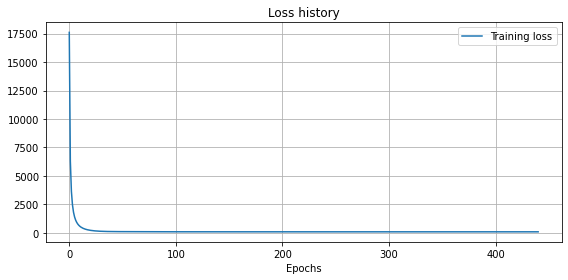

In [28]:
rand_seed = 0
fig = plt.figure(figsize=(9, 2.5))
for key in params_R.keys():
    model_name=key
    out_dir='output/checkpoint/'
    tag = out_dir + model_name + '_Rnew2_' + str(rand_seed)
    csv_fname = tag + '_history.csv'
    df_hist = pd.read_csv(csv_fname, index_col=0)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.set_title(fr'Loss history')
    ax.plot(df_hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()


In [30]:
alpha_R = params_R['alpharnn_R']['model'].predict(x_train_reg1_factor)
mu = (alpha_R[:,0:dim1]*dt).astype('float32')
P = alpha_R[:,-dim1m:].astype('float32')
    
sigma = tfp.math.fill_triangular(P)
mask1 = tf.eye(sigma.shape[1],dtype=tf.dtypes.float32)
D = tf.math.multiply(sigma,mask1)

D_exp = tf.exp(D)
D_exp = tf.math.multiply(D_exp,mask1)
sigma = sigma-D+D_exp
sigma = sigma.numpy()
diff = (mu - y_train_reg1_factor)**2
np.mean(diff,0)

array([0.02940122, 0.05346787, 0.18300635], dtype=float32)

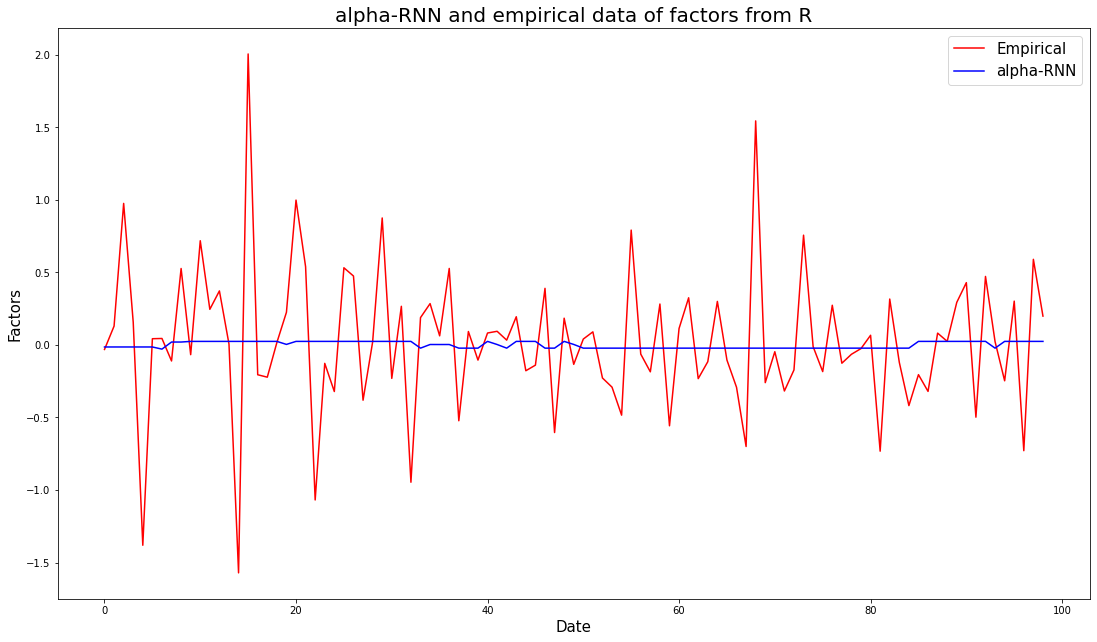

In [32]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_train_reg1_factor[0:99,2],color='red',label='Empirical')
plt.plot(mu[1:100,2],color='blue',label='alpha-RNN')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Factors',fontsize=15)
plt.title('alpha-RNN and empirical data of factors from R',fontsize=20)
plt.legend(fontsize=15)

In [218]:
alpha_R_test = params_R['alpharnn_R']['model'].predict(x_test_reg1_factor)
diff_test = (alpha_R_test[1:alpha_R_test.shape[0],:] - y_test_reg1_factor[0:(y_test_reg1_factor.shape[0]-1),:])**2
np.mean(diff_test,0)

array([0.01427204, 0.0379104 , 0.14929351])

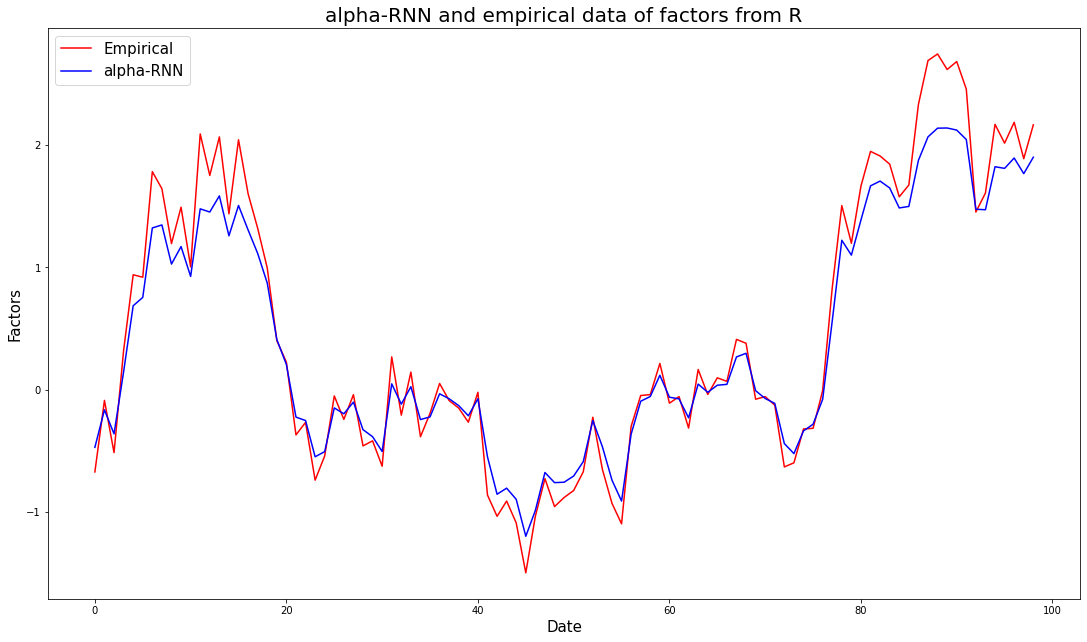

In [217]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg1_factor[0:99,2],color='red',label='Empirical')
plt.plot(alpha_R_test[1:100,2],color='blue',label='alpha-RNN')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Factors',fontsize=15)
plt.title('alpha-RNN and empirical data of factors from R',fontsize=20)
plt.legend(fontsize=15)

In [44]:
def AlphaRNN_R2_(n_units = 10, dense_units=64, l1_reg=0, seed=0,dt=dt):
  Mymodel = Sequential()
  Mymodel.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg2_factor.shape[1], x_train_reg2_factor.shape[-1]), unroll=True))
  Mymodel.add(Dense(dense_units,activation='tanh',kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  Mymodel.add(Dense(y_train_reg2_factor.shape[1], kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  Mymodel.compile(loss='mean_squared_error', optimizer='adam')
  return Mymodel

In [45]:
params2 = {'alpharnn_R2': {'model':'', 'function':AlphaRNN_R2_,'l1_reg':0.0, 'H':10, 'D':64,'color': 'green', 'label': '$\\alpha$-RNN_R2' }}
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-5, restore_best_weights=True)

In [46]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [10,20,50]
    l1_reg = [0, 0.001, 0.01]
    dense_units = [4,16,64]

    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,dense_units=dense_units,l1_reg=l1_reg)

    for key in params2.keys(): # params[key]['function']
        model2 = KerasRegressor(build_fn=params2[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model2,param_grid=param_grid,scoring='neg_mean_squared_error',error_score="raise",cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg2_factor,y_train_reg2_factor,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params2[key]['H'] = grid_result.best_params_['n_units']
        params2[key]['l1_reg']= grid_result.best_params_['l1_reg']
        params2[key]['D']= grid_result.best_params_['dense_units']

        joblib.dump(grid, key + 'grid_R2.pkl')

Streaming output truncated to the last 5000 lines.
 - 0s - loss: 0.5257
Epoch 40/6000
 - 0s - loss: 0.5214
Epoch 41/6000
 - 0s - loss: 0.5145
Epoch 42/6000
 - 0s - loss: 0.4994
Epoch 43/6000
 - 0s - loss: 0.4930
Epoch 44/6000
 - 0s - loss: 0.4805
Epoch 45/6000
 - 0s - loss: 0.4811
Epoch 46/6000
 - 0s - loss: 0.4669
Epoch 47/6000
 - 0s - loss: 0.4721
Epoch 48/6000
 - 0s - loss: 0.4529
Epoch 49/6000
 - 0s - loss: 0.4468
Epoch 50/6000
 - 0s - loss: 0.4480
Epoch 51/6000
 - 0s - loss: 0.4491
Epoch 52/6000
 - 0s - loss: 0.4410
Epoch 53/6000
 - 0s - loss: 0.4354
Epoch 54/6000
 - 0s - loss: 0.4311
Epoch 55/6000
 - 0s - loss: 0.4244
Epoch 56/6000
 - 0s - loss: 0.4247
Epoch 57/6000
 - 0s - loss: 0.4192
Epoch 58/6000
 - 0s - loss: 0.4191
Epoch 59/6000
 - 0s - loss: 0.4146
Epoch 60/6000
 - 0s - loss: 0.4139
Epoch 61/6000
 - 0s - loss: 0.4073
Epoch 62/6000
 - 0s - loss: 0.4078
Epoch 63/6000
 - 0s - loss: 0.4084
Epoch 64/6000
 - 0s - loss: 0.4050
Epoch 65/6000
 - 0s - loss: 0.4020
Epoch 66/6000
 - 0

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Restoring model weights from the end of the best epoch
Epoch 01064: early stopping
Best: -0.424658 using {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 10}
-0.923427 (0.546903) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 10}
-1.193892 (0.901174) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 20}
-1.180952 (0.598138) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 50}
-0.788873 (0.449133) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 10}
-0.762968 (0.290554) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 20}
-0.923243 (0.376856) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 50}
-0.762041 (0.525357) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 10}
-0.801499 (0.355187) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 20}
-0.807825 (0.398116) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 50}
-1.025337 (1.200019) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 10}
-0.853556 (0.466182) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 20}
-0.649186 (0.2736

OSError: ignored

In [ ]:
# Best: -0.424658 using {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 10}
# -0.923427 (0.546903) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 10}
# -1.193892 (0.901174) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 20}
# -1.180952 (0.598138) with {'dense_units': 4, 'l1_reg': 0, 'n_units': 50}
# -0.788873 (0.449133) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 10}
# -0.762968 (0.290554) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 20}
# -0.923243 (0.376856) with {'dense_units': 4, 'l1_reg': 0.001, 'n_units': 50}
# -0.762041 (0.525357) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 10}
# -0.801499 (0.355187) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 20}
# -0.807825 (0.398116) with {'dense_units': 4, 'l1_reg': 0.01, 'n_units': 50}
# -1.025337 (1.200019) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 10}
# -0.853556 (0.466182) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 20}
# -0.649186 (0.273680) with {'dense_units': 16, 'l1_reg': 0, 'n_units': 50}
# -0.424658 (0.320283) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 10}
# -0.629424 (0.535865) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 20}
# -0.605753 (0.290331) with {'dense_units': 16, 'l1_reg': 0.001, 'n_units': 50}
# -0.452302 (0.397517) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 10}
# -0.509651 (0.447722) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 20}
# -0.583550 (0.345997) with {'dense_units': 16, 'l1_reg': 0.01, 'n_units': 50}
# -0.965375 (0.761324) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 10}
# -1.023044 (0.648364) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 20}
# -0.646184 (0.262716) with {'dense_units': 64, 'l1_reg': 0, 'n_units': 50}
# -0.518249 (0.481868) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 10}
# -0.575706 (0.353677) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 20}
# -0.623425 (0.413996) with {'dense_units': 64, 'l1_reg': 0.001, 'n_units': 50}
# -0.485133 (0.374233) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 10}
# -0.534007 (0.399074) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 20}
# -0.662485 (0.430920) with {'dense_units': 64, 'l1_reg': 0.01, 'n_units': 50}

# Unit test

In [115]:
import unittest

class TestFunctions(unittest.TestCase):
  def test_get_lagged_features(self):
    data = np.arange(4)
    data = pd.DataFrame(data)
    result = get_lagged_features(data,3,1)
    expected_result = np.array([[float('NaN'),float('NaN'),float('NaN')],[float('NaN'),float('NaN'),0],[float('NaN'),0,1],[0,1,2]])
    result = result.to_numpy()
    Equal =  np.array_equal(expected_result,result,equal_nan=True)

    self.assertTrue(Equal)

  def test_loss_lnS(self):
    tf.compat.v1.disable_eager_execution()
    y_pred = np.array([[252.0,252.0*2,252.0*3],[0,0,0]]).T
    y_true = np.array([2,3,4]).T
    l = Loss.loss_lnS(y_true,y_pred)
    tg=tf.compat.v1.initialize_all_variables()

    with tf.compat.v1.Session() as sess:
      sess.run(tg)
      l = sess.run(l)

    self.assertEqual(l,3*252.0)

  def test_AlphaRNN_simp_(self):
    tf.compat.v1.disable_eager_execution()
    train_data = tf.constant([[[2,1],[2,1]],[[2,1],[2,1]],[[2,1],[2,1]]],dtype=tf.float32)
    in1 = Lambda(lambda x: tf.slice(x,[0,0,0],[-1,-1,1]))(train_data)
    x1 = AlphaRNN(2, activation='linear', kernel_initializer=keras.initializers.Ones(), bias_initializer=keras.initializers.Zeros(), recurrent_initializer=keras.initializers.Ones(), kernel_regularizer=None, input_shape=(train_data.shape[1], train_data.shape[-1]), unroll=True)(in1)
    x2_1 = Dense(1,activation='linear', kernel_initializer=keras.initializers.Ones(), bias_initializer=keras.initializers.Zeros(), kernel_regularizer=None)(x1)
    x1_1 = Dense(1,activation='linear', kernel_initializer=keras.initializers.Ones(), bias_initializer=keras.initializers.Zeros(), kernel_regularizer=None)(x1)
    out1 = Dense(1, kernel_initializer=keras.initializers.Ones(), bias_initializer=keras.initializers.Zeros(), kernel_regularizer=None)(x1_1)
    out2 = Dense(1, kernel_initializer=keras.initializers.Ones(), bias_initializer=keras.initializers.Zeros(), kernel_regularizer=None)(x2_1)
    out =  Lambda(lambda x :K.concatenate(x,1))([out1,out2])  
    tg=tf.compat.v1.initialize_all_variables()  


    with tf.compat.v1.Session() as sess:
      sess.run(tg)
      out_temp = sess.run(out)

    expected_result = np.array([[5,5],[5,5],[5,5]])

    Equal =  np.array_equal(expected_result,out_temp)

    self.assertTrue(Equal)

  def test_AlphaRNN_(self):
    tf.compat.v1.disable_eager_execution()
    train_data1 = np.array([[[2,1],[2,1]],[[2,1],[2,1]],[[2,1],[2,1]]]).astype('float32')
    train_data2 = np.array([[[2,2],[2,2]],[[2,2],[2,2]],[[2,2],[2,2]]]).astype('float32')
    train_data = np.concatenate((train_data1,train_data2),axis=2)
    train_data = tf.convert_to_tensor(train_data)
    in1 = Lambda(lambda x: tf.slice(x,[0,0,0],[-1,-1,train_data1.shape[2]]))(train_data)
    in2 = Lambda(lambda x: tf.slice(x,[0,0,train_data1.shape[2]],[-1,-1,-1]))(train_data)
    x1 = AlphaRNN(2, activation='linear', kernel_initializer=keras.initializers.Ones(), bias_initializer=keras.initializers.Zeros(), recurrent_initializer=keras.initializers.Ones(), kernel_regularizer=None, input_shape=(train_data1.shape[1], train_data1.shape[-1]), unroll=True)(in1)
    x2 = AlphaRNN(2, activation='linear', kernel_initializer=keras.initializers.Ones(), bias_initializer=keras.initializers.Zeros(), recurrent_initializer=keras.initializers.Ones(), kernel_regularizer=None, input_shape=(train_data2.shape[1], train_data2.shape[-1]), unroll=True)(in2)
    x1_1 = Dense(1,activation='linear', kernel_initializer=keras.initializers.Ones(), bias_initializer=keras.initializers.Zeros(), kernel_regularizer=None)(x1)
    x2_1 = Dense(1,activation='linear', kernel_initializer=keras.initializers.Ones(), bias_initializer=keras.initializers.Zeros(), kernel_regularizer=None)(x2)
    out1 = Dense(1, kernel_initializer=keras.initializers.Ones(), bias_initializer=keras.initializers.Zeros(), kernel_regularizer=None)(x1_1)
    out2 = Dense(1, kernel_initializer=keras.initializers.Ones(), bias_initializer=keras.initializers.Zeros(), kernel_regularizer=None)(x2_1)
    out =  Lambda(lambda x :K.concatenate(x,1))([out1,out2])  
    tg=tf.compat.v1.initialize_all_variables()  


    with tf.compat.v1.Session() as sess:
      sess.run(tg)
      out_temp = sess.run(out)

    expected_result = np.array([[7.5,10],[7.5,10],[7.5,10]])

    Equal =  np.array_equal(expected_result,out_temp)

    self.assertTrue(Equal)




In [116]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_AlphaRNN_ (__main__.TestFunctions) ... ok
test_AlphaRNN_simp_ (__main__.TestFunctions) ... ok
test_get_lagged_features (__main__.TestFunctions) ... ok
test_loss_lnS (__main__.TestFunctions) ... ok

----------------------------------------------------------------------
Ran 4 tests in 3.325s

OK
